In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
import functions as f
from glob import glob
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from datetime import datetime
import datetime as dt
import preprocessUtils as putils
import masks
import verifications
from ridgeplot import ridgeplot
import joypy
import seaborn as sns
from matplotlib import cm
import climpred
from xclim import sdba
from climpred.options import OPTIONS
import json
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.lines import Line2D  # For custom legend entries
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.gridspec as gridspec
import hydroeval as he

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

global dim_order, region_name, test_year, leads_
dim_order = ['S','M','L','Y','X']
region_name = 'CONUS'
test_year = 2019
leads_ = [6,13,20,27,34]

dir = '/glade/work/klesinger/FD_RZSM_deep_learning'
assert test_year == 2019, 'This is only the script for when the testing years are 2018-2019. Test year must = 2019.'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
global final_experiment
final_experiment = 'EX29'

In [7]:
mask = masks.load_mask(region_name)
#Mask with np.nan for non-CONUS land values
mask_anom = mask[putils.xarray_varname(mask)][0,:,:].values

if region_name == 'CONUS':
    region_mask = masks.load_region_mask(region_name).rename({'latitude':'lat','longitude':'lon'}).isel(time=0)
    CONUS_region_names = {1:'Northeast',2:'Southeast',3:'Midwest',4:'Great Plains',5:'Northwest',6:'Southwest'}


In [8]:
global custom_names
custom_names = {
    'GEFSv12': 'NWP (2)', 'EMOS': 'DM-BC_EMOS (4)', 
    'DL_NWP_BC': 'DM-BC_DL (4)', 'DL_OBS': 'DL (10)',
    'DL_NWP_OBS': 'DL-DM (20)', 'ML_NWP_OBS': 'ML_NWP_OBS (2)',
    'ECMWF':'NWP (2)', 'XGBOOST': 'ML_NWP_OBS (2)',
}

def return_name(name):
    if 'XGBOOST' in name:
        name_out = 'ML_NWP_OBS'
    else:
        name_out = name
    custom_names = {name: name_out}

    return(custom_names)

In [13]:
'''Testing and validation dates only for the year 2019'''

test_start = '2018-01-01'
test_end = '2019-12-31'
val_start = '2015-01-01'
val_end = '2017-12-31'
train_start  = '2000-01-01'


'''Test subsets of obs, ecmwf raw, gefsv12 raw'''
global obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only

obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = verifications.open_obs_and_baseline_files_multiple_leads(region_name, leads_, test_start, test_end, mask_anom)

#Open the gleam percentile/anom files
init_dates = putils.get_init_date_list('Data/GEFSv12_reforecast/soilw_bgrnd')
dt_dates = [pd.to_datetime(i) for i in init_dates]

only_testing_dates = [i for i in dt_dates if i >= pd.to_datetime('2018-01-01')]
obs_anom_percentile = xr.open_mfdataset(f'Data/GLEAM/RZSM_anom_and_percentile_reformat/*').sel(S=slice(test_start,test_end))
obs_anom_percentile['S'] = only_testing_dates
obs_anom_percentile

'''This is going to be used for the difference of percentiles'''
obs_percentile_only = xr.open_mfdataset(f'Data/GLEAM/RZSM_percentile_reformat/*').sel(S=slice(test_start,test_end))
obs_percentile_only['S'] = only_testing_dates
obs_percentile_only

''' Load EMOS results (only for CONUS). We have not completed EMOS on any other region except CONUS'''
if region_name == 'CONUS':
    emos_ = xr.open_dataset('Data/EMOS/EMOS_11_test_predictions_12_weeks_before.nc').rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'})
    emos_testing = emos_.sel(S=slice(test_start,test_end))

test_dates_subx = only_testing_dates

Loading all the baseline files for observations, GEFSv12, and ECMWF for region CONUS


In [24]:
# Experiment info for plotting
black = ['EX0','EX13'] # bias-correction
red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] # obs.-driven
blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
       'EX18','EX19','EX20','EX21','EX27','EX28'] # hybrid


#Load observation anomaly as raw file
if region_name == 'CONUS':
    source = 'Data/GLEAM'
    gefs_source = 'Data'
else:
    source = f'Data_{region_name}/GLEAM'
    gefs_source = f'Data_{region_name}'


global obs_original,obs_raw
obs_original = xr.open_dataset(f'{source}/RZSM_anomaly.nc').rename({'SMsurf':'RZSM'}).drop('season').load()
obs_raw = xr.open_dataset(f'{source}/RZSM_weighted_mean_0_100cm.nc4').rename({'SMsurf':'RZSM'}).load()

init_dates = putils.get_init_date_list('Data/GEFSv12_reforecast/soilw_bgrnd')
dt_dates = [pd.to_datetime(i) for i in init_dates]

#Load previously created data (percentiles of the anomaly)
global emcwf_perc, gefs_perc
ecmwf_perc = verifications.load_ECMWF_percentile_anomaly(region_name).sel(S=slice(test_start,test_end)).load()
gefs_perc = verifications.load_GEFSv12_percentile_anomaly(region_name).sel(S=slice(test_start,test_end)).load()

In [16]:
#Now bias correct and then take the anomaly
    
climpred.set_options(seasonality="season") 
seasonality_str = OPTIONS["seasonality"]

def return_seasonal_mean(file,train_end):
    climatology_season = file.sel(init=(file['init.year'] <= train_end)).groupby(f"init.{seasonality_str}").mean()
    return(climatology_season)

def compute_anomaly_on_testing(full_file, train_end, test_file):
    climatology_season = return_seasonal_mean(full_file,train_end)
    climatology_season = climatology_season.rename({'member':'M','lead':'L','lat':'Y','lon':'X'})
    
    summer_= test_file.sel(S=(test_file['S.season']=='JJA')) - climatology_season.sel(season='JJA')
    fall_= test_file.sel(S=(test_file['S.season']=='SON'))- climatology_season.sel(season='SON')
    winter_= test_file.sel(S=(test_file['S.season']=='DJF'))- climatology_season.sel(season='DJF')
    spring_= test_file.sel(S=(test_file['S.season']=='MAM'))- climatology_season.sel(season='MAM')

    combined_files = xr.concat([summer_,fall_,winter_,spring_],dim='S').sortby('S')
    combined_files = combined_files.drop('season')
    return(combined_files)

def expand_dims_by_lead(file):
    return(file.expand_dims({'L':1}).transpose(*dim_order))

def select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num):
    obs_lead = expand_dims_by_lead(obs_anomaly_SubX_format.sel(L=day_num))
    baseline_gefs =  expand_dims_by_lead(baseline_anomaly.sel(L=day_num))
    baseline_ecm =  expand_dims_by_lead(baseline_ecmwf.sel(L=day_num))
    var_OUT = var_OUT
    template =  expand_dims_by_lead(template_testing_only.sel(L=day_num))
    return(obs_lead,baseline_gefs,baseline_ecm,var_OUT,template)

# Spatial ACC with CONUS

In [ ]:
def spatial_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

    save_dir = f'Outputs/ACC_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    plot_dict = {}

    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    print('Calculating ACC on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    # gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    # ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    plot_dict.update({'ECMWF':ecmwf_acc})
    plot_dict.update({'GEFSv12':gefs_acc})
    
    ####################################################################################################################################
    
    #Load the XGBoost data
    print('Working on XGBoost experiments')
    xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in xgboost_files:
        # break
        test_name = i.split('testing_')[-1].split('.npy')[0]
        add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
        
        xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

        plot_dict.update({test_name:xg_acc})


    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
                        
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]
        
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        plot_dict.update({test_name:unet_acc})
    

        
    print('Adding EMOS results')
    #Now add EMOS results
    if region_name == 'CONUS':
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
        emos_acc = emos_acc.sel(lead=day_num)
    
    plot_dict.update({'EMOS':emos_acc})
    
    #Get global max and min
    global_max, global_min = verifications.global_max_min(plot_dict,'acc')

    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 2, ncols= 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    
    axs_start = 0
    for model in plot_dict.keys():
        # break
        data = plot_dict[model].acc.values
        v = np.linspace(global_min, global_max, 20, endpoint=True)

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_lables = False
        gl.left_labels = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better
        if model == f'{single_experiment_or_all_experiments}_ECMWF_regular_RZSM':
            axs[axs_start].set_title(f'EXP{single_experiment_or_all_experiments[2:]}_E',fontsize=11)
        elif model == f'{single_experiment_or_all_experiments}_regular_RZSM':
            axs[axs_start].set_title(f'EXP{single_experiment_or_all_experiments[2:]}_G', fontsize=11)
        else:
            axs[axs_start].set_title(f'{model}',fontsize=11)
            
        axs_start+=1

                            #(left, bottom, width, height)
    cbar_ax = fig.add_axes([0.05, 0.05, .9, .04])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    # plt.suptitle(f'ACC on testing Dataset', fontsize=30)
    plt.tight_layout()


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    return('Completed')
    

## Run 

In [ ]:
'''We only ran EMOS, XGBoost on CONUS'''
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        spatial_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments=final_experiment)


In [ ]:
def spatial_ACC_climpred_with_XGBOOST_multiple_experiments(week_lead, region_name, test_start, test_end, ex1, ex2):

    # week_lead = 3
    # ex1='EX29'
    # ex2 = 'EX24'
    
    save_dir = f'Outputs/ACC_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    plot_dict = {}

    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    print('Calculating ACC on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    # gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    # ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    plot_dict.update({'ECMWF':ecmwf_acc})
    plot_dict.update({'GEFSv12':gefs_acc})
    
    ####################################################################################################################################
    
    # #Load the XGBoost data
    # print('Working on XGBoost experiments')
    # xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))
    # #Now loop through and open file, convert to anomaly and compute ACC score
    # for i in xgboost_files:
    #     # break
    #     test_name = i.split('testing_')[-1].split('.npy')[0]
    #     add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
        
    #     xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

    #     plot_dict.update({test_name:xg_acc})


    if ex1 == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{ex1}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{ex1}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
                        
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]
        
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        plot_dict.update({test_name:unet_acc})
    

    #Now add the 2nd UNET experiment
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{ex2}*')) #Will all data
    gef_unet = [i for i in unet_files if f'{ex2}_regular_RZSM' in i][0]

    for i in [gef_unet]:    
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]
        
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        plot_dict.update({test_name:unet_acc})
    
    # print('Adding EMOS results')
    # #Now add EMOS results
    # if region_name == 'CONUS':
    #     #First get the ACC values of GEFS and ECMWF relative to observations
    #     emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    #     emos_acc = emos_acc.sel(lead=day_num)
    
    # plot_dict.update({'EMOS':emos_acc})
    
    #Get global max and min
    
    global_max, global_min = verifications.global_max_min(plot_dict,'acc')
    v = np.linspace(global_min, global_max, 20, endpoint=True)
    v = [i for i in v if i <0] + [0] + [i for i in v if i >0] 
    norm = TwoSlopeNorm(0, vmin=v[0], vmax=v[-1])
    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 3, ncols= 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values

    plot_dictionary = {} #This will save the statistics for each model to see where the ACC skill is greater than a specific threshold
    total_grid_cells = np.count_nonzero(mask_anom)
    
    axs_start = 0
    for model in plot_dict.keys():
        plot_dictionary[model] = {}
        # break
        data = plot_dict[model].acc.values

        for threshold in [0.4,0.5,0.6,0.7,0.8,0.9]:
            abv_thresh = np.where(data>threshold,1,0)
            plot_dictionary[model][threshold] = np.count_nonzero(abv_thresh) / total_grid_cells
            
        

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabel_style = {'size': 7}  # Adjust the font size as per your preference
        gl.ylabel_style = {'size': 7}  # Adjust the font size as per your preference
        
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better

        FSIZE = 12
        if model == f'{ex1}_ECMWF_regular_RZSM':
            # axs[axs_start].set_title(f'EXP{ex1[2:]}_ECMWF',fontsize=11)
            axs[axs_start].set_title(f'(C) UNet_E',fontsize=FSIZE)
            axs[axs_start].title.pad = 10
        elif model == f'{ex1}_regular_RZSM':
            axs[axs_start].set_title(f'(D) UNet_G', fontsize=FSIZE)
            # axs[axs_start].set_title(f'EXP{ex1[2:]}_GEFSv12', fontsize=11)
            axs[axs_start].title.pad = 10
        elif model == f'{ex2}_regular_RZSM':
            axs[axs_start].set_title(f'(E) EXP24_OBS', fontsize=FSIZE)
            # axs[axs_start].set_title(f'EXP{ex2[2:]}_OBS', fontsize=11)
        else:
            if model == 'ECMWF':
                axs[axs_start].set_title(f'(A) {model}',fontsize=FSIZE)
            else:
                axs[axs_start].set_title(f'(B) {model}', fontsize=FSIZE)
            
        axs_start+=1

                            #(left, bottom, width, height)
    cbar_ax = fig.add_axes([0.13, 0.05, .76, .03])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    # plt.suptitle(f'ACC on testing Dataset', fontsize=30)
    # plt.tight_layout()

    plot_dictionary['total_grid_cells'] = total_grid_cells
    
    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred_multiple_experiments.png')

    return(plot_dictionary)
    

In [ ]:
def KGE(obs_array, forecast_array):
    out_array = np.empty(shape=(48,96))
    for Y in range(obs_array.shape[1]):
        for X in range(obs_array.shape[2]):
            kge, r, alpha, beta = he.evaluator(he.kge, forecast_array[:,Y,X], obs_array[:,Y,X])
            out_array[Y,X] = kge
    return(out_array)

In [ ]:
def take_mean_and_reduce_dimension(file):
    return(file[putils.xarray_varname(file)].mean(dim='M').isel(L=0).values)

In [ ]:
def spatial_KGE_ensemble_mean_multiple_experiments(week_lead, region_name, test_start, test_end, ex1, ex2):

    # week_lead = 3
    # ex1='EX29'
    # ex2 = 'EX24'
    
    save_dir = f'Outputs/KGE_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    plot_dict = {}

    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    obs_arr = take_mean_and_reduce_dimension(obs) #(104, 48, 96)
    gefs_arr = take_mean_and_reduce_dimension(gefs) #(104, 48, 96)
    ecmwf_arr = take_mean_and_reduce_dimension(ecmwf) #(104, 48, 96)

    gefs_cal = KGE(obs_arr, gefs_arr)
    ecmwf_cal = KGE(obs_arr, ecmwf_arr)

    gefs_out = obs.mean(dim='M').isel(S=0).isel(L=0).copy(deep=True)
    gefs_out.RZSM[:,:] = gefs_cal

    ecmwf_out = obs.mean(dim='M').isel(S=0).isel(L=0).copy(deep=True)
    ecmwf_out.RZSM[:,:] = ecmwf_cal
    
    plot_dict.update({'ECMWF':ecmwf_out})
    plot_dict.update({'GEFSv12':gefs_out})
    
    ####################################################################################################################################

    if ex1 == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{ex1}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{ex1}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # i=unet_files[0]     
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]
        
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
        unet_arr = take_mean_and_reduce_dimension(add_to_file) #(104, 48, 96)
        unet_cal = KGE(obs_arr, unet_arr)
        unet_out = obs.mean(dim='M').isel(S=0).isel(L=0).copy(deep=True)
        unet_out.RZSM[:,:] = unet_cal
        
        plot_dict.update({test_name:unet_out})
    

    #Now add the 2nd UNET experiment
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{ex2}*')) #Will all data
    gef_unet = [i for i in unet_files if f'{ex2}_regular_RZSM' in i][0]

    for i in [gef_unet]:    
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]
        
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
        unet_arr = take_mean_and_reduce_dimension(add_to_file) #(104, 48, 96)
        unet_cal = KGE(obs_arr, unet_arr)
        unet_out = obs.mean(dim='M').isel(S=0).isel(L=0).copy(deep=True)
        unet_out.RZSM[:,:] = unet_cal
        
        plot_dict.update({test_name:unet_out})
    
    # print('Adding EMOS results')
    # #Now add EMOS results
    # if region_name == 'CONUS':
    #     #First get the ACC values of GEFS and ECMWF relative to observations
    #     emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    #     emos_acc = emos_acc.sel(lead=day_num)
    
    # plot_dict.update({'EMOS':emos_acc})
    
    #Get global max and min
    
    global_max, global_min = verifications.global_max_min(plot_dict,'RZSM')
    v = np.linspace(-3, global_max, 20, endpoint=True)
    v = [i for i in v if i <0] + [0] + [i for i in v if i >0] 
    norm = TwoSlopeNorm(0, vmin=v[0], vmax=v[-1])
    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 3, ncols= 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values

    # plot_dictionary = {} #This will save the statistics for each model to see where the ACC skill is greater than a specific threshold
    # total_grid_cells = np.count_nonzero(mask_anom)
    
    axs_start = 0
    for model in plot_dict.keys():
        # plot_dictionary[model] = {}
        # break
        data = plot_dict[model].RZSM.values

        # for threshold in [0.4,0.5,0.6,0.7,0.8,0.9]:
        #     abv_thresh = np.where(data>threshold,1,0)
        #     plot_dictionary[model][threshold] = np.count_nonzero(abv_thresh) / total_grid_cells
            
    
        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabel_style = {'size': 7}  # Adjust the font size as per your preference
        gl.ylabel_style = {'size': 7}  # Adjust the font size as per your preference
        
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better

        FSIZE = 12
        if model == f'{ex1}_ECMWF_regular_RZSM':
            # axs[axs_start].set_title(f'EXP{ex1[2:]}_ECMWF',fontsize=11)
            axs[axs_start].set_title(f'(C) UNet_E',fontsize=FSIZE)
            axs[axs_start].title.pad = 10
        elif model == f'{ex1}_regular_RZSM':
            axs[axs_start].set_title(f'(D) UNet_G', fontsize=FSIZE)
            # axs[axs_start].set_title(f'EXP{ex1[2:]}_GEFSv12', fontsize=11)
            axs[axs_start].title.pad = 10
        elif model == f'{ex2}_regular_RZSM':
            axs[axs_start].set_title(f'(E) EXP24_OBS', fontsize=FSIZE)
            # axs[axs_start].set_title(f'EXP{ex2[2:]}_OBS', fontsize=11)
        else:
            if model == 'ECMWF':
                axs[axs_start].set_title(f'(A) {model}',fontsize=FSIZE)
            else:
                axs[axs_start].set_title(f'(B) {model}', fontsize=FSIZE)
            
        axs_start+=1

                            #(left, bottom, width, height)
    cbar_ax = fig.add_axes([0.13, 0.05, .76, .03])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    # plt.suptitle(f'ACC on testing Dataset', fontsize=30)
    # plt.tight_layout()

    # plot_dictionary['total_grid_cells'] = total_grid_cells
    
    plt.savefig(f'{save_dir}/Wk{week_lead}_KGE_multiple_experiments.png')

    return(f'Completed KGE plots lead {week_lead}.')
    

In [ ]:
def save_ACC_threshold_values(plot_dict):
    save_dir = f'Outputs/ACC_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    grid_cells = plot_dict['total_grid_cells']
    del plot_dict['total_grid_cells']

    # Define the new order and names
    new_order_and_names = [('ECMWF\n(A)', 'ECMWF'), ('GEFSv12\n(B)', 'GEFSv12'),
                           ('UNet_E\n(C)', 'EX29_ECMWF_regular_RZSM'), ('UNet_G\n(D)', 'EX29_regular_RZSM'),
                           ('EXP24_OBS\n(E)', 'EX24_regular_RZSM'), 
                           ]
    
    # Reorder and rename the dictionary
    plot_dict = reorder_and_rename(plot_dict, new_order_and_names)
    
    # Bar plot setup
    models = list(plot_dict.keys())
    thresholds = sorted(next(iter(plot_dict.values())).keys())
    num_models = len(models)
    num_thresholds = len(thresholds)
    
    bar_width = 0.15
    bar_positions = np.arange(num_models)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    
    # Set colors for the different thresholds
    colors = plt.cm.viridis(np.linspace(0, 1, num_thresholds))
    
    # Plot data for each threshold
    for i, threshold in enumerate(thresholds):
        # Collect values for the current threshold across all models
        values = [plot_dict[model][threshold] for model in models]
        ax.bar(bar_positions + i * bar_width, values, width=bar_width, label=f'Threshold {threshold}', color=colors[i])
    
    # Adjust tick positions and labels
    ax.set_xticks(bar_positions + (num_thresholds - 1) * bar_width / 2)
    ax.set_xticklabels(models,fontsize=9)
    ax.set_ylabel('Proportion of grid cells')
    # ax.set_xlabel('Models')
    ax.set_title(f"Proportion of Skill Scores Above Thresholds. N = {grid_cells}",fontsize=11)
    ax.legend(title='Thresholds')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_bar_plots_above_ACC_threshold_extra_experiment.png')
    plt.show()

p = plot_dictionary.copy()
save_ACC_threshold_values(plot_dict = p)

def reorder_and_rename(dictionary, new_order_and_names):
    new_dict = {}
    for new_key, old_key in new_order_and_names:
        if old_key in dictionary:
            new_dict[new_key] = dictionary[old_key]
    return new_dict

In [ ]:
'''We only ran EMOS, XGBoost on CONUS'''
for week_lead in [4]:
    if region_name == 'CONUS':
        plot_dictionary = spatial_ACC_climpred_with_XGBOOST_multiple_experiments(week_lead, region_name, test_start, test_end, ex1='EX29', ex2='EX24')
        del plot_dictionary['EX24_regular_RZSM_2012']
        p = plot_dictionary.copy()
        save_ACC_threshold_values(plot_dict = p)


In [ ]:
'''KGE plots'''
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        spatial_KGE_ensemble_mean_multiple_experiments(week_lead, region_name, test_start, test_end, ex1='EX29', ex2='EX24')




# Lineplot ACC all experiments

In [17]:

def add_lineplot_to_dataframe(df,fcst_vals,name_of_fcst, metric,week):
    # df = pd.DataFrame()
    def return_color(name_of_fcst):
        black = ['EX0','EX13'] # bias-corrected DL
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] #Observation driven
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28','EX29'] #Hybrid

        black2 = ['DM-BC_DL']
        red2 = ['DL']
        blue2 = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if (name_of_fcst in black) or (name_of_fcst in black2):
            color = 'black'
        elif (name_of_fcst in red) or (name_of_fcst in red2):
            color = 'red'
        elif (name_of_fcst in blue) or (name_of_fcst in blue2):
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            try:
                data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            except KeyError:
                data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    return(df)


'''Only the single value for all the experiments'''

def add_lineplot_to_dataframe_average(df,fcst_vals,name_of_fcst, metric,week):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['DM-BC_DL']
        red = ['DL']
        blue = ['DL-DM']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
            
        return(color)

    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            
            data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    
    
    return(df)
    

In [18]:
def common_UNET_experiments(correct_experiments):
    only_RZSM = [j for j in correct_experiments if 'RZSM' in j] 
    only_ensemble= [j for j in only_RZSM if 'final' not in j]
    only_ensemble = [j for j in only_ensemble if 'Residual' not in j]
    only_2019 = [j for j in only_ensemble if '2012' not in j]
    return(only_2019)

In [19]:
'''lineplot_ACC_climpred_average_by_type'''
'''Only the single value for all the experiments'''

def lineplot_ACC_CRPS_climpred_average_by_type(region_name, test_start, test_end, leads=[6,13,20,27]):
    '''This script will take an average of each type of model configuration'''

    print(f'Calculating ACC and CRPS on GEFS and ECMWF')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)

    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    gefs_crps = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_crps = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df_acc = pd.DataFrame()
    df_crps = pd.DataFrame()

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df_acc = add_lineplot_to_dataframe(df_acc,diff_nwp,'GEFSv12', 'ACC',10) #Just keep the name the same for later

    diff_nwp = (gefs_crps + ecmwf_crps)/2
    df_crps = add_lineplot_to_dataframe(df_crps,diff_nwp,'GEFSv12', 'CRPS',10) #Just keep the name the same for later
    #######################################################################################################################################################################
    print('Adding EMOS results')
    '''This is for adding all 4 EMOS experiments, but for some ready it is breaking right now and I'm not sure why (it kills the kernel)'''
    emos_files_full = sorted(glob(f'Data/EMOS/EMOS_11*test_predictions*.nc'))
    
    # Loop through all the EMOS file experiments
    e_acc = ecmwf_acc.copy(deep=True)
    e_crps = ecmwf_acc.copy(deep=True)

    e_acc[putils.xarray_varname(e_acc)][:,:,:] = 0
    e_crps[putils.xarray_varname(e_crps)][:,:,:] = 0

    for idx,file in enumerate(emos_files_full):
        # break
        emos_ = xr.open_dataset(file).rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start,test_end))
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
        add_  = (e_acc[putils.xarray_varname(e_acc)].values + emos_acc[putils.xarray_varname(emos_acc)].sel(lead=[6,13,20,27]).values)
        e_acc[putils.xarray_varname(e_acc)][:,:,:] = add_

        emos_crps = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
        emos_crps = emos_crps.mean(dim='init')
        add_  = (e_crps[putils.xarray_varname(e_crps)].values + emos_crps[putils.xarray_varname(emos_crps)].sel(lead=[6,13,20,27]).values)
        e_crps[putils.xarray_varname(e_crps)][:,:,:] = add_

    # Loop through all the EMOS file experiments
    e_acc = e_acc /len(emos_files_full)
    e_crps = e_crps /len(emos_files_full)
    #RE ADD MASK
    mm = ~np.isnan(emos_.isel(M=0,S=0).sel(L=[6,13,20,27]))[putils.xarray_varname(emos_)].values
    e_acc = xr.where(mm==True,e_acc,np.nan)
    e_crps = xr.where(mm==True,e_crps,np.nan)
    
    df_acc = add_lineplot_to_dataframe(df_acc,e_acc,'EMOS', 'ACC',10)
    df_crps = add_lineplot_to_dataframe(df_crps,e_crps,'EMOS', 'CRPS',10)
    ####################################################################################################################################
    # x_acc = ecmwf_acc.copy(deep=True)
    # x_crps = ecmwf_acc.copy(deep=True)
    
    # x_acc[putils.xarray_varname(x_acc)][:,:,:] = 0
    # x_crps[putils.xarray_varname(x_crps)][:,:,:] = 0
    
    # #Load the XGBoost data
    # for lead in [1,2,3,4]:
    #     day_num = (lead*7) -1
    #     print('Working on XGBoost experiments')
    #     xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{lead}_testing/*'))
    #     len_xg = len(xgboost_files)
    #     add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy(deep=True)
    #     add_to_file_OG.acc[:,:] = 0
    #     #Now loop through and open file, convert to anomaly and compute ACC score
    #     for i in xgboost_files:
    #         # break
    #         test_name = i.split('testing_')[-1].split('.npy')[0]
    #         add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
    #         xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
    #         add_  = (x_acc[putils.xarray_varname(x_acc)].values + xg_acc[putils.xarray_varname(xg_acc)].sel(lead=[day_num]).values)
            
    #         xg_crps = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
    #         e_crps[putils.xarray_varname(e_crps)][:,:,:]  =

    #     add_to_file_OG = add_to_file_OG /len_xg
    #     #RE ADD MASK
    #     add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
    #     df = add_lineplot_to_dataframe(df,add_to_file_OG,'XGBOOST', 'ACC',lead)
    ####################################################################################################################################
    black = ['EX0','EX13']
    red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
    blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
           'EX18','EX19','EX20','EX21','EX27','EX28','EX29']
    
    for idLead,week_ in enumerate([1,2,3,4]):
        # break
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data
        day_num, keep_files = (week_*7) -1, []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num not in keep_files:
                correct_experiments = [j for j in unet_files if num in j]
                if len(correct_experiments) != 0:
                    '''This if statement helps to avoid experiments that may have been moved or deleted from the scratch space'''
                    only_2019 = common_UNET_experiments(correct_experiments)
                    for i in only_2019:
                        keep_files.append(i) 
        
        bias_correction_black = [file for file in keep_files if any(black_item in file for black_item in black)]
        hybrid_blue = [file for file in keep_files if any(black_item in file for black_item in blue)]
        obs_red = [file for file in keep_files if any(black_item in file for black_item in red)]
        
        #Now loop through and open file, convert to anomaly and compute ACC score #Can add machine learning xgboost
        for model,name in zip([bias_correction_black, hybrid_blue, obs_red], ['DL_NWP_BC', 'DL_NWP_OBS', 'DL_OBS']):
            # break
            print(f'Working on UNET experiments {name} WEEK {week_}.')
            u_acc = ecmwf_acc.sel(lead=day_num).copy(deep=True)
            u_crps = ecmwf_acc.sel(lead=day_num).copy(deep=True)
            u_acc[putils.xarray_varname(u_acc)][:,:] = 0
            u_crps[putils.xarray_varname(u_crps)][:,:] = 0
    
            # break
            len_unet = len(model)
            for i in model:
                new_source = 'ECMWF' if 'ECMWF' in i else 'GEFSv12'

                test_name = i.split('testing_')[-1].split('.npy')[0]
                ex_name = test_name.split('_')[0]
                
                add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
                #First get the ACC values of GEFS and ECMWF relative to observations
    
                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).sel(lead=day_num)
                unet_crps = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).sel(lead=day_num).mean(dim='init')

                '''Add each experiment to the blank file'''
                u_acc[putils.xarray_varname(u_acc)][:,:]  = u_acc[putils.xarray_varname(u_acc)][:,:].values + unet_acc[putils.xarray_varname(unet_acc)].values
                u_crps[putils.xarray_varname(u_crps)][:,:]  = u_crps[putils.xarray_varname(u_crps)][:,:].values + unet_crps[putils.xarray_varname(unet_crps)].values
        
            u_acc = u_acc /len_unet
            u_crps = u_crps /len_unet
            #RE ADD MASK
            u_acc = xr.where(~np.isnan(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=day_num)),u_acc,np.nan)
            u_crps = xr.where(~np.isnan(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=day_num)),u_crps,np.nan)
            
            df_acc = add_lineplot_to_dataframe_average(df_acc,u_acc,name, 'ACC',week_)
            df_crps = add_lineplot_to_dataframe_average(df_crps,u_crps,name, 'CRPS',week_)

    return(df_acc,df_crps)
    


'''Call Function for LINE Plots across all leads 1-4 and experiments for the ACC values'''
df_ACC,df_CRPS = lineplot_ACC_CRPS_climpred_average_by_type(region_name, test_start, test_end,)



Calculating ACC and CRPS on GEFS and ECMWF


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Adding EMOS results


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


Working on UNET experiments DL_NWP_BC WEEK 1.


/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/climpred/classes.py:2357: UserWarning: rename 'time' to 'init' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  result = result.rename({"time": "init"})


UnboundLocalError: local variable 'color' referenced before assignment

In [ ]:

def plot_ACC_CRPS_LinePlot(df_ACC, df_CRPS):
    # Ensure the 'Week' column is sorted to make the line plot correctly
    # df_ACC.sort_values(by=['Forecast', 'Week'], inplace=True)
    # df_CRPS.sort_values(by=['Forecast', 'Week'], inplace=True)
    print('Plotting')
    save_dir = f'Outputs/ACC_CRPS_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Plot
    fig, axs = plt.subplots(1,2,figsize=(15, 6),dpi=300)
    plt.style.use('seaborn-v0_8-colorblind')
    palette = plt.get_cmap('tab10')

    for (idx,df),metric in zip(enumerate([df_ACC,df_CRPS]),['ACC','CRPS']):
        # Group by the 'Forecast' column
        # break
        grouped = df.groupby('Forecast')
        color_tracker = {}
        marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
        
        for i, (name, group) in enumerate(grouped):
            color = palette(i)
            marker = marker_style[i % len(marker_style)]
            
            if color not in color_tracker:
                axs[idx].plot(group['Week'], group[metric], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=6)
                color_tracker[color] = custom_names[name]
            else:
                axs[idx].plot(group['Week'], group[metric], color=color, marker=marker, linestyle='-', markersize=6)
                
        # Add a horizontal line at y=0.5
        if idx == 0:
            axs[idx].axhline(y=0.5, color='gray', linestyle='--', linewidth=2)
        
        # Setting the title and labels with increased font sizes
        # plt.title(metric, fontsize=30)
        axs[idx].set_xlabel('Week Lead', fontsize=14)
        axs[idx].set_ylabel(metric, fontsize=22, labelpad=10)

        axs[idx].set_xticks([1,2,3,4])
        axs[idx].tick_params(axis='both', which='major', labelsize=12)
        
        # Add a text box with the letter "A" in the upper left corner
        if idx == 0:
            axs[idx].text(-1.14, 1.1, "A", transform=fig.gca().transAxes, fontsize=25, fontweight='bold', va='top', ha='right')
        else:
            axs[idx].text(0, 1.1, "B", transform=fig.gca().transAxes, fontsize=25, fontweight='bold', va='top', ha='left')
        
        axs[idx].grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for better readability
        if idx == 0:
            axs[idx].legend(title='Forecast (# models)', fontsize=12, title_fontsize=13) # Create the legend with a slightly larger font size
            
    plt.tight_layout() # Optionally, set a tight layout to ensure everything fits without overlap
    plt.savefig(f'{save_dir}/Lineplot_ACC_CRPS_averaged_by_experiments.png', dpi=300)
    return(0)


plot_ACC_CRPS_LinePlot(df_ACC,df_CRPS)


# Lineplot CRPS

In [ ]:
'''Currently using this one'''

def lineplot_CRPS_climpred_average_by_type(region_name, test_start, test_end):
    print('Calculating CRPS on GEFS and ECMWF. Loading observation and baseline anomaly files.')
    
    '''This script will take an average of each type of model configuration'''
    
    save_dir = f'Outputs/CRPS_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)

    gefs_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df = pd.DataFrame()

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df = add_lineplot_to_dataframe(df,diff_nwp,'GEFSv12', 'CRPS',10) #Just keep the name the same for later

    print('Adding EMOS results')

    First get the ACC values of GEFS and ECMWF relative to observations
    # emos_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    # df = add_lineplot_to_dataframe(df,emos_acc,'EMOS', 'CRPS',10)

        '''This is for adding all 4 EMOS experiments, but for some ready it is breaking right now and I'm not sure why (it kills the kernel)'''
    emos_files_full = sorted(glob(f'Data/EMOS/EMOS_11*test_predictions*.nc'))
    
    # Loop through all the EMOS file experiments
    add_to_file_OG = ecmwf_acc.copy(deep=True)
    add_to_file_OG.acc[:,:,:] = 0
    
    for idx,file in enumerate(emos_files_full):
        for idL,lead in enumerate([1,2,3,4]):
            print(f'working on file {file} and lead {lead}')
            day_num = (lead*7) -1
            emos_ = xr.open_dataset(file).rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start,test_end))
            
            #First get the ACC values of GEFS and ECMWF relative to observations
            emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
            add_  = (add_to_file_OG.acc.sel(lead=day_num).values + emos_acc.acc.sel(lead=day_num).values)
            add_to_file_OG.acc[idL,:,:] = add_
            
    add_to_file_OG = add_to_file_OG /len(emos_files_full)
    #RE ADD MASK
    mm = ~np.isnan(emos_.isel(M=0,S=0).sel(L=[6,13,20,27])).RZSM.values
    add_to_file_OG = xr.where(mm==True,add_to_file_OG,np.nan)
    df = add_lineplot_to_dataframe(df,add_to_file_OG,f'EMOS', 'ACC',10)
    
    ####################################################################################################################################

    '''If we want to add XGBOOST, this is where we do it. But we only made a single prediction so we cannot do CRPS'''
    # #Load the XGBoost data
    # for week_ in [1,2,3,4]:
    #     print('Working on XGBoost experiments')
    #     xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_}_testing/*'))
    #     num_xg = len(xgboost_files)
        
    #     out_values = gefs.mean(dim=['S','M','L']).copy(deep = True)
    #     out_values.RZSM[:,:] = 0
    #     out_values = out_values.rename({'RZSM':'crps', 'Y':'lat','X':'lon'})
        
    #     #Now loop through and open file, convert to anomaly and compute ACC score
    #     for i in xgboost_files:
    #         # break
    #         add_to_file = gefs.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order).copy(deep = True)
    #         # break
    #         #Still working here
    #         test_name = i.split('testing_')[-1].split('.npy')[0]
    #         load_ = np.expand_dims(np.load(i),-1)
    #         load_.shape
    #         load_ = np.where(load_ == 0,np.nan,load_)
    #         add_realizations = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
    #         for j in range(11):
    #             add_realizations[:,j,:,:,:] = load_
    #         add_realizations = verifications.reverse_min_max_scaling(add_realizations, region_name, day_num)
    #         add_realizations.shape
    #         add_realizations =  np.reshape(add_realizations,(add_realizations.shape[0], add_realizations.shape[1], add_realizations.shape[-1], add_realizations.shape[2], add_realizations.shape[3])) #Reshape to match gefs/ecmwf
    #         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = add_realizations

    #         #has values
    #         xg_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
    #         xg_acc = xg_acc.mean(dim = 'init')
            
    #         out_values = out_values + xg_acc
        
            
    #     add_to_file_OG = out_values /num_xg
    #     #RE ADD MASK
    #     add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num).isel(init=0)),add_to_file_OG,np.nan)
    #     df = add_lineplot_to_dataframe_average(df,add_to_file_OG,'XGBOOST', 'CRPS',week_)

    for week_ in [1,2,3,4]:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data
        
        day_num = (week_*7) -1
        
        keep_files = []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num == 'EX26':
                pass
            elif num in keep_files:
                pass
            else:
                correct_experiments = [j for j in unet_files if num in j]
                if len(correct_experiments) != 0:
                    '''This if statement helps to avoid experiments that may have been moved or deleted from the scratch space'''
                    only_2019 = common_UNET_experiments(correct_experiments)

                    for i in only_2019:
                        keep_files.append(i)

        
        
        print('Working on UNET experiments')

        black = ['EX0','EX13']
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28']

        bias_correction_black = [file for file in keep_files if any(black_item in file for black_item in black)]
        hybrid_blue = [file for file in keep_files if any(black_item in file for black_item in blue)]
        obs_red = [file for file in keep_files if any(black_item in file for black_item in red)]
        
        #Now loop through and open file, convert to anomaly and compute ACC score
        for model,name in zip([bias_correction_black, hybrid_blue, obs_red], ['DL_NWP_BC', 'DL_NWP_OBS', 'DL_OBS']):
                    
            add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
            add_to_file_OG.crps[:,:] = 0

            # break
            len_unet = len(model)
            for i in model:
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                    
                test_name = i.split('testing_')[-1].split('.npy')[0]
                ex_name = test_name.split('_')[0]
                
                add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

                unet_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                add_to_file_OG  = add_to_file_OG + unet_acc

            add_to_file_OG = add_to_file_OG /len_unet
            #RE ADD MASK
            add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
            df = add_lineplot_to_dataframe_average(df,add_to_file_OG,name, 'CRPS',week_)
            
    
    #Get global max and min
    global_max, global_min = df['CRPS'].max(), df['CRPS'].min()

    # Ensure the 'Week' column is sorted to make the line plot correctly
    df.sort_values(by=['Forecast', 'Week'], inplace=True)
    

    
    # Set the plot size
    plt.figure(figsize=(10, 6),dpi=300)
    
    # Use a clearer and more appealing style
    plt.style.use('seaborn-v0_8-colorblind')
    
    # Custom color palette
    palette = plt.get_cmap('tab10')
    
    # Group by the 'Forecast' column
    grouped = df.groupby('Forecast')
    
    color_tracker = {}
    marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
    
    for i, (name, group) in enumerate(grouped):
        custom_names2 = custom_names
    
        color = palette(i)
        marker = marker_style[i % len(marker_style)]
        
        if color not in color_tracker:
            plt.plot(group['Week'], group['CRPS'], label=custom_names2[name], color=color, marker=marker, linestyle='-', markersize=5)
            color_tracker[color] = custom_names2[name]
        else:
            plt.plot(group['Week'], group['CRPS'], color=color, marker=marker, linestyle='-', markersize=5)
            
    
    # Setting the title and labels with increased font sizes
    plt.title('CRPS by Model and Week Lead', fontsize=16)
    plt.xlabel('Week Lead', fontsize=14)
    plt.ylabel('CRPS', fontsize=14)
    
    # Improve readability by adjusting tick parameters
    plt.xticks([1, 2, 3, 4], fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Create the legend with a slightly larger font size
    plt.legend(title='Forecast (# models)', fontsize=12, title_fontsize=13)
    
    # Optionally, set a tight layout to ensure everything fits without overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{save_dir}/Lineplot_CRPS_average_climpred_improved.png', dpi=300)
        
    return('Completed')

###############################################################################################################################################
'''RUN'''
lineplot_CRPS_climpred_average_by_type(region_name, test_start, test_end)

In [ ]:
def open_obs_and_baseline_files(region_name, lead, day_num, test_start, test_end):

    obs_anomaly_SubX_format =xr.open_mfdataset(f'Data/GLEAM/RZSM_anomaly_reformat_SubX_format/{region_name}/RZSM_anomaly*.nc4').sel(L=[day_num]).astype(np.float32).load()
    obs_anomaly_SubX_format = obs_anomaly_SubX_format.sel(S=slice(test_start,test_end))
    
    template_testing_only = obs_anomaly_SubX_format.copy(deep=True)
    
    var_OUT = np.empty(shape=(obs_anomaly_SubX_format.Y.shape[0], obs_anomaly_SubX_format.X.shape[0])) #48x96
    
    #Mask the final output to be np.nan for ocean values
    var_OUT = np.where(mask_anom==1, np.nan, var_OUT)
    var_OUT[:,:] = 0
    
    #######################################   Reforecast baseline files   ###########################################################################
    # baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
    if region_name =='CONUS':
        baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
    
    else:
        baseline_anomaly_file_list = sorted(glob(f'Data_{region_name}/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/soil*.nc'))
        baseline_anomaly = xr.open_mfdataset(baseline_anomaly_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()
        baseline_anomaly = xr.where(np.isnan(mask_anom),np.nan, baseline_anomaly)
    
    baseline_ecmwf_file_list = sorted(glob(f'Data/ECMWF/soilw_bgrnd_processed/{region_name}/baseline_RZSM_anomaly/soil*.nc'))
    baseline_ecmwf = xr.open_mfdataset(baseline_ecmwf_file_list).sel(L=[day_num]).sel(S=slice(test_start,test_end)).astype(np.float32).load()

    
    #Need to open a template of ECMWF to mask the np.nan values that
    return(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only)
        

# Ridgeplot ACC with CONUS

In [ ]:
def ridgeplot_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):
    
    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    #For a single lead
    print('Calculating ACC on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    # gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    # ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)), verifications.rename_obs_for_climpred(obs_original))

    def flatten_files(file):
        return(file[putils.xarray_varname(file)].values.flatten())

    print('Masking land values for GEFS and ECMWF')
    gefs_acc = flatten_files(gefs_acc)
    # gefs_BC_acc = flatten_files(gefs_BC_acc)
    ecmwf_acc = flatten_files(ecmwf_acc)
    # ecmwf_BC_acc = flatten_files(ecmwf_BC_acc)
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    # gefs_BC_acc = gefs_BC_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    # ecmwf_BC_acc = ecmwf_BC_acc[ec_not_nan]

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
        
    df = pd.DataFrame()
    df = add_to_dataframe(df, ecmwf_acc, 'ECMWF')
    # df = add_to_dataframe(df, ecmwf_BC_acc, 'ECMWF_BC')
    df = add_to_dataframe(df, gefs_acc, 'GEFSv12')
    # df = add_to_dataframe(df, gefs_BC_acc, 'GEFSv12_BC')
    
    ####################################################################################################################################
    
    #Load the XGBoost data
    if region_name == 'CONUS':
        
        print('Working on XGBoost experiments')
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*'))
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in xgboost_files:
            # break
            test_name = i.split('testing_')[-1].split('.npy')[0]
            add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
            
            xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            xg_acc = xg_acc.acc.values.flatten()
            xg_acc = xg_acc[ec_not_nan]
            df = add_to_dataframe(df, xg_acc, test_name)
    
    print('Adding EMOS results')
    #Now add EMOS results
    if region_name == 'CONUS':
        emos_select = emos_.sel(L=day_num)
        
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    
        emos_final = emos_acc.sel(lead=day_num).acc.values.flatten()
        emos_final = emos_final[ec_not_nan]
        df = add_to_dataframe(df, emos_final, 'EMOS')

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}')) #Will all data
    
    if test_year == 2019:
        unet_files = [i for i in unet_files if '2012' not in i]
        
    print('Working on UNET experiments')
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:

        
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                add_to_file = verifications.load_UNET_files_with_mean(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                unet_acc = unet_acc.acc.values.flatten()
                unet_acc = unet_acc[ec_not_nan]
                df = add_to_dataframe(df, unet_acc, test_name)

        else:
            test_name = i.split('testing_')[-1].split('.npy')[0]
            add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)

            unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            unet_acc = unet_acc.acc.values.flatten()
            unet_acc = unet_acc[ec_not_nan]
            df = add_to_dataframe(df, unet_acc, test_name)
        

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    if single_experiment_or_all_experiments == 'all':
        joypy.joyplot(df,colormap=cm.autumn_r,
                     title=f"ACC by Experiment Week {week_lead}",
                     fade=True,figsize=(10,30))
    else:
        joypy.joyplot(df,colormap=cm.autumn_r,
             title=f"ACC by Experiment Week {week_lead}",
             fade=True,figsize=(5,10))


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    return('Completed')
    

# Run

In [ ]:
for week_lead in [1,2,3,4,5]:
    ridgeplot_ACC_climpred_with_XGBOOST(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='all')


In [ ]:
global admin_boundaries
admin_boundaries = cfeature.NaturalEarthFeature(category='p',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')

# Spatial ACC with only UNET and raw reforecasts

In [ ]:
def spatial_ACC_climpred_with_raw_and_UNET(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

    save_dir = f'Outputs/ACC_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    plot_dict = {}
    
    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    print('Calculating ACC on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    # gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    # ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))


    plot_dict.update({'ECMWF':ecmwf_acc})
    plot_dict.update({'GEFSv12':gefs_acc})
    

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        
        if 'ECMWF' in i:
            new_source = 'ECMWF'
        else:
            new_source = 'GEFSv12'

        test_name = i.split('testing_')[-1].split('.npy')[0]


       
        # break
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        
        plot_dict.update({test_name:unet_acc})

    
    #Get global max and min
    global_max, global_min = verifications.global_max_min(plot_dict,'acc')

    #Get the data separated by 0
    min_max = np.linspace(global_min,global_max,15,endpoint = True)
    min_max2 = [i for i in min_max if i < 0] + [0] + [i for i in min_max if i > 0]
    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 2, ncols= 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values

    total_grid_cells = np.count_nonzero(mask_anom)
    plot_dictionary = {} #This will save the statistics for each model to see where the ACC skill is greater than a specific threshold
    axs_start = 0
    for model in plot_dict.keys():
        plot_dictionary[model] = {}
        # break
        data = plot_dict[model].acc.values

        for threshold in [0.4,0.5,0.6,0.7,0.8,0.9]:
            abv_thresh = np.where(data>threshold,1,0)
            plot_dictionary[model][threshold] = np.count_nonzero(abv_thresh) / total_grid_cells

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 ), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        norm = TwoSlopeNorm(0, vmin=min_max2[0], vmax=min_max2[-1])
        
        im = axs[axs_start].contourf(x, y, data, levels=min_max2, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap, norm = norm)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        axs[axs_start].coastlines()
        axs[axs_start].add_feature(cfeature.STATES, linestyle='-', edgecolor='black')
        axs[axs_start].set_aspect('equal')  # this makes the plots better
        axs[axs_start].set_title(f'{model} Week {week_lead}',fontsize=8)
        axs_start+=1

                            #(left, bottom, width, height)
    cbar_ax = fig.add_axes([0.1, 0.1, .8, .03])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('ACC', fontsize=14)
    # plt.suptitle(f'ACC on testing Dataset', fontsize=30)
    # plt.tight_layout()

    plot_dictionary['total_grid_cells'] = total_grid_cells
    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred_only_NWP_and_UNET.png')

    return(plot_dictionary)
    

In [ ]:
plot_dictionary

# Run

In [ ]:
for week_lead in [5]:
    if region_name == 'CONUS':
        plot_dictionary = spatial_ACC_climpred_with_raw_and_UNET(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='EX27')


# Spatial ACC < 20th percentile

In [ ]:
def create_climpred_ACC_by_init(fcst, obs):
    '''For some reason the data from additive bias correction is incorrectly chunked, so this will fix it. But it's pretty slow'''
    
    fcst_name = list(fcst.keys())[0]
    # Ensure forecast dataset is chunked correctly
    fcst = fcst.chunk({'init': -1, 'lon': 'auto', 'lat': 'auto'})
    hcast = climpred.HindcastEnsemble(fcst)
    # Ensure observation dataset is chunked consistently
    obs = obs.chunk({'time': -1, 'lon': 'auto', 'lat': 'auto'})
    object_ = hcast.add_observations(obs)
    return object_.verify(metric="acc", comparison="e2o", dim=['init'], alignment="same_inits",skipna=True).rename({fcst_name: 'acc'}).load()

In [ ]:
#test

# week_lead=1
# single_experiment_or_all_experiments = 'EX24_regular_RZSM'
# percentile=20

def spatial_ACC_less_than_percentile(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments,percentile):
    '''Find the observation data that is below the 20th percentile as a mask, then do the ACC'''

    
    save_dir = f'Outputs/ACC_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    anom_obs_perc = xr.open_dataset(f'Data/GLEAM/anomaly_percentile_RZSM_full_distribution_with_different_thresholds.nc4')
    anom_obs_perc = anom_obs_perc[f'{percentile}th_percentile']
    anom_obs_perc = anom_obs_perc.rename({'latitude':'Y','longitude':'X'})

    obs_original_subset = obs_original.sel(time=anom_obs_perc.time.values)
    
    #Find wher the observation is below the threshold %
    obs_below_final = xr.where(obs_original_subset<anom_obs_perc, obs_original_subset,np.nan)
    
    obs_original
    plot_dict = {}
    
    day_num = (week_lead*7) -1

    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)

    
    out_percentile = obs.copy(deep=True)
    out_percentile.RZSM[:,:,:,:,:] = np.nan
    
    #Get index values of where obs is < percentile
    def find_if_below_percentile(obs, anom_obs_perc, out_percentile):
        '''First loop through the observation for the day of year and see if each day is below the Nth percentile'''
        for idS,date in enumerate(obs.S.values):
            date_ = obs.S.values[idS]
            for idx,lead in enumerate(obs.L.values):
                # break
                fin_date = date_+np.timedelta64(idx+1,'D')
                
                #now select the 3-d observation file
                anom = anom_obs_perc.sel(time=fin_date)

                #now find if below percentile
                mask_ = xr.where(obs.isel(S=idS).isel(L=idx)<anom,obs.isel(S=idS).isel(L=idx),np.nan)
                out_percentile.RZSM[idS,:,idx,:,:] = mask_.RZSM.values
        
        return(out_percentile)
        
    
    out_percentile = find_if_below_percentile(obs, anom_obs_perc, out_percentile)

    '''Now we have the anomaly values in which the observations (in SubX format) are below the specific percentile'''


    '''Next, we need to only retrieve the raw forecasts on the same dates'''
    gefs = xr.where(~np.isnan(out_percentile), gefs, np.nan)
    ecmwf = xr.where(~np.isnan(out_percentile), ecmwf, np.nan)

    def ACC_function_each_realization(obs, forecast):
        '''This function is not completed. Look below for the better structure when i want to fix this function'''
        out_file = out_percentile.isel(S=0,L=0).copy(deep=True)
        out_file.RZSM[:,:,:] = np.nan

        for idY,Y in enumerate(obs.Y.values):
            for idX,X in enumerate(obs.X.values):
                for idM, model in enumerate(obs.M.values):
                    for idL,lead in enumerate(obs.L.values):
                        '''Find the mean of obs and forecast'''
                        # obs_m = np.nanmean(obs.RZSM.isel(M=idM,L=idL).values.flatten())
                        # fcst_m = np.nanmean(forecast.RZSM.isel(M=idM,L=idL).values.flatten())
        
                        numerator = np.nansum(forecast.RZSM.isel(M=idM,L=idL,X=idX,Y=idY).values * obs.RZSM.isel(M=idM,L=idL,X=idX,Y=idY).values)
                        # Calculate denominator of ACC
                        denominator = np.sqrt(np.nansum(forecast.RZSM.isel(M=idM,L=idL,X=idX,Y=idY).values**2) * np.nansum( obs.RZSM.isel(M=idM,L=idL,X=idX,Y=idY).values**2))
                            # Avoid division by zero
                        if denominator == 0:
                            out_file[idM,idY,idX] = np.nan
                        else:
                            # Calculate ACC
                            acc = numerator / denominator
                            out_file[idM,idY,idX] = acc

    
    def ACC_function_ensemble_mean(out_percentile, forecast):
        '''Saving as (lead, latitude, longitude)'''
        out_file = out_percentile.isel(S=0,M=0).copy(deep=True)
        out_file.RZSM[:,:,:] = np.nan

        obs_mean = out_percentile.mean(dim='M').load()
        forecast_mean = forecast.mean(dim='M').load()

        obs_mean_vals = obs_mean.RZSM.values
        forecast_mean_vals = forecast_mean.RZSM.values

        for idY,Y in enumerate(obs_mean.Y.values):
            for idX,X in enumerate(obs_mean.X.values):
                for idL,lead in enumerate(obs_mean.L.values):
    
                    numerator = np.nansum(forecast_mean_vals[:,idL,idY,idX].flatten() * obs_mean_vals[:,idL,idY,idX].flatten())
                    # Calculate denominator of ACC
                    denominator = np.sqrt(np.nansum(forecast_mean_vals[:,idL,idY,idX].flatten()**2) * np.nansum( obs_mean_vals[:,idL,idY,idX].flatten()**2))
                        # Avoid division by zero
                    if denominator == 0:
                        out_file.RZSM[idL,idY,idX] = np.nan
                    else:
                        # Calculate ACC
                        acc = numerator / denominator
                        out_file.RZSM[idL,idY,idX] = acc
                        
        return(out_file)

    gefs_ACC = ACC_function_ensemble_mean(out_percentile, gefs)
    ecmwf_ACC = ACC_function_ensemble_mean(out_percentile, ecmwf)
    
                        
    #Now apply the function to find where the anomalies are the below the 20th percentile
    below_gefs = find_when_below_percentile(obs_anom_percentile, obs, gefs, percentile)
    #has values
    gefs_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(below_gefs), obs=verifications.rename_obs_for_climpred(obs_original))
    gefs_acc_t = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(gefs), obs=verifications.rename_obs_for_climpred(obs_original))

    
    below_ecmwf = find_when_below_percentile(obs_anom_percentile, obs, ecmwf, percentile)
    #has values
    ecmwf_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(below_ecmwf), obs=verifications.rename_obs_for_climpred(obs_original))

    plot_dict.update({'ECMWF':ecmwf_acc})
    plot_dict.update({'GEFSv12':gefs_acc})
    
    ####################################################################################################################################
    
    #Load the XGBoost data
    if region_name == 'CONUS':
        print('Working on XGBoost experiments')
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in xgboost_files:
            # break
            add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)

            below_xg = find_when_below_percentile(obs_anom_percentile, obs, add_to_file, percentile)
            #has values
            xg_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(below_xg), obs=verifications.rename_obs_for_climpred(obs_original))

    plot_dict.update({'XGBoost':xg_acc})

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
    
        below_unet = find_when_below_percentile(obs_anom_percentile, obs, add_to_file, percentile)
        #has values
        unet_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(below_unet), obs=verifications.rename_obs_for_climpred(obs_original))

      
        plot_dict.update({test_name:unet_acc})
    

        
    print('Adding EMOS results')
    #Now add EMOS results
    if region_name == 'CONUS':
        #First get the ACC values of GEFS and ECMWF relative to observations
        below_emos = find_when_below_percentile(obs_anom_percentile, obs, emos_.sel(L=day_num), percentile)
        #has values
        emos_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(below_emos), obs=verifications.rename_obs_for_climpred(obs_original))
        
        # emos_acc = create_climpred_ACC_by_init(fcst=verifications.rename_subx_for_climpred(emos_), obs=verifications.rename_obs_for_climpred(obs_original))
        
    plot_dict.update({'EMOS':emos_acc})
    
    #Get global max and min
    global_max, global_min = verifications.global_max_min(plot_dict,'acc')

    
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 2, ncols= 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    
    axs_start = 0
    for model in plot_dict.keys():
        # break
        data = plot_dict[model].acc.values
        v = np.linspace(global_min, global_max, 20, endpoint=True)

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better
        axs[axs_start].set_title(f'{model} Week {week_lead}',fontsize=8)
        axs_start+=1

                            #(left, bottom, width, height)
    cbar_ax = fig.add_axes([0.05, 0.05, .9, .04])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    plt.suptitle(f'ACC on testing Dataset', fontsize=30)
    plt.tight_layout()


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred_{percentile}th_percentile.png')

    return('Completed')
    

# Lineplot ACC all experiments

In [ ]:


def add_lineplot_to_dataframe(df,fcst_vals,name_of_fcst, metric,week):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['EX0','EX13'] # bias-corrected DL
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25'] #Observation driven
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28'] #Hybrid
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
            
        return(color)

    
    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            
            data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    
    
    return(df)
    

In [ ]:


def add_lineplot_to_dataframe_average_with_min_max(df,fcst_vals,name_of_fcst, metric,week):
    # df = pd.DataFrame()

    def return_color(name_of_fcst):
        black = ['DL_NWP_BC']
        red = ['DL_OBS']
        blue = ['DL_NWP_OBS']
        
        green = ['ECMWF','GEFSv12']
        
        purple = 'XGBOOST'

        yellow = 'EMOS'

        if name_of_fcst in black:
            color = 'black'
        elif name_of_fcst in red:
            color = 'red'
        elif name_of_fcst in blue:
            color = 'blue'
        elif name_of_fcst in green:
            color = 'green'
        elif purple in name_of_fcst:
            color = 'purple'
        elif yellow in name_of_fcst:
            color = 'yellow'
            
        return(color)

    
    if week==10:
        for idx,lead in enumerate([6,13,20,27]):
            
            data = fcst_vals.sel(lead=lead).mean()[putils.xarray_varname(fcst_vals)].values
            dict_ = {'Forecast':[name_of_fcst], 'Week':[idx+1], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
            df = pd.concat([df,pd.DataFrame.from_dict(dict_)])
    else:
        data = fcst_vals.mean()[putils.xarray_varname(fcst_vals)].values
        dict_ = {'Forecast':[name_of_fcst], 'Week':[week], f'{metric}': [data], 'Color':return_color(name_of_fcst)}
        df = pd.concat([df,pd.DataFrame.from_dict(dict_)])

    
    
    return(df)
    

In [ ]:
'''lineplot_ACC_climpred_with_XGBOOST'''
def lineplot_ACC_climpred_with_XGBOOST(region_name, test_start, test_end):

    save_dir = f'Outputs/ACC_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    print('Loading observation and baseline anomaly files')
    #
    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)
    
    print('Calculating ACC on GEFS and ECMWF')
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df = pd.DataFrame()

    df = add_lineplot_to_dataframe(df,gefs_acc,'GEFSv12', 'ACC',10)
    df = add_lineplot_to_dataframe(df,ecmwf_acc,'ECMWF', 'ACC',10)

    print('Adding EMOS results')

    #Loop through all the EMOS file experiments
    for idx,file in enumerate(sorted(glob(f'Data/EMOS/*test_predictions*.nc'))):
        op = xr.open_dataset(file).rename({'idate':'S', 'model': 'M','vdate': 'L', 'latitude': 'Y', 'longitude': 'X'}).sel(S=slice(test_start,test_end))
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
        df = add_lineplot_to_dataframe(df,emos_acc,f'EMOS', 'ACC',10)

    
    #First get the ACC values of GEFS and ECMWF relative to observations (add only a single EMOS file with the code below)
    # emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    # df = add_lineplot_to_dataframe(df,emos_acc,'EMOS', 'ACC',10)
    ####################################################################################################################################
    
    #Load the XGBoost data
    for lead in [1,2,3,4]:
        day_num = (lead*7) -1
        
        print('Working on XGBoost experiments')
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{lead}_testing/*'))
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in xgboost_files:
            # break
            test_name = i.split('testing_')[-1].split('.npy')[0]
            add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
            
            xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            
            df = add_lineplot_to_dataframe(df,xg_acc,test_name, 'ACC',lead)


    for week_ in [1,2,3,4]:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data

        if test_year == 2019:
            unet_files = [i for i in unet_files if '2012' not in i]
            
        day_num = (week_*7) -1
        
        keep_files = []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num == 'EX26':
                pass
            elif num in keep_files:
                pass
            else:
                correct_experiments = [j for j in unet_files if num in j]
                only_RZSM = [j for j in correct_experiments if 'RZSM' in j]
                only_RZSM = [j for j in only_RZSM if 'final' not in j]
                only_RZSM = [j for j in only_RZSM if 'Residual' not in j]
                
                if num in ['EX27']:
                    only_RZSM = [j for j in only_RZSM if 'ECMWF' not in j]
                try:
                    keep_files.append(only_RZSM[0])
                except IndexError:
                    pass
            
        print('Working on UNET experiments')
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in keep_files:   
            if 'ECMWF' in i:
                new_source = 'ECMWF'
            else:
                new_source = 'GEFSv12'
            # break

            
            test_name = i.split('testing_')[-1].split('.npy')[0]
            
            add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
            
            ex_name = test_name.split('_')[0]

            unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
            
            df = add_lineplot_to_dataframe(df,unet_acc,ex_name, 'ACC',week_)
        
    
    #Get global max and min
    global_max, global_min = df['ACC'].max(), df['ACC'].min()

    # Ensure the 'Week' column is sorted to make the line plot correctly
    df.sort_values(by=['Forecast', 'Week'], inplace=True)
    

    # Set the plot size
    plt.figure(figsize=(10, 6),dpi=300)
    
    # Group by the 'Forecast' column
    grouped = df.groupby('Forecast')
    
    # Dictionary to map forecast to custom names
    
    # Track colors to ensure unique legend entries
    color_tracker = {}
    for name, group in grouped:
        custom_names = {'ECMWF': 'NWP', 'GEFSv12': 'NWP','EMOS': 'Statistical'}
        
        if ('EX' in name) or ('XGBOOST' in name):
            custom_names =  return_name(name)
        # break
        # Get the first color for the group
        color = group['Color'].iloc[0]
        # Plot each group, but only add a label if the color is not yet in the tracker
        if color not in color_tracker:
            plt.plot(group['Week'], group['ACC'], label=custom_names[name], color=color)
            color_tracker[color] = custom_names[name]
        else:
            plt.plot(group['Week'], group['ACC'], color=color)
    
    # Setting the title and labels
    plt.title('ACC by Week and Forecast')
    plt.xlabel('Week')
    plt.ylabel('ACC')
    
    # Create the legend
    plt.legend(title='Forecast Type')
    

    plt.savefig(f'{save_dir}/Lineplot_ACC_climpred.png',dpi=300)

    return('Completed')
    

In [ ]:
'''lineplot_ACC_climpred_average_by_type_with_min_max_plots'''
'''Only the single value for all the experiments with the min and maximum values plotted on the final plot'''

def lineplot_ACC_climpred_average_by_type_with_min_max_plots(region_name, test_start, test_end):


    max_vals = {}
    min_vals = {}
    
    '''This script will take an average of each type of model configuration'''
    
    save_dir = f'Outputs/ACC_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    print('Loading observation and baseline anomaly files')
    #
    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)
    
    print('Calculating ACC on GEFS and ECMWF')
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df = pd.DataFrame()

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df = add_lineplot_to_dataframe(df,diff_nwp,'GEFSv12', 'ACC',10) #Just keep the name the same for later

    for l in [6,13,20,27]:

        max_ = np.nanmax([gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).max().values, ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).max().values])
        min_ = np.nanmin([gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).min().values, ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).min().values])

        max_vals[f'GEFSv12_Lead{l}'] = max_
        min_vals[f'GEFSv12_Lead{l}'] = min_
    
    print('Adding EMOS results')

    #First get the ACC values of GEFS and ECMWF relative to observations
    emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    df = add_lineplot_to_dataframe(df,emos_acc,'EMOS', 'ACC',10)

    for l in [6,13,20,27]:

        max_ = np.nanmax(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).max().values)
        min_ = np.nanmin(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).min().values)

        max_vals[f'EMOS_Lead{l}'] = max_
        min_vals[f'EMOS_Lead{l}'] = min_
        
    ####################################################################################################################################

    
    # #Load the XGBoost data
    # for lead in [1,2,3,4]:
        
    #     max_list = []
    #     min_list = []
    
    #     day_num = (lead*7) -1
        
    #     print('Working on XGBoost experiments')
    #     xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{lead}_testing/*'))
    #     len_xg = len(xgboost_files)
        
    #     add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
    #     add_to_file_OG.acc[:,:] = 0
        
    #     #Now loop through and open file, convert to anomaly and compute ACC score
    #     for i in xgboost_files:
    #         # break
    #         add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
            
    #         xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
    #         max_list.append(np.nanmax(xg_acc[putils.xarray_varname(xg_acc)].values))
    #         min_list.append(np.nanmin(xg_acc[putils.xarray_varname(xg_acc)].values))
            
    #         add_to_file_OG  = add_to_file_OG + xg_acc

    #     max_vals[f'XGBOOST_Lead{lead}'] = max(max_list)
    #     min_vals[f'XGBOOST_Lead{lead}'] = min(min_list)
        
    #     add_to_file_OG = add_to_file_OG /len_xg
    #     #RE ADD MASK
    #     add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
    #     df = add_lineplot_to_dataframe(df,add_to_file_OG,'XGBOOST', 'ACC',lead)


    for week_ in [1,2,3,4]:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data

        day_num = (week_*7) -1
        
        keep_files = []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num == 'EX26':
                pass
            elif num in keep_files:
                pass
            else:
                correct_experiments = [j for j in unet_files if num in j]
                only_RZSM = [j for j in correct_experiments if 'RZSM' in j]
                only_RZSM = [j for j in only_RZSM if 'final' not in j]
                if num in ['EX27']:
                    only_RZSM = [j for j in only_RZSM if 'ECMWF' not in j]
                    
                keep_files.append(only_RZSM[0])

        
        
        print('Working on UNET experiments')

        black = ['EX0','EX13']
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28']

        bias_correction_black = [file for file in keep_files if any(black_item in file for black_item in black)]
        hybrid_blue = [file for file in keep_files if any(black_item in file for black_item in blue)]
        obs_red = [file for file in keep_files if any(black_item in file for black_item in red)]
        
        #Now loop through and open file, convert to anomaly and compute ACC score
        for model,name in zip([bias_correction_black, hybrid_blue, obs_red], ['DM-BC_DL', 'DL-DM', 'DL']):
                                    
            max_list = []
            min_list = []
            
            add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
            add_to_file_OG.acc[:,:] = 0

            # break
            len_unet = len(model)
            for i in model:
                
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                    
                test_name = i.split('testing_')[-1].split('.npy')[0]
                ex_name = test_name.split('_')[0]
                
                add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
                
                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                add_to_file_OG  = add_to_file_OG + unet_acc
                
                max_list.append(np.nanmax(unet_acc[putils.xarray_varname(unet_acc)].values))
                min_list.append(np.nanmin(unet_acc[putils.xarray_varname(unet_acc)].values))

            max_vals[f'{name}_Lead{week_}'] = max(max_list)
            min_vals[f'{name}_Lead{week_}'] = min(min_list)
        
            add_to_file_OG = add_to_file_OG /len_unet
            #RE ADD MASK
            add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
            df = add_lineplot_to_dataframe_average(df,add_to_file_OG,name, 'ACC',week_)
            
    
    #Get global max and min        
    global_max, global_min = max(max_vals.values()), min(min_vals.values())

    # Ensure the 'Week' column is sorted to make the line plot correctly
    df.sort_values(by=['Forecast', 'Week'], inplace=True)
    
    def return_name(name):
        if name == 'Bias-correction':
            name_out = 'Bias-correction'
        
        elif name == 'Obs.-driven':
            name_out = 'Observation driven'
        
        elif name == 'Hybrid':
            name_out =  'Hybrid'
    
        elif 'XGBOOST' in name:
            name_out = 'ML'
        
        custom_names = {name: name_out}
    
        return(custom_names)


    
    # Set the plot size
    plt.figure(figsize=(10, 6),dpi=300)
    
    # Use a clearer and more appealing style
    plt.style.use('seaborn-v0_8-colorblind')
    
    # Custom color palette
    palette = plt.get_cmap('tab10')
    
    # Group by the 'Forecast' column
    grouped = df.groupby('Forecast')
    
    color_tracker = {}
    marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
    
    for i, (name, group) in enumerate(grouped):
        custom_names = {
            'GEFSv12': 'NWP Raw (2)', 'EMOS': 'EMOS (1)', 
            'Bias-correction': 'Bias-correction (3)', 'Obs.-driven': 'Obs.-driven (8)',
            'Hybrid': 'Hybrid (18)', 'XGBOOST': 'ML (2)'
        }
        # break
    
        color = palette(i)
        marker = marker_style[i % len(marker_style)]
        
        if color not in color_tracker:
            plt.plot(group['Week'], group['ACC'], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=5)
            color_tracker[color] = custom_names[name]
        else:
            plt.plot(group['Week'], group['ACC'], color=color, marker=marker, linestyle='-', markersize=5)

        all_lead_vals_max =  [i for i in max_vals.keys() if name in i]
        all_lead_vals_min =  [i for i in max_vals.keys() if name in i]

        max_vals_out = [max_vals[name] for name in all_lead_vals_max]
        min_vals_out = [min_vals[name] for name in all_lead_vals_min]
        
        plt.fill_between(group['Week'], min_vals_out, max_vals_out, color=color, alpha=0.1)
        
    # Add a horizontal line at y=0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    
    # Setting the title and labels with increased font sizes
    plt.title('ACC by Model and Week Lead', fontsize=16)
    plt.xlabel('Week Lead', fontsize=14)
    plt.ylabel('ACC', fontsize=14)
    
    # Improve readability by adjusting tick parameters
    plt.xticks([1, 2, 3, 4], fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Create the legend with a slightly larger font size
    plt.legend(title='Forecast (# models)', fontsize=12, title_fontsize=13)
    
    # Optionally, set a tight layout to ensure everything fits without overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{save_dir}/Lineplot_ACC_average_climpred_improved_with_min_max.png', dpi=300)
        
    return('Completed')
    

In [ ]:
'''lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots'''
'''Only the single value for all the experiments with the min and maximum values plotted on the final plot'''

def lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots(region_name, test_start, test_end, num_std):


    std_max_vals = {}
    std_min_vals = {}
    
    '''This script will take an average of each type of model configuration'''
    
    save_dir = f'Outputs/ACC_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    print('Loading observation and baseline anomaly files')
    #
    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)
    
    print('Calculating ACC on GEFS and ECMWF')
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df = pd.DataFrame()

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df = add_lineplot_to_dataframe(df,diff_nwp,'GEFSv12', 'ACC',10) #Just keep the name the same for later

    for idx,l in enumerate([6,13,20,27]):

        std_ = np.nanmean([np.nanstd(gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).values), np.nanstd(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).values)])
        mean_ = np.nanmean([np.nanmean(gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).values), np.nanmean(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).values)])
        

        std_max_vals[f'GEFSv12_Lead{idx+1}'] = mean_ + std_*num_std
        std_min_vals[f'GEFSv12_Lead{idx+1}'] = mean_ - std_*num_std
    
    print('Adding EMOS results')

    #First get the ACC values of GEFS and ECMWF relative to observations
    emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    df = add_lineplot_to_dataframe(df,emos_acc,'EMOS', 'ACC',10)

    for idx,l in enumerate([6,13,20,27]):

        std_ = np.nanmean(np.nanstd(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).values))
        mean_ = np.nanmean(np.nanmean(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).values))
        

        std_max_vals[f'EMOS_Lead{idx+1}'] = mean_ + std_*num_std
        std_min_vals[f'EMOS_Lead{idx+1}'] = mean_ - std_*num_std
        
    ####################################################################################################################################

    
    # #Load the XGBoost data
    # for lead in [1,2,3,4]:
        
    #     max_list = []
    #     min_list = []
    
    #     day_num = (lead*7) -1
        
    #     print('Working on XGBoost experiments')
    #     xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{lead}_testing/*'))
    #     len_xg = len(xgboost_files)
        
    #     add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
    #     add_to_file_OG.acc[:,:] = 0
        
    #     #Now loop through and open file, convert to anomaly and compute ACC score
    #     for i in xgboost_files:
    #         # break
    #         add_to_file = gefs.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order).copy(deep = True)
    #         # break
    #         #Still working here
    #         test_name = i.split('testing_')[-1].split('.npy')[0]
    #         load_ = np.expand_dims(np.load(i),-1)
    #         load_.shape
    #         load_ = np.where(load_ == 0,np.nan,load_)
            
    #         add_realizations = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
    #         add_realizations.shape #shape is (104, 11, 48, 96, 1)
            
    #         for j in range(11):
    #             add_realizations[:,j,:,:,:] = load_
                
    #         add_realizations = verifications.reverse_min_max_scaling(add_realizations, region_name, day_num)
    #         add_realizations.shape
            
    #         add_realizations =  np.reshape(add_realizations,(add_realizations.shape[0], add_realizations.shape[1], add_realizations.shape[-1], add_realizations.shape[2], add_realizations.shape[3])) #Reshape to match gefs/ecmwf
    #         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = add_realizations
            
    #         xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

    #         std_ = np.nanmean(np.nanstd(xg_acc[putils.xarray_varname(xg_acc)].values))
    #         mean_ = np.nanmean(np.nanmean(xg_acc[putils.xarray_varname(xg_acc)].values))

    #         max_list.append(mean_ + std_*num_std)
    #         min_list.append(mean_ - std_*num_std)
            
    #         add_to_file_OG  = add_to_file_OG + xg_acc

    #     std_max_vals[f'XGBOOST_Lead{lead}'] = max(max_list)
    #     std_min_vals[f'XGBOOST_Lead{lead}'] = min(min_list)
        
    #     add_to_file_OG = add_to_file_OG /len_xg
    #     #RE ADD MASK
    #     add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
    #     df = add_lineplot_to_dataframe(df,add_to_file_OG,'XGBOOST', 'ACC',lead)


    for week_ in [1,2,3,4]:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data

        day_num = (week_*7) -1
        
        keep_files = []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num == 'EX26':
                pass
            elif num in keep_files:
                pass
            else:
                correct_experiments = [j for j in unet_files if num in j]
                only_RZSM = [j for j in correct_experiments if 'RZSM' in j]
                only_RZSM = [j for j in only_RZSM if 'final' not in j]
                if num in ['EX27']:
                    only_RZSM = [j for j in only_RZSM if 'ECMWF' not in j]
                    
                keep_files.append(only_RZSM[0])

        
        
        print('Working on UNET experiments')

        black = ['EX0','EX13']
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28']

        bias_correction_black = [file for file in keep_files if any(black_item in file for black_item in black)]
        hybrid_blue = [file for file in keep_files if any(black_item in file for black_item in blue)]
        obs_red = [file for file in keep_files if any(black_item in file for black_item in red)]
        
        #Now loop through and open file, convert to anomaly and compute ACC score
        for model,name in zip([bias_correction_black, hybrid_blue, obs_red], ['DL_NWP_BC', 'DL_NWP_OBS', 'DL_OBS']):
                                    
            max_list = []
            min_list = []
            
            add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
            add_to_file_OG.acc[:,:] = 0

            # break
            len_unet = len(model)
            for i in model:
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                
                add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
                
                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                add_to_file_OG  = add_to_file_OG + unet_acc
                
                std_ = np.nanmean(np.nanstd(unet_acc[putils.xarray_varname(unet_acc)].values))
                mean_ = np.nanmean(np.nanmean(unet_acc[putils.xarray_varname(unet_acc)].values))
    
                max_list.append(mean_ + std_*num_std)
                min_list.append(mean_ - std_*num_std)

            std_max_vals[f'{name}_Lead{week_}'] = max(max_list)
            std_min_vals[f'{name}_Lead{week_}'] = min(min_list)
        
            add_to_file_OG = add_to_file_OG /len_unet
            #RE ADD MASK
            add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
            df = add_lineplot_to_dataframe_average(df,add_to_file_OG,name, 'ACC',week_)
            
    
    #Get global max and min        
    global_max, global_min = max(std_max_vals.values()), min(std_min_vals.values())

    # Ensure the 'Week' column is sorted to make the line plot correctly
    df.sort_values(by=['Forecast', 'Week'], inplace=True)
    

    ################         PLOT          ###########################

    # Set the plot size
    plt.figure(figsize=(10, 6),dpi=300)
    
    # Use a clearer and more appealing style
    plt.style.use('seaborn-v0_8-colorblind')
    
    # Custom color palette
    palette = plt.get_cmap('tab10')
    
    # Group by the 'Forecast' column
    grouped = df.groupby('Forecast')
    
    color_tracker = {}
    marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
    
    for i, (name, group) in enumerate(grouped):

        # break
    
        color = palette(i)
        marker = marker_style[i % len(marker_style)]
        
        if color not in color_tracker:
            plt.plot(group['Week'], group['ACC'], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=5)
            color_tracker[color] = custom_names[name]
        else:
            plt.plot(group['Week'], group['ACC'], color=color, marker=marker, linestyle='-', markersize=5)

        all_lead_vals_max =  [i for i in std_max_vals.keys() if name in i]
        all_lead_vals_min =  [i for i in std_min_vals.keys() if name in i]

        # sorted(all_lead_vals_max)
        

        max_vals_out = [std_max_vals[name] for name in all_lead_vals_max]
        min_vals_out = [std_min_vals[name] for name in all_lead_vals_min]
        
        plt.fill_between(group['Week'], min_vals_out, max_vals_out, color=color, alpha=0.1)
        
    # Add a horizontal line at y=0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    
    # Setting the title and labels with increased font sizes
    plt.title('ACC by Model and Week Lead', fontsize=16)
    plt.xlabel('Week Lead', fontsize=14)
    plt.ylabel('ACC', fontsize=14)
    
    # Improve readability by adjusting tick parameters
    plt.xticks([1, 2, 3, 4], fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Create the legend with a slightly larger font size
    plt.legend(title='Forecast (# models)', fontsize=12, title_fontsize=13)
    
    # Optionally, set a tight layout to ensure everything fits without overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{save_dir}/Lineplot_ACC_average_climpred_improved_within_{num_std}_standard_deviation.png', dpi=300)
        
    return('Completed')
    

In [ ]:
'''lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots'''
'''Only the single value for all the experiments with the min and maximum values plotted on the final plot'''

def lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots_as_error_bars(region_name, test_start, test_end, num_std):


    std_max_vals = {}
    std_min_vals = {}
    
    '''This script will take an average of each type of model configuration'''
    
    save_dir = f'Outputs/ACC_line_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    print('Loading observation and baseline anomaly files')
    #
    leads = [6,13,20,27]
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=leads), baseline_anomaly.sel(L=leads), baseline_ecmwf.sel(L=leads)
    
    print('Calculating ACC on GEFS and ECMWF')
    
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    df = pd.DataFrame()

    diff_nwp = (gefs_acc + ecmwf_acc)/2
    df = add_lineplot_to_dataframe(df,diff_nwp,'GEFSv12', 'ACC',10) #Just keep the name the same for later

    for idx,l in enumerate([6,13,20,27]):

        std_ = np.nanmean([np.nanstd(gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).values), np.nanstd(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).values)])
        mean_ = np.nanmean([np.nanmean(gefs_acc[putils.xarray_varname(gefs_acc)].sel(lead=l).values), np.nanmean(ecmwf_acc[putils.xarray_varname(ecmwf_acc)].sel(lead=l).values)])
        

        std_max_vals[f'GEFSv12_Lead{idx+1}'] = mean_ + std_*num_std
        std_min_vals[f'GEFSv12_Lead{idx+1}'] = mean_ - std_*num_std
    
    print('Adding EMOS results')

    #First get the ACC values of GEFS and ECMWF relative to observations
    emos_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
    df = add_lineplot_to_dataframe(df,emos_acc,'EMOS', 'ACC',10)

    for idx,l in enumerate([6,13,20,27]):

        std_ = np.nanmean(np.nanstd(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).values))
        mean_ = np.nanmean(np.nanmean(emos_acc[putils.xarray_varname(emos_acc)].sel(lead=l).values))
        

        std_max_vals[f'EMOS_Lead{idx+1}'] = mean_ + std_*num_std
        std_min_vals[f'EMOS_Lead{idx+1}'] = mean_ - std_*num_std
        
    ####################################################################################################################################

    
    # #Load the XGBoost data
    # for lead in [1,2,3,4]:
        
    #     max_list = []
    #     min_list = []
    
    #     day_num = (lead*7) -1
        
    #     print('Working on XGBoost experiments')
    #     xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{lead}_testing/*'))
    #     len_xg = len(xgboost_files)
        
    #     add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
    #     add_to_file_OG.acc[:,:] = 0
        
    #     #Now loop through and open file, convert to anomaly and compute ACC score
    #     for i in xgboost_files:
    #         # break
    #         add_to_file = gefs.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order).copy(deep = True)
    #         # break
    #         #Still working here
    #         test_name = i.split('testing_')[-1].split('.npy')[0]
    #         load_ = np.expand_dims(np.load(i),-1)
    #         load_.shape
    #         load_ = np.where(load_ == 0,np.nan,load_)
            
    #         add_realizations = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
    #         add_realizations.shape #shape is (104, 11, 48, 96, 1)
            
    #         for j in range(11):
    #             add_realizations[:,j,:,:,:] = load_
                
    #         add_realizations = verifications.reverse_min_max_scaling(add_realizations, region_name, day_num)
    #         add_realizations.shape
            
    #         add_realizations =  np.reshape(add_realizations,(add_realizations.shape[0], add_realizations.shape[1], add_realizations.shape[-1], add_realizations.shape[2], add_realizations.shape[3])) #Reshape to match gefs/ecmwf
    #         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = add_realizations
            
    #         xg_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

    #         std_ = np.nanmean(np.nanstd(xg_acc[putils.xarray_varname(xg_acc)].values))
    #         mean_ = np.nanmean(np.nanmean(xg_acc[putils.xarray_varname(xg_acc)].values))

    #         max_list.append(mean_ + std_*num_std)
    #         min_list.append(mean_ - std_*num_std)
            
    #         add_to_file_OG  = add_to_file_OG + xg_acc

    #     std_max_vals[f'XGBOOST_Lead{lead}'] = max(max_list)
    #     std_min_vals[f'XGBOOST_Lead{lead}'] = min(min_list)
        
    #     add_to_file_OG = add_to_file_OG /len_xg
    #     #RE ADD MASK
    #     add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
    #     df = add_lineplot_to_dataframe(df,add_to_file_OG,'XGBOOST', 'ACC',lead)


    for week_ in [1,2,3,4]:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_}_testing/*')) #With a specific subset of data

        day_num = (week_*7) -1
        
        keep_files = []
        ex = [f'EX{num}' for num in range(28)]
        for num in ex:
            if num == 'EX26':
                pass
            elif num in keep_files:
                pass
            else:
                correct_experiments = [j for j in unet_files if num in j]
                only_RZSM = [j for j in correct_experiments if 'RZSM' in j]
                only_RZSM = [j for j in only_RZSM if 'final' not in j]
                if num in ['EX27']:
                    only_RZSM = [j for j in only_RZSM if 'ECMWF' not in j]
                    
                keep_files.append(only_RZSM[0])

        
        
        print('Working on UNET experiments')

        black = ['EX0','EX13']
        red = ['EX14','EX15','EX16','EX17','EX22','EX23','EX24','EX25']
        blue = ['EX1','EX2','EX3','EX4','EX5','EX6','EX7','EX8','EX9','EX10','EX11','EX12',
               'EX18','EX19','EX20','EX21','EX27','EX28']

        bias_correction_black = [file for file in keep_files if any(black_item in file for black_item in black)]
        hybrid_blue = [file for file in keep_files if any(black_item in file for black_item in blue)]
        obs_red = [file for file in keep_files if any(black_item in file for black_item in red)]
        
        #Now loop through and open file, convert to anomaly and compute ACC score
        for model,name in zip([bias_correction_black, hybrid_blue, obs_red], ['DL_NWP_BC', 'DL_NWP_OBS', 'DL_OBS']):
                                    
            max_list = []
            min_list = []
            
            add_to_file_OG = ecmwf_acc.sel(lead=day_num).copy()
            add_to_file_OG.acc[:,:] = 0

            # break
            len_unet = len(model)
            for i in model:
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                
                add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
                
                unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
                add_to_file_OG  = add_to_file_OG + unet_acc
                
                std_ = np.nanmean(np.nanstd(unet_acc[putils.xarray_varname(unet_acc)].values))
                mean_ = np.nanmean(np.nanmean(unet_acc[putils.xarray_varname(unet_acc)].values))
    
                max_list.append(mean_ + std_*num_std)
                min_list.append(mean_ - std_*num_std)

            std_max_vals[f'{name}_Lead{week_}'] = max(max_list)
            std_min_vals[f'{name}_Lead{week_}'] = min(min_list)
        
            add_to_file_OG = add_to_file_OG /len_unet
            #RE ADD MASK
            add_to_file_OG = xr.where(~np.isnan(ecmwf_acc.sel(lead=day_num)),add_to_file_OG,np.nan)
            df = add_lineplot_to_dataframe_average(df,add_to_file_OG,name, 'ACC',week_)
            
    
    #Get global max and min        
    global_max, global_min = max(std_max_vals.values()), min(std_min_vals.values())

    # Ensure the 'Week' column is sorted to make the line plot correctly
    df.sort_values(by=['Forecast', 'Week'], inplace=True)

    # Set the plot size
    plt.figure(figsize=(10, 6),dpi=300)
    
    # Use a clearer and more appealing style
    plt.style.use('seaborn-v0_8-colorblind')
    
    # Custom color palette
    palette = plt.get_cmap('tab10')
    
    # Group by the 'Forecast' column
    grouped = df.groupby('Forecast')
    
    color_tracker = {}
    marker_style = ['o', 'v', '^', '<', '>', 's', 'p', '*', '+']
    
    for i, (name, group) in enumerate(grouped):

        # break
    
        color = palette(i)
        marker = marker_style[i % len(marker_style)]
        
        if color not in color_tracker:
            plt.plot(group['Week'], group['ACC'], label=custom_names[name], color=color, marker=marker, linestyle='-', markersize=5)
            color_tracker[color] = custom_names[name]
        else:
            plt.plot(group['Week'], group['ACC'], color=color, marker=marker, linestyle='-', markersize=5)

        all_lead_vals_max =  [i for i in std_max_vals.keys() if name in i]
        all_lead_vals_min =  [i for i in std_min_vals.keys() if name in i]

        # sorted(all_lead_vals_max)
        

        max_vals_out = [std_max_vals[name] for name in all_lead_vals_max]
        min_vals_out = [std_min_vals[name] for name in all_lead_vals_min]
        
        # plt.fill_between(group['Week'], min_vals_out, max_vals_out, color=color, alpha=0.1)
        plt.errorbar(group['Week'], group['ACC'], yerr=max_vals_out-group['ACC'], fmt='-o', capsize=5, capthick=1, ecolor=color)
        
    # Add a horizontal line at y=0.5
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    
    # Setting the title and labels with increased font sizes
    plt.title('ACC by Model and Week Lead', fontsize=16)
    plt.xlabel('Week Lead', fontsize=14)
    plt.ylabel('ACC', fontsize=14)
    
    # Improve readability by adjusting tick parameters
    plt.xticks([1, 2, 3, 4], fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Create the legend with a slightly larger font size
    plt.legend(title='Forecast (# models)', fontsize=12, title_fontsize=13)
    
    # Optionally, set a tight layout to ensure everything fits without overlap
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{save_dir}/Lineplot_ACC_average_climpred_improved_within_{num_std}_standard_deviation_as_error_bar.png', dpi=300)
        
    return('Completed')
    

# Run

In [ ]:
lineplot_ACC_climpred_with_XGBOOST(region_name, test_start, test_end)
lineplot_ACC_climpred_average_by_type(region_name, test_start, test_end)

'''Line plots with mean ACC and min/max plots'''
lineplot_ACC_climpred_average_by_type_with_min_max_plots(region_name, test_start, test_end)

''' Line plots with mean ACC and 1 standard deviation around mean'''
#Removed XGBOOST from plots
lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots(region_name, test_start, test_end,num_std=1)
lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots(region_name, test_start, test_end,num_std=2)

'''ACC with std and error bars as the shading'''
lineplot_ACC_climpred_average_by_type_with_min_max_std_deviation_plots_as_error_bars(region_name, test_start, test_end,num_std=1)

# Spatial CRPS CONUS

In [ ]:
def spatial_CRPS_climpred_with_EMOS(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

    save_dir = f'Outputs/CRPS_spatial_plots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    plot_dict = {}
    
    day_num = (week_lead*7) -1

    print('Loading observation and baseline anomaly files')
    #For a single lead
    obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

    print('Calculating CRPS on GEFS and ECMWF')
    gefs_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    # gefs_BC_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    # ecmwf_BC_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    plot_dict.update({'ECMWF':ecmwf_acc})
    plot_dict.update({'GEFSv12':gefs_acc})
    
    ####################################################################################################################################

    print('Adding EMOS results')
    #Now add EMOS results
    if region_name == 'CONUS':
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
        emos_acc = emos_acc.sel(lead=day_num)
        
    plot_dict.update({'EMOS':emos_acc})

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data

    #Get the ECMWF file
    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    
    print('Working on UNET experiments')
    unet_files = [ec_unet,gef_unet]
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        test_name = i.split('testing_')[-1].split('.npy')[0]
        add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
        unet_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        plot_dict.update({test_name:unet_acc})
    
    #Load the XGBoost data
    if region_name == 'CONUS':
        print('Working on XGBoost experiments')
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*'))
    
        #Now loop through and open file, convert to anomaly and compute ACC score
        for i in xgboost_files:
            # break
            test_name = i.split('testing_')[-1].split('.npy')[0]
            add_to_file = verifications.load_XGBoost_file_and_make_ensemble_spread(gefs=gefs, file=i, source_of_XGBoost_reforecast='GEFSv12',day_num=day_num, region_name=region_name, test_year=test_year)
            #has values
            xg_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

            plot_dict.update({'XGBoost':xg_acc})
    
    #Get global max and min
    global_max, global_min = verifications.global_max_min(plot_dict, 'crps')

    global_max = 0.05
    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 2, ncols= 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    
    axs_start = 0
    for model in plot_dict.keys():
        # break
        data = plot_dict[model][putils.xarray_varname(plot_dict[model])].mean(dim='init').values
        v = np.linspace(global_min, global_max, 20, endpoint=True)

        map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                      llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
        x, y = map(*np.meshgrid(lon, lat))
        # Adjust the text coordinates based on the actual data coordinates

        im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                              transform=ccrs.PlateCarree(), cmap=cmap)
        
        gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                   linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.ylabels_left = True
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        axs[axs_start].coastlines()
        axs[axs_start].set_aspect('equal')  # this makes the plots better
        axs[axs_start].set_title(f'{model} Week {week_lead}',fontsize=8)
        axs_start+=1
    
    cbar_ax = fig.add_axes([0.05, 0.03, .9, .04])
    
    # Draw the colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    plt.suptitle(f'CRPS on testing Dataset', fontsize=20)
    plt.tight_layout()

    plt.savefig(f'{save_dir}/Wk{week_lead}_CRPS_climpred.png')

    return('Completed')
    

## Run

In [ ]:
'''We only ran EMOS, XGBoost on CONUS'''
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        spatial_CRPS_climpred_with_EMOS(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='EX27') #cannot do XGBoost, no ensemble made



# Spatial CRPSS CONUS

In [ ]:
# def spatial_CRPSS_climpred_with_EMOS(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

#     save_dir = f'Outputs/CRPSS_spatial_plots/{region_name}'
#     os.system(f'mkdir -p {save_dir}')
    
#     plot_dict = {}
    
#     day_num = (week_lead*7) -1

#     print('Loading observation and baseline anomaly files')
#     #For a single lead
#     obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

#     print('Calculating CRPSS on GEFS and ECMWF')
#     gefs_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
#     # gefs_BC_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

#     ecmwf_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
#     # ecmwf_BC_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

#     plot_dict.update({'ECMWF':ecmwf_acc})
#     plot_dict.update({'GEFSv12':gefs_acc})
    
#     ####################################################################################################################################

#     print('Adding EMOS results')
#     #Now add EMOS results
#     if region_name == 'CONUS':
#         #First get the ACC values of GEFS and ECMWF relative to observations
#         emos_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original))
#         emos_acc = emos_acc.sel(lead=day_num)
        
#     plot_dict.update({'EMOS':emos_acc})

#     if single_experiment_or_all_experiments == 'all':
#         #Now for all predictions from UNET, make the ACC
#         #Can add *denseLar* for only the dense ones
#         unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
#     else:
#         unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data

#     #Get the ECMWF file
#     ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
#     gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    
#     print('Working on UNET experiments')
#     unet_files = [ec_unet,gef_unet]
#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         # break
#         add_to_file = verifications.load_UNET_files(gefs=gefs, file=i, region_name=region_name, day_num=day_num,new_source=new_source,test_year=test_year)
#         test_name = i.split('testing_')[-1].split('.npy')[0]
#         unet_acc = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
#         plot_dict.update({test_name:unet_acc})
    

    
#     #Get global max and min
#     global_max, global_min = verifications.global_max_min(plot_dict, 'crpss')
    
#     v = np.linspace(-3, 1, 20, endpoint=True)
#     pos_vals = [i for i in v if i >0]
#     neg_vals = [i for i in v if i <0]

#     neg_vals.append(0)
#     v = neg_vals + pos_vals
#     norm = TwoSlopeNorm(0, vmin=v[0], vmax=v[-1])
    
#     cmap = 'bwr'
    
#     fig, axs = plt.subplots(
#         nrows = 2, ncols= 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 7), dpi=300)
    
#     axs = axs.flatten()
    
#     lon = mask.X.values
#     lat = mask.Y.values
    
#     axs_start = 0
#     for model in plot_dict.keys():
#         # break
#         data = plot_dict[model][putils.xarray_varname(plot_dict[model])].mean(dim='init').values

#         map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
#                       llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
        
#         x, y = map(*np.meshgrid(lon, lat))
#         # Adjust the text coordinates based on the actual data coordinates

#         im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
#                               transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
        
#         gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                                    linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
#         gl.xlabels_top = False
#         gl.ylabels_right = False
#         gl.ylabels_left = True
#         gl.xformatter = LongitudeFormatter()
#         gl.yformatter = LatitudeFormatter()
#         axs[axs_start].coastlines()
#         axs[axs_start].set_aspect('equal')  # this makes the plots better
#         axs[axs_start].set_title(f'{model} Week {week_lead}',fontsize=8)
#         axs_start+=1
    
#     cbar_ax = fig.add_axes([0.05, 0.03, .9, .04])
    
#     # Draw the colorbar
#     cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
#     plt.suptitle(f'CRPSS on testing Dataset', fontsize=20)
#     plt.tight_layout()

#     plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_climpred.png')

#     return('Completed')
    

## Run

In [ ]:
'''We only ran EMOS on CONUS'''
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        spatial_CRPSS_climpred_with_EMOS(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments='EX27') #cannot do XGBoost, no ensemble made



# Percentiles of ensemble mean. CONUS Only. We are only choosing a single Experiment number and comparing across all models

In [ ]:
ecmwf_perc
gefs_perc

In [ ]:
# def evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end, unet_experiment):

#     #Test 
#     # week_lead=1
#     # percentile_eval = 20

#     #Save dir
#     save_dir = f'Data/correct_anomaly_percentile_statistics/{region_name}'
#     os.system(f'mkdir -p {save_dir}')

#     save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats.npy'
#     save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats.npy'
#     save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats.npy'
#     save_emos = f'{save_dir}/Wk{week_lead}_emos_stats.npy'
#     save_obs_binary = f'{save_dir}/Wk{week_lead}_emos_stats.npy'
    
#     day_num = (week_lead*7) -1

    
#     def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, x_vals,emos_vals):
#         perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
#         def find_percentage(perc_,o_vals,fcst):
#             correct =  np.count_nonzero(~np.isnan(np.where((o_vals<perc_)&(fcst<perc_),1,np.nan)),axis=0)
#             correct.shape #(104, 48, 96)
#             incorrect =  np.count_nonzero(~np.isnan(np.where((o_vals<perc_)&(fcst>perc_),2,np.nan)),axis=0)
#             return(correct/(correct + incorrect))

#         g_perc = find_percentage(perc_,o_vals,g_vals)
#         g_perc.shape
#         e_perc = find_percentage(perc_,o_vals,e_vals)
#         u_gefs_perc = find_percentage(perc_,o_vals,u_gefs_vals)
#         u_ecmwf_perc = find_percentage(perc_,o_vals,u_ecmwf_vals)
#         x_perc = find_percentage(perc_,o_vals,x_vals)
#         emos_perc = find_percentage(perc_,o_vals,x_vals)
#         return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc,emos_perc)


    
#     def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, x_vals,emos_vals):
#         perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
#         def find_percentage(perc_,o_vals,fcst):
#             correct =  np.count_nonzero(~np.isnan(np.where((o_vals>perc_)&(fcst>perc_),1,np.nan)),axis=0)
#             correct.shape #(104, 48, 96)
#             incorrect =  np.count_nonzero(~np.isnan(np.where((o_vals>perc_)&(fcst<perc_),2,np.nan)),axis=0)
#             return(correct/(correct + incorrect))

#         g_perc = find_percentage(perc_,o_vals,g_vals)
#         g_perc.shape
#         e_perc = find_percentage(perc_,o_vals,e_vals)
#         u_gefs_perc = find_percentage(perc_,o_vals,u_gefs_vals)
#         u_ecmwf_perc = find_percentage(perc_,o_vals,u_ecmwf_vals)
#         x_perc = find_percentage(perc_,o_vals,x_vals)
#         emos_perc = find_percentage(perc_,o_vals,x_vals)
#         return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc,emos_perc)

    
#     print('Loading observation and baseline anomaly files')
#     obs, gefs, ecmwf = obs_anomaly_SubX_format.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_anomaly.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order), baseline_ecmwf.sel(L=day_num).expand_dims({'L':1}).transpose(*dim_order)

#     obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
#     obs_percent['95th_percentile'].shape #(104, 48, 96)

#     #Get UNET prediction (single file)
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{unet_experiment}*'))
#     #Get the ECMWF file

#     ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
#     gef_unet = [i for i in unet_files if f'{single_experiment_or_all_experiments}_regular_RZSM' in i][0]
    

#     test_ec_unet =  verifications.reverse_min_max_scaling(np.load(ec_unet), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#     test_ec_unet = np.reshape(test_ec_unet,(test_ec_unet.shape[0]//11,11,test_ec_unet.shape[1],test_ec_unet.shape[2]))
#     test_ec_unet.shape
#     #Now mask the input
#     test_ec_unet = np.where(mask_anom == 1,test_ec_unet,np.nan)
#     save_unet_ecmwf = f"{save_dir}/{ec_unet.split('/')[-1]}"
    
#     test_gef_unet =  verifications.reverse_min_max_scaling(np.load(gef_unet), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#     test_gef_unet = np.reshape(test_gef_unet,(test_gef_unet.shape[0]//11,11,test_gef_unet.shape[1],test_gef_unet.shape[2]))
#     test_gef_unet.shape
#     #Now mask the input
#     test_gef_unet = np.where(mask_anom == 1,test_gef_unet,np.nan)
#     save_unet_gefs = f"{save_dir}/{gef_unet.split('/')[-1]}"

#     emos_testing
    
#     final_perc_gefs = np.zeros(shape=(48,96,8)) #Adding 8 channels for the different anomaly spreads
#     final_perc_gefs[:,:,:] = np.nan
#     final_perc_ecmwf = final_perc_gefs.copy()
#     final_perc_unet_gefs = final_perc_gefs.copy()
#     final_perc_unet_ecmwf = final_perc_gefs.copy()
#     final_perc_emos = final_perc_gefs.copy()
    
#     #XGBoost
#     #Load the XGBoost data
#     if region_name == 'CONUS':
#         xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]
    
#         # break
#         #Still working here
#         test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
#         load_ = np.expand_dims(np.load(xgboost_files),-1)
#         load_.shape
#         load_ = np.where(load_ == 0,np.nan,load_)
#         load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num,'GEFSv12',test_year)#We only want the last channel
        
#         xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
#         for j in range(11):
#             xg[:,j,:,:,:] = load_
    
#         xg = xg.squeeze()
#         xg.shape
#         final_perc_xg = final_perc_gefs.copy()
#         x_vals = np.nanmean(xg,axis=1)
#     else:
#         x_vals = final_perc_gefs.copy()
        
#     #Check if the predicted anomaly is below each threshold

#     file = baseline_anomaly
#     file.RZSM.shape
#     out_check_gefs_base = np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads

#     #Test
#     # idx = 0
#     # mx = 0
#     # ix = 10
#     # iy =10 #NEGATIVE ANOMALY VALUE
#     # iy =5 #POSITIVE ANOMALY VALUE

#     #Use np.where to find the values of the percentile

#     #Take ensemble mean
#     o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
#     g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
#     e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
#     u_gefs_vals = np.nanmean(test_gef_unet,axis=1)
#     u_ecmwf_vals = np.nanmean(test_ec_unet,axis=1)
#     emos_vals = np.nanmean(emos_testing.sel(L=day_num).RZSM,axis=1)

#     u_gefs_vals.shape
#     x_vals.shape

#     ### Returns return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc)
#     ### order [obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, x_vals]
    
#     for idx,percentile_num in enumerate([5,10,20,33]):
#         '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
#         final_perc_gefs[:,:,idx], final_perc_ecmwf[:,:,idx], final_perc_unet_gefs[:,:,idx], final_perc_unet_ecmwf[:,:,idx], \
#         final_perc_xg[:,:,idx],final_perc_emos[:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals, u_ecmwf_vals,x_vals,emos_vals)

    
#     for idx,percentile_num in enumerate([66,80,90,95]):
#         '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
#         final_perc_gefs[:,:,idx+4], final_perc_ecmwf[:,:,idx+4], final_perc_unet_gefs[:,:,idx+4], final_perc_unet_ecmwf[:,:,idx+4], \
#         final_perc_xg[:,:,idx+4],final_perc_emos[:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals, u_ecmwf_vals,x_vals,emos_vals)


#     #Save files for later use
#     np.save(save_ecmwf,final_perc_ecmwf)
#     np.save(save_gefs, final_perc_gefs)
#     np.save(save_unet_gefs, final_perc_unet_gefs)
#     np.save(save_unet_ecmwf, final_perc_unet_ecmwf)
#     np.save(save_xg, final_perc_xg)
#     np.save(save_emos, final_perc_emos)


## Run

In [ ]:
'''We only ran EMOS, XGBoost on CONUS'''
for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end, unet_experiment='EX27') #cannot do XGBoost, no ensemble made


## Creates files for each lead for _stats_TP_FP_ensemble_meanIdist.npy

In [ ]:
def setup_binary_for_hit_rate_with_ensemble_mean_actual(week_lead, region_name, test_start, test_end, unet_experiment,
                                                       unet_gefs_perc,raw_ecmwf_perc,raw_gefs_perc):

    #Test 
    # week_lead=1
    # percentile_eval = 20

    day_num = (week_lead*7) -1
    
    #Save dir
    save_dir = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{unet_experiment}*'))
    gef_unet = [i for i in unet_files if f'{unet_experiment}_regular_RZSM' in i][0]
    
    save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_meanIdist.npy'
    save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_meanIdist.npy'
    save_obs_binary = f'{save_dir}/Wk{week_lead}_obs_stats_TP_FP_ensemble_meanIdist.npy'
    save_unet_gefs = f"{save_dir}/{gef_unet.split('/')[-1].split('.npy')[0]}_stats_TP_FP_ensemble_meanIdist.npy"

    def check_if_below_percentile(obs_percent, percentile_num, gef_perc_vals, ecmwf_perc_vals, u_gefs_vals):

        obs_binary = np.where((obs_percent<percentile_num),1,0)
        gefs_binary = np.where((gef_perc_vals<percentile_num),1,0)
        ecmwf_binary = np.where((ecmwf_perc_vals<percentile_num),1,0)
        u_gefs_binary = np.where((u_gefs_vals<percentile_num),1,0)
    
        return(obs_binary,gefs_binary,ecmwf_binary,u_gefs_binary)

    def check_if_above_percentile(obs_percent, percentile_num, gef_perc_vals, ecmwf_perc_vals, u_gefs_vals):

        obs_binary = np.where((obs_percent>percentile_num),1,0)
        gefs_binary = np.where((gef_perc_vals>percentile_num),1,0)
        ecmwf_binary = np.where((ecmwf_perc_vals>percentile_num),1,0)
        u_gefs_binary = np.where((u_gefs_vals>percentile_num),1,0)

        return(obs_binary,gefs_binary,ecmwf_binary,u_gefs_binary)

    #OBSERVATIONS
    obs_percent = obs_percentile_only.sel(L=day_num).sel(M=0) #(104, 48, 96)
    unet_gefs_perc=unet_gefs_perc.sel(L=day_num)
    raw_ecmwf_perc=raw_ecmwf_perc.sel(L=day_num)
    raw_gefs_perc=raw_gefs_perc.sel(L=day_num)
    


    obs_percent = obs_percent.RZSM_percentile.values
    gef_perc_vals = raw_gefs_perc.RZSM.values
    ecmwf_perc_vals = raw_ecmwf_perc.RZSM.values
    u_gefs_vals= unet_gefs_perc.RZSM.values

    out_shape = (104,48,96,8)
    final_bin_gefs = np.where(np.expand_dims(mask_anom==1,-1),np.empty(shape = out_shape),np.nan)
    final_bin_ecmwf= np.where(np.expand_dims(mask_anom==1,-1),np.empty(shape = out_shape),np.nan)
    final_bin_obs= np.where(np.expand_dims(mask_anom==1,-1),np.empty(shape = out_shape),np.nan)
    final_bin_unet_gefs= np.where(np.expand_dims(mask_anom==1,-1),np.empty(shape = out_shape),np.nan)

    
    for idx,percentile_num in enumerate([5,10,20,33]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_bin_obs[:,:,:,idx], final_bin_gefs[:,:,:,idx], final_bin_ecmwf[:,:,:,idx], final_bin_unet_gefs[:,:,:,idx], \
         = check_if_below_percentile(obs_percent, percentile_num,  gef_perc_vals, ecmwf_perc_vals, u_gefs_vals)

    
    for idx,percentile_num in enumerate([66,80,90,95]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_bin_obs[:,:,:,idx+4], final_bin_gefs[:,:,:,idx+4], final_bin_ecmwf[:,:,:,idx+4], final_bin_unet_gefs[:,:,:,idx+4], \
         = check_if_above_percentile(obs_percent, percentile_num, gef_perc_vals, ecmwf_perc_vals, u_gefs_vals)


    #Save files for later use
    np.save(save_ecmwf,final_bin_ecmwf)
    np.save(save_gefs, final_bin_gefs)
    np.save(save_unet_gefs, final_bin_unet_gefs)
    np.save(save_obs_binary, final_bin_obs)


## Run

In [ ]:
'''We only ran EMOS, XGBoost on CONUS'''
#UNET experiment
unet_gefs_perc = xr.open_mfdataset(f'Data/UNET_percentiles_MEM/{experiment}/*',combine='nested',concat_dim=['S']).sel(S=slice(test_start,test_end))

#Raw ECMWF
raw_ecmwf_perc = xr.open_mfdataset(f'Data/ECMWF/soilw_bgrnd_processed/CONUS/percentiles_MEM/*',combine='nested',concat_dim=['S']).sel(S=slice(test_start,test_end))

#Raw ECMWF
raw_gefs_perc = xr.open_mfdataset(f'Data/GEFSv12_reforecast/soilw_bgrnd/percentiles_MEM/*',combine='nested',concat_dim=['S']).sel(S=slice(test_start,test_end))

for week_lead in [1,2,3,4,5]:
    if region_name == 'CONUS':
        setup_binary_for_hit_rate_with_ensemble_mean_actual(week_lead, region_name, 
                                                            test_start, test_end, 
                                                            unet_experiment='EX29',
                                                           unet_gefs_perc=unet_gefs_perc,
                                                           raw_ecmwf_perc=raw_ecmwf_perc,
                                                           raw_gefs_perc=raw_gefs_perc) #cannot do XGBoost, no ensemble made


# Plot the HitRate for CONUS

### For ensemble mean with the raw reforecasts drawn from their own distribution

In [55]:
def return_HITRATE_data_by_percentile_with_own_distribution(percentile,unet_experiment):

    #where files are saved
    dir_ = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    
    save_dir = f'Outputs/hit_rate_stats/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values


    if percentile == 20:
        idPercentile = 2
    elif percentile == 10:
        idPercentile = 1
    elif percentile == 5:
        idPercentile = 0
    elif percentile == 33:
        idPercentile = 3

    hitRate = {}

    for week_lead in [3,4,5]:
        all_files = sorted(glob(f'{dir_}/Wk{week_lead}_testing*{unet_experiment}*Idist*'))
        ecm_file_unet = [i for i in all_files if 'ECMWF' in i][0]
        gef_file_unet = [i for i in all_files if 'ECMWF' not in i][0]
        
        hitRate[f'Week {week_lead}'] = {}
        
        # break
        save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_meanIdist.npy'
        save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_meanIdist.npy'
        save_unet_gefs = gef_file_unet
        save_unet_ecmwf = ecm_file_unet
        save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_TP_FP_ensemble_meanIdist.npy'
        save_emos = f'{dir_}/Wk{week_lead}_emos_stats_TP_FP_ensemble_meanIdist.npy'
        
        obs_binary = np.load(f'{dir_}/Wk{week_lead}_obs_stats_TP_FP_ensemble_meanIdist.npy')
        obs_binary = obs_binary[:,:,:,idPercentile]
    
        for ref_name, ref_file in zip(['GEFSv12', 'ECMWF', 'XGBoost', f'{unet_experiment}_GEFSv12', f'{unet_experiment}_ECMWF','EMOS' ],[save_gefs, save_ecmwf, save_xg, save_unet_gefs, save_unet_ecmwf, save_emos]):
            # break
            print(f'Working on forecast {ref_name} lead {week_lead}.')
            
            out_plot = np.zeros(shape=(48,96))
            out_count = np.zeros(shape=(48,96))
            # ax = axes[ax_start]
            
            # break
            reforecast = np.load(ref_file)
            reforecast.shape
            ref_subset = reforecast[:,:,:,idPercentile]
            ref_subset.shape
            
            for idX in range(obs_binary.shape[2]):
                for idy in range(obs_binary.shape[1]):
                    
                    observed_labels = obs_binary[:,idy,idX].flatten()
                    predicted_labels = ref_subset[:,idy,idX].flatten()
                    if np.all(np.isnan(observed_labels)) or np.all(np.isnan(predicted_labels)):
                        out_plot[idy,idX] = np.nan
                        out_count[idy,idX] = np.nan
                    else:
                        #Create contingency table
                        # cm = confusion_matrix(observed_labels, predicted_labels) 
                        # accuracy = accuracy_score(observed_labels, predicted_labels) #Fraction of correct prediction
                        # precision = precision_score(observed_labels, predicted_labels,pos_label=1) #True Discovery Rate
                        recall = recall_score(observed_labels, predicted_labels,pos_label=1) #Hit Rate/ True positive rate
                        out_count[idy,idX] = sum(observed_labels)
                        # f1 = f1_score(observed_labels, predicted_labels,pos_label=1) #harmonic mean of the precision and recall
                            
                        # tnr = recall_score(observed_labels, predicted_labels, pos_label = 0)
                        # fpr = 1 - tnr
        
                        out_plot[idy,idX] = recall
                        
            hitRate[f'Week {week_lead}']['OBS'] = out_count
            hitRate[f'Week {week_lead}'][ref_name] = out_plot
            
    return(hitRate,unet_experiment,percentile)
            




### For ensemble mean with only the observation distribution

In [56]:
def return_HITRATE_data_by_percentile(percentile,unet_experiment):

    #where files are saved
    dir_ = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    
    save_dir = f'Outputs/hit_rate_stats/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values


    if percentile == 20:
        idPercentile = 2
    elif percentile == 10:
        idPercentile = 1
    elif percentile == 5:
        idPercentile = 0
    elif percentile == 33:
        idPercentile = 3

    hitRate = {}

    for week_lead in [3,4,5]:
        all_files = sorted(glob(f'{dir_}/Wk{week_lead}_testing**{unet_experiment}*ensemble_mean*'))
        ecm_file_unet = [i for i in all_files if 'ECMWF' in i][0]
        gef_file_unet = [i for i in all_files if 'ECMWF' not in i][0]
        
        hitRate[f'Week {week_lead}'] = {}
        
        # break
        save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_mean.npy'
        save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_mean.npy'
        save_unet_gefs = gef_file_unet
        save_unet_ecmwf = ecm_file_unet
        save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_TP_FP_ensemble_mean.npy'
        save_emos = f'{dir_}/Wk{week_lead}_emos_stats_TP_FP_ensemble_mean.npy'
        
        obs_binary = np.load(f'{dir_}/Wk{week_lead}_obs_stats_TP_FP_ensemble_mean.npy')
        obs_binary = obs_binary[:,:,:,idPercentile]
    
        for ref_name, ref_file in zip(['GEFSv12', 'ECMWF', 'XGBoost', f'{unet_experiment}_GEFSv12', f'{unet_experiment}_ECMWF','EMOS' ],[save_gefs, save_ecmwf, save_xg, save_unet_gefs, save_unet_ecmwf, save_emos]):
            # break
            print(f'Working on forecast {ref_name} lead {week_lead}.')
            
            out_plot = np.zeros(shape=(48,96))
            out_count = np.zeros(shape=(48,96))
            # ax = axes[ax_start]
            
            # break
            reforecast = np.load(ref_file)
            reforecast.shape
            ref_subset = reforecast[:,:,:,idPercentile]
            ref_subset.shape
            
            for idX in range(obs_binary.shape[2]):
                for idy in range(obs_binary.shape[1]):
                    
                    observed_labels = obs_binary[:,idy,idX].flatten()
                    predicted_labels = ref_subset[:,idy,idX].flatten()
                    if np.all(np.isnan(observed_labels)):
                        out_plot[idy,idX] = np.nan
                        out_count[idy,idX] = np.nan
                    else:
                        #Create contingency table
                        # cm = confusion_matrix(observed_labels, predicted_labels) 
                        # accuracy = accuracy_score(observed_labels, predicted_labels) #Fraction of correct prediction
                        # precision = precision_score(observed_labels, predicted_labels,pos_label=1) #True Discovery Rate
                        recall = recall_score(observed_labels, predicted_labels,pos_label=1) #Hit Rate/ True positive rate
                        out_count[idy,idX] = sum(observed_labels)
                        # f1 = f1_score(observed_labels, predicted_labels,pos_label=1) #harmonic mean of the precision and recall
                            
                        # tnr = recall_score(observed_labels, predicted_labels, pos_label = 0)
                        # fpr = 1 - tnr
        
                        out_plot[idy,idX] = recall
                        
            hitRate[f'Week {week_lead}']['OBS'] = out_count
            hitRate[f'Week {week_lead}'][ref_name] = out_plot
            
    return(hitRate,unet_experiment,percentile)
            




In [57]:
def get_min_max_without_obs(hitRate):
    rmax_, rmin_ = [],[]
    omax_, omin_ = [],[]
    for lead in list(hitRate.keys()):
        # break
        for model in hitRate[lead].keys():
            if model == 'OBS':
                omax_.append(np.nanmax(hitRate[lead][model]))
                omin_.append(np.nanmin(hitRate[lead][model]))
            elif ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_GEFSv12' in model):
                pass
            else:
                rmax_.append(np.nanmax(hitRate[lead][model]))
                rmin_.append(np.nanmin(hitRate[lead][model]))

    return(max(rmax_), min(rmin_), max(omax_), min(omin_))

In [58]:
def plot_by_percentile_for_hitRate_CONUS(hitRate,experiment,percentile):

    save_dir = f'Outputs/hit_rate/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    #Keep only 1 instance of the observation counts below the 20th percentile
    rmax_, rmin_, omax_,omin_ = get_min_max_without_obs(hitRate)
        
    # global_max, global_min = max(max_), min(min_)
    v_obs = np.linspace(1, omax_, 8, endpoint=True,dtype=int)
    v_ref = np.linspace(rmin_, rmax_, 15, endpoint=True)
    pos_vals = [i for i in v_ref if i >0.50]
    neg_vals = [i for i in v_ref if i <0.50]
    neg_vals.append(0.50)
    
    v_ref = neg_vals + pos_vals
    
    norm_ref = TwoSlopeNorm(0.50, vmin=v_ref[0], vmax=v_ref[-1])

    cmap = 'Reds'
    cmap_obs = 'YlOrRd'
    
    fig, axs = plt.subplots(
        nrows = 3, ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    grid_label_fontsize = 7
    
    axs_start = 0
    for lead in hitRate.keys():
        for model in hitRate[lead].keys():
            if ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_GEFSv12' in model):
                pass
            else:
                data = hitRate[lead][model]
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                              llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                
                x, y = map(*np.meshgrid(lon, lat))
                # Adjust the text coordinates based on the actual data coordinates

                if model == 'OBS':
                    data = np.where(data==0,np.nan,data)
                    obs = axs[axs_start].contourf(x, y, data, levels=v_obs, extend='both',
                      transform=ccrs.PlateCarree(), cmap=cmap_obs)
                else:
                    data = np.where(data==0,np.nan,data)
                    im = axs[axs_start].contourf(x, y, data, levels=v_ref, extend='both',
                                          transform=ccrs.PlateCarree(), cmap=cmap,norm=norm_ref)
                
                gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                           linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                
                if axs_start in [0,4,8]:
                    gl.left_labels = True
                
                gl.xlabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the x labels
                gl.ylabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the y labels
                   
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                axs[axs_start].coastlines()
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                if model == 'OBS':
                    axs[axs_start].set_title(f'GLEAM {lead}',fontsize=8)
                else:
                    axs[axs_start].set_title(f'{model} {lead}',fontsize=8)
                axs_start+=1

    # Creating colorbars  [left, bottom, width, height] 
    cbar_ax_obs = fig.add_axes([0.035, -0.02, .21, .03])
    cbar_ax_ref = fig.add_axes([0.27, -0.02, .7, .03])

    cbar_obs = fig.colorbar(obs, cax=cbar_ax_obs, orientation='horizontal')
    cbar_ref = fig.colorbar(im, cax=cbar_ax_ref, orientation='horizontal')

    cbar_obs.set_label('Forecast Weeks < 20th percentile')
    cbar_ref.set_label('TPR')
    
    # cbar1 = fig.colorbar(im, ax=axs[:4], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar2 = fig.colorbar(im, ax=axs[9:], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar_ax = fig.add_axes([0.05, 0.0, .9, .04])


    
    # Draw the colorbar
    # cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    plt.suptitle(f'Hit Rate ( <{percentile}th percentile ) ensemble mean', fontsize=15)
    plt.tight_layout()
    
    print(f'Saving into {save_dir}/{experiment}_hit_rate_{percentile}th_percentile.png')
    plt.savefig(f'{save_dir}/{experiment}_hit_rate_{percentile}th_percentile.png',bbox_inches='tight')

    return(0)

# plot_by_percentile_for_hitRate_CONUS(hitRate,experiment,percentile)

In [61]:
def plot_by_percentile_for_hitRate_CONUS_with_own_distribution(hitRate,experiment,percentile):

    save_dir = f'Outputs/hit_rate/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    #Keep only 1 instance of the observation counts below the 20th percentile
    rmax_, rmin_, omax_,omin_ = get_min_max_without_obs(hitRate)
        
    # global_max, global_min = max(max_), min(min_)
    v_obs = np.linspace(1, omax_, 8, endpoint=True,dtype=int)
    v_ref = np.linspace(rmin_, rmax_, 15, endpoint=True)
    pos_vals = [i for i in v_ref if i >0.50]
    neg_vals = [i for i in v_ref if i <0.50]
    neg_vals.append(0.50)
    
    v_ref = neg_vals + pos_vals
    
    norm_ref = TwoSlopeNorm(0.50, vmin=v_ref[0], vmax=v_ref[-1])

    cmap = 'Reds'
    cmap_obs = 'YlOrRd'
    
    fig, axs = plt.subplots(
        nrows = len(hitRate.keys()), ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    grid_label_fontsize = 7
    
    axs_start = 0
    for lead in hitRate.keys():
        for model in hitRate[lead].keys():
            if ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_ECMWF' in model):
                pass
            else:
                data = hitRate[lead][model]
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                              llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                
                x, y = map(*np.meshgrid(lon, lat))
                # Adjust the text coordinates based on the actual data coordinates

                if model == 'OBS':
                    data = np.where(data==0,np.nan,data)
                    obs = axs[axs_start].contourf(x, y, data, levels=v_obs, extend='both',
                      transform=ccrs.PlateCarree(), cmap=cmap_obs)
                else:
                    data = np.where(data==0,np.nan,data)
                    im = axs[axs_start].contourf(x, y, data, levels=v_ref, extend='both',
                                          transform=ccrs.PlateCarree(), cmap=cmap,norm=norm_ref)
                
                gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                           linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                
                if axs_start in [0,4,8]:
                    gl.left_labels = True
                
                gl.xlabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the x labels
                gl.ylabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the y labels
                   
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                axs[axs_start].coastlines()
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                if model == 'OBS':
                    axs[axs_start].set_title(f'GLEAM {lead}',fontsize=8)
                elif model == f'{experiment}_GEFSv12':
                    
                    axs[axs_start].set_title(f'DM-DL_G {lead}',fontsize=8)
                else:
                    axs[axs_start].set_title(f'{model} {lead}',fontsize=8)
                axs_start+=1

    # Creating colorbars  [left, bottom, width, height] 
    cbar_ax_obs = fig.add_axes([0.038, -0.02, .21, .03])
    cbar_ax_ref = fig.add_axes([0.27, -0.02, .7, .03])

    cbar_obs = fig.colorbar(obs, cax=cbar_ax_obs, orientation='horizontal')
    cbar_ref = fig.colorbar(im, cax=cbar_ax_ref, orientation='horizontal')

    cbar_obs.set_label('Forecast Weeks < 20th percentile')
    cbar_ref.set_label('TPR')
    
    # cbar1 = fig.colorbar(im, ax=axs[:4], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar2 = fig.colorbar(im, ax=axs[9:], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar_ax = fig.add_axes([0.05, 0.0, .9, .04])


    
    # Draw the colorbar
    # cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    plt.suptitle(f'Hit Rate ( <{percentile}th percentile ) ensemble mean', fontsize=15)
    plt.tight_layout()
    
    print(f'Saving into {save_dir}/{experiment}_hit_rate_{percentile}th_percentileIdist.png')
    plt.savefig(f'{save_dir}/{experiment}_hit_rate_{percentile}th_percentileIdist.png',bbox_inches='tight')

    return(0)



## Run

Working on forecast GEFSv12 lead 3.
Working on forecast ECMWF lead 3.
Working on forecast XGBoost lead 3.
Working on forecast EX29_GEFSv12 lead 3.
Working on forecast EX29_ECMWF lead 3.
Working on forecast EMOS lead 3.
Working on forecast GEFSv12 lead 4.
Working on forecast ECMWF lead 4.
Working on forecast XGBoost lead 4.
Working on forecast EX29_GEFSv12 lead 4.
Working on forecast EX29_ECMWF lead 4.
Working on forecast EMOS lead 4.
Working on forecast GEFSv12 lead 5.
Working on forecast ECMWF lead 5.
Working on forecast XGBoost lead 5.
Working on forecast EX29_GEFSv12 lead 5.
Working on forecast EX29_ECMWF lead 5.
Working on forecast EMOS lead 5.


/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/2323039479.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving into Outputs/hit_rate/CONUS/EX29_hit_rate_20th_percentileIdist.png


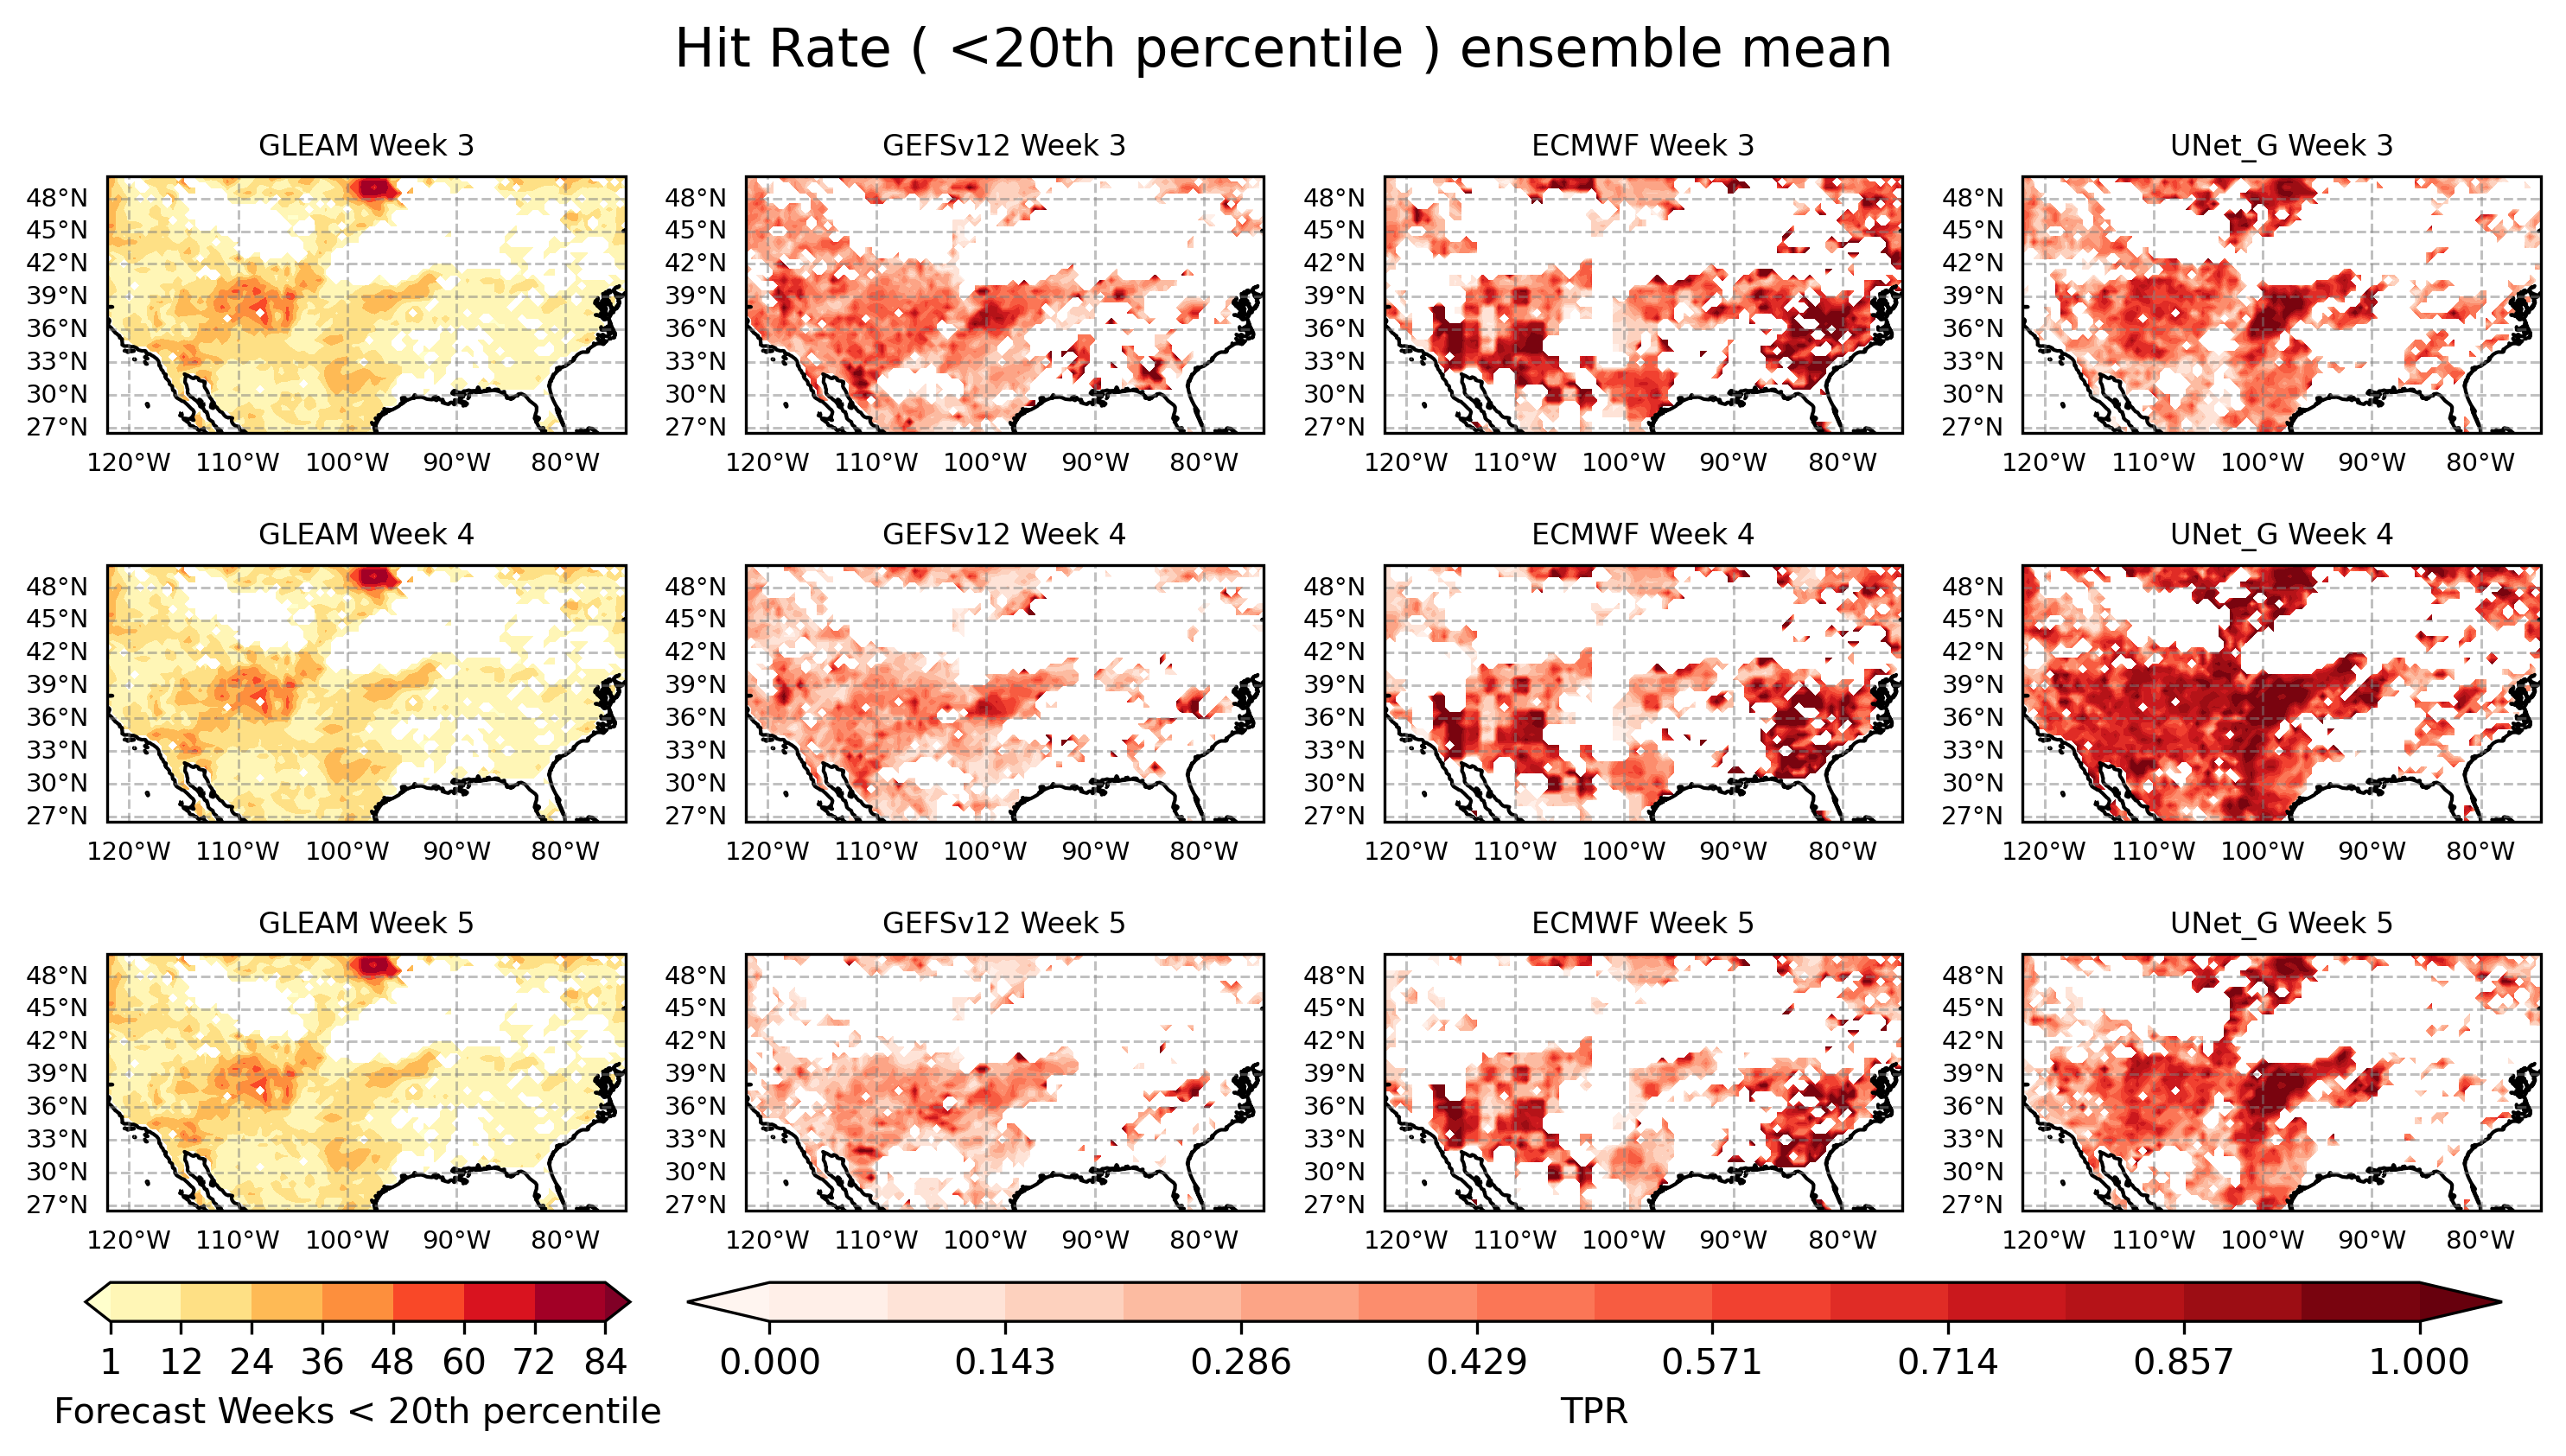

In [60]:
'''Raw ECMWF and GEFSv12 have their own distribution rather than using only observation distribution'''
percentile = 20

if region_name == 'CONUS':
    hitRate, experiment,percentile =  return_HITRATE_data_by_percentile_with_own_distribution(percentile=percentile,unet_experiment='EX29')
    plot_by_percentile_for_hitRate_CONUS_with_own_distribution(hitRate,experiment,percentile)

In [ ]:
'''Raw ECMWF and GEFSv12 rely on only observation distribution'''

percentile = 20

if region_name == 'CONUS':
    hitRate, experiment,percentile =  return_HITRATE_data_by_percentile(percentile=percentile,unet_experiment='EX29')
    plot_by_percentile_for_hitRate_CONUS(hitRate,experiment,percentile)

# Find the percentile difference between correctly predicted percentiles

In [35]:
def setup_percentage_difference_of_TP_with_ensemble_mean(week_lead, region_name, test_start, test_end, unet_experiment):

    ''' FORECAST ANOMALY - OBSERVATION ANOMALY'''
    #Test 
    # week_lead=1
    # percentile_eval = 20

    #Save dir
    dir_ = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_TP_difference_ensemble_mean.npy'
    save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_TP_difference_ensemble_mean.npy'
    save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats_TP_difference_ensemble_mean.npy'
    save_obs_binary = f'{save_dir}/Wk{week_lead}_obs_stats_TP_difference_ensemble_mean.npy'
    save_emos = f'{save_dir}/Wk{week_lead}_emos_stats_TP_difference_ensemble_mean.npy'
    
    day_num = (week_lead*7) -1

    def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, 
                                  x_vals,emos_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
        def find_percentage(perc_,o_vals,fcst):
            fcst_ =  np.where(fcst<perc_,1,0)
            obs_binary = np.where((o_vals<perc_),1,0)

            #Now find the deviation when true
            correct_fcst = np.where(fcst_,fcst,np.nan)
            correct_obs = np.where(obs_binary,o_vals,np.nan)
            
            subtract = correct_fcst - correct_obs
            subtract = np.nanmean(subtract,axis=0)
            
            '''Take the mean to find the probability of correct'''
            subtract.shape #(48, 96)

            return(subtract)

        g_perc = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc = find_percentage(perc_,o_vals,e_vals)
        u_gefs_perc = find_percentage(perc_,o_vals,u_gefs_vals)
        u_ecmwf_perc = find_percentage(perc_,o_vals,u_ecmwf_vals)
        x_perc = find_percentage(perc_,o_vals,x_vals)
        emos_perc = find_percentage(perc_,o_vals,emos_vals)
        return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc,emos_perc)


    
    def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, 
                                  x_vals,emos_vals):
        perc_= obs_percent[f'{percentile_num}th_percentile'].values
        
        def find_percentage(perc_,o_vals,fcst):
            fcst_ =  np.where(fcst>perc_,1,0)
            obs_binary = np.where((o_vals>perc_),1,0)
            '''Take the mean to find the probability of correct'''
            fcst.shape #(104, 48, 96)
            #Now find the deviation when true

            correct_fcst = np.where(fcst_,fcst,np.nan)
            correct_obs = np.where(obs_binary,o_vals,np.nan)
            
            subtract = correct_fcst - correct_obs
            subtract = np.nanmean(subtract,axis=0)
            
            return(subtract)

        g_perc = find_percentage(perc_,o_vals,g_vals)
        g_perc.shape
        e_perc = find_percentage(perc_,o_vals,e_vals)
        u_gefs_perc = find_percentage(perc_,o_vals,u_gefs_vals)
        u_ecmwf_perc = find_percentage(perc_,o_vals,u_ecmwf_vals)
        x_perc = find_percentage(perc_,o_vals,x_vals)
        emos_perc = find_percentage(perc_,o_vals,emos_vals)
        
        return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc,emos_perc)

    
    print('Loading observation and baseline anomaly files')
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

    obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
    obs_percent['95th_percentile'].shape #(104, 48, 96)

    #Get UNET prediction (single file)
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{unet_experiment}*'))
    #Get the ECMWF file

    ec_unet = [i for i in unet_files if 'ECMWF' in i][0]
    gef_unet = [i for i in unet_files if f'{unet_experiment}_regular_RZSM' in i][0]
    

    test_ec_unet =  verifications.reverse_min_max_scaling(np.load(ec_unet), region_name, day_num, 'ECMWF', 2019)[2,:,:,:,0] #We only want the last channel
    test_ec_unet = np.reshape(test_ec_unet,(test_ec_unet.shape[0]//11,11,test_ec_unet.shape[1],test_ec_unet.shape[2]))
    test_ec_unet.shape
    #Now mask the input
    test_ec_unet = np.where(mask_anom == 1,test_ec_unet,np.nan)
    save_unet_ecmwf = f"{save_dir}/{ec_unet.split('/')[-1].split('.npy')[0]}_stats_TP_difference_ensemble_mean.npy"
    
    test_gef_unet =  verifications.reverse_min_max_scaling(np.load(gef_unet), region_name, day_num, 'GEFSv12', 2019)[2,:,:,:,0] #We only want the last channel
    test_gef_unet = np.reshape(test_gef_unet,(test_gef_unet.shape[0]//11,11,test_gef_unet.shape[1],test_gef_unet.shape[2]))
    test_gef_unet.shape
    #Now mask the input
    test_gef_unet = np.where(mask_anom == 1,test_gef_unet,np.nan)
    save_unet_gefs = f"{save_dir}/{gef_unet.split('/')[-1].split('.npy')[0]}_stats_TP_difference_ensemble_mean.npy"

    final_perc_gefs = np.zeros(shape=(48,96,8)) #Adding 8 channels for the different anomaly spreads
    final_perc_gefs[:,:,:] = np.nan
    final_perc_ecmwf = final_perc_gefs.copy()
    final_perc_unet_gefs = final_perc_gefs.copy()
    final_perc_unet_ecmwf = final_perc_gefs.copy()
    final_perc_emos = final_perc_gefs.copy()
    
    #XGBoost
    #Load the XGBoost data
    if region_name == 'CONUS':
        xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]
    
        # break
        #Still working here
        test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
        load_ = np.expand_dims(np.load(xgboost_files),-1)
        load_.shape
        load_ = np.where(load_ == 0,np.nan,load_)
        load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num,'GEFSv12',test_year)#We only want the last channel
        
        xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
        for j in range(11):
            xg[:,j,:,:,:] = load_
    
        xg = xg.squeeze()
        xg.shape
        final_perc_xg = final_perc_gefs.copy()
        x_vals = np.nanmean(xg,axis=1)
    else:
        x_vals = final_perc_gefs.copy()
        
    #Check if the predicted anomaly is below each threshold

    file = baseline_anomaly
    file.RZSM.shape
    #Test
    # idx = 0
    # mx = 0
    # ix = 10
    # iy =10 #NEGATIVE ANOMALY VALUE
    # iy =5 #POSITIVE ANOMALY VALUE

    #Use np.where to find the values of the percentile

    #Take ensemble mean
    o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
    g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
    e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
    u_gefs_vals = np.nanmean(test_gef_unet,axis=1)
    u_ecmwf_vals = np.nanmean(test_ec_unet,axis=1)
    emos_vals = np.nanmean(emos_testing.sel(L=day_num).RZSM,axis=1)

    u_gefs_vals.shape
    x_vals.shape

    ### Returns return(g_perc,e_perc,u_gefs_perc,u_ecmwf_perc,x_perc)
    ### order [obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals,u_ecmwf_vals, x_vals]
    
    
    for idx,percentile_num in enumerate([5,10,20,33]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_perc_gefs[:,:,idx], final_perc_ecmwf[:,:,idx], final_perc_unet_gefs[:,:,idx], final_perc_unet_ecmwf[:,:,idx], \
        final_perc_xg[:,:,idx],final_perc_emos[:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals, u_ecmwf_vals,x_vals,emos_vals)

    
    for idx,percentile_num in enumerate([66,80,90,95]):
        '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
        final_perc_gefs[:,:,idx+4], final_perc_ecmwf[:,:,idx+4], final_perc_unet_gefs[:,:,idx+4], final_perc_unet_ecmwf[:,:,idx+4], \
        final_perc_xg[:,:,idx+4],final_perc_emos[:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_gefs_vals, u_ecmwf_vals,x_vals,emos_vals)


    #Save files for later use
    np.save(save_ecmwf,final_perc_ecmwf)
    np.save(save_gefs, final_perc_gefs)
    np.save(save_unet_gefs, final_perc_unet_gefs)
    np.save(save_unet_ecmwf, final_perc_unet_ecmwf)
    np.save(save_xg, final_perc_xg)
    np.save(save_emos, final_perc_emos)


In [37]:
def load_binary_occurrence_data(week_lead,unet_experiment,region_name):
    if percentile == 20:
        idPercentile = 2
    elif percentile == 10:
        idPercentile = 1
    elif percentile == 5:
        idPercentile = 0
    elif percentile == 33:
        idPercentile = 3
    dir_ = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    all_files = sorted(glob(f'{dir_}/Wk{week_lead}_testing*{unet_experiment}*Idist*'))
    ecm_file_unet = [i for i in all_files if 'ECMWF' in i][0]
    gef_file_unet = [i for i in all_files if 'ECMWF' not in i][0]

    ecm_bin_unet = np.load(ecm_file_unet)[:,:,:,idPercentile]
    gef_bin_unet = np.load(gef_file_unet)[:,:,:,idPercentile]
    
    # break
    ecmwf_bin = f'{dir_}/Wk{week_lead}_ecmwf_stats_TP_FP_ensemble_meanIdist.npy'
    ecmwf_bin = np.load(ecmwf_bin)[:,:,:,idPercentile]
    
    gefs_bin = f'{dir_}/Wk{week_lead}_gefs_stats_TP_FP_ensemble_meanIdist.npy'
    gefs_bin = np.load(gefs_bin)[:,:,:,idPercentile]

    # save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_TP_FP_ensemble_meanIdist.npy'
    # save_emos = f'{dir_}/Wk{week_lead}_emos_stats_TP_FP_ensemble_meanIdist.npy'

    obs_bin = np.load(f'{dir_}/Wk{week_lead}_obs_stats_TP_FP_ensemble_meanIdist.npy')
    obs_bin = obs_bin[:,:,:,idPercentile]
    return (ecm_bin_unet,gef_bin_unet, ecmwf_bin, gefs_bin, obs_bin)

In [52]:
def setup_percentile_difference_of_TP_with_ensemble_mean_with_own_distribution(region_name, 
                                                                               test_start, test_end, unet_experiment,percentile):
    
    ''' FORECAST ANOMALY - OBSERVATION ANOMALY'''
    #Test 
    # week_lead=3
    # percentile = 20

    #Save dir
    save_dir = f'Data/correct_anomaly_percentile_statistics/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    percentage_dict = {}

    for week_lead in [3,4,5]:
        print(f'Working on lead {week_lead}')
        percentage_dict[f'Week {week_lead}'] = {}
        
        save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_TP_percentile_difference_ensemble_meanIdist.npy'
        save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_TP_percentile_difference_ensemble_meanIdist.npy'
        save_unet_gefs = f'{save_dir}/Wk{week_lead}_{unet_experiment}_stats_TP_percentile_difference_ensemble_meanIdist.npy'
        
        day_num = (week_lead*7) -1

        '''What we need for this operation
        1.) OBS percentile values
        2.) Raw ECMWF and GEFSv12 percentile values
        3.) Percentile values of Experiment UNet
        4.) Binary values for the specific percentile'''
    
        '''1.) OBS percentile values'''
        percentile_files = xr.open_mfdataset('/glade/work/klesinger/FD_RZSM_deep_learning/Data/GLEAM/RZSM_percentile_reformat/*',combine='nested',concat_dim=['S']).sel(S=slice(test_start,test_end)).sel(L=day_num).mean(dim='M')
        percentile_files_obs = percentile_files.RZSM_percentile.values
        percentile_files_obs.shape
    
        '''2.) Raw ECMWF and GEFSv12 percentile values'''
        raw_ecmwf_percentiles = ecmwf_perc.RZSM.sel(L=day_num).values
        raw_gefs_percentiles = gefs_perc.RZSM.sel(L=day_num).values
        raw_gefs_percentiles.shape
    
        '''2.) Percentile values of Experiment UNet'''
        percentile_unet = xr.open_mfdataset(f'/glade/work/klesinger/FD_RZSM_deep_learning/Data/UNET_percentiles_MEM/{unet_experiment}/*',combine='nested',concat_dim=['S']).sel(S=slice(test_start,test_end)).sel(L=day_num)
        percentile_unet = percentile_unet.RZSM.values
        percentile_unet.shape
        
        '''4.) Raw ECMWF and GEFSv12 percentile values'''
        ecm_bin_unet,gef_bin_unet, ecmwf_bin, gefs_bin, obs_bin = load_binary_occurrence_data(week_lead,unet_experiment,region_name)

        percentage_dict[f'Week {week_lead}']['OBS'] = np.nansum(obs_bin,axis=0)
        
        '''Now feed them all into the function to find the difference where there is a 1 for less than the percentile'''
    
        obs_perc = np.where(percentile_files_obs<=20,percentile_files_obs,np.nan)
        gefs_perc1 = np.where((percentile_files_obs<=20) & (raw_gefs_percentiles<=20),raw_gefs_percentiles,np.nan)
        ecmwf_perc1 = np.where((percentile_files_obs<=20) & (raw_ecmwf_percentiles<=20),raw_ecmwf_percentiles,np.nan)
        gef_perc_unet = np.where((percentile_files_obs<=20) & (percentile_unet<=20),percentile_unet,np.nan) #Only doing GEFSv12, haven't done the percentiles for UNET ECMWF EX29
    
        #Now Forecast - Observations of the percentiles
        fin_gefs = gefs_perc1 - obs_perc
        fin_ecmwf = ecmwf_perc1 - obs_perc
        fin_unet_gefs = gef_perc_unet - obs_perc

        fin_gefs = np.where(mask_anom == 1,fin_gefs,np.nan)
        fin_ecmwf = np.where(mask_anom == 1,fin_ecmwf,np.nan)
        fin_unet_gefs = np.where(mask_anom == 1,fin_unet_gefs,np.nan)

        percentage_dict[f'Week {week_lead}']['GEFSv12'] = np.nanmean(fin_gefs,axis=0)
        percentage_dict[f'Week {week_lead}']['ECMWF'] = np.nanmean(fin_ecmwf,axis=0)
        percentage_dict[f'Week {week_lead}']['DL-DM_G'] = np.nanmean(fin_unet_gefs,axis=0)
    
        final_perc_gefs = np.zeros(shape=(48,96)) #Adding 8 channels for the different anomaly spreads
        final_perc_gefs[:,:] = np.nanmean(fin_gefs,axis=0)
        final_perc_gefs
        
        final_perc_ecmwf = final_perc_gefs.copy()
        final_perc_ecmwf[:,:] = np.nanmean(fin_ecmwf,axis=0)
        
        final_perc_unet_gefs = final_perc_gefs.copy()
        final_perc_unet_gefs[:,:] = np.nanmean(fin_unet_gefs,axis=0)
    
        #Save files for later use
        np.save(save_ecmwf,final_perc_ecmwf)
        np.save(save_gefs, final_perc_gefs)
        np.save(save_unet_gefs, final_perc_unet_gefs)

    return(percentage_dict)

In [53]:
def plot_by_percentile_difference_for_hitRate_CONUS_with_own_distribution(percentage_dict,percentile,experiment='EX29'):

    save_dir = f'Outputs/hit_rate/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    #Keep only 1 instance of the observation counts below the 20th percentile
    rmax_, rmin_, omax_,omin_ = get_min_max_without_obs(hitRate = percentage_dict)
        
    # global_max, global_min = max(max_), min(min_)
    v_obs = np.linspace(1, omax_, 8, endpoint=True,dtype=int)
    v_ref = np.linspace(rmin_, rmax_, 15, endpoint=True)
    pos_vals = [i for i in v_ref if i >0.0]
    neg_vals = [i for i in v_ref if i <0.0]
    neg_vals.append(0.0)
    
    v_ref = neg_vals + pos_vals
    
    norm_ref = TwoSlopeNorm(0.0, vmin=v_ref[0], vmax=v_ref[-1])

    cmap = 'RdBu'
    cmap_obs = 'YlOrRd'
    
    fig, axs = plt.subplots(
        nrows = len(percentage_dict.keys()), ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300)
    
    axs = axs.flatten()
    
    lon = mask.X.values
    lat = mask.Y.values
    grid_label_fontsize = 7
    
    axs_start = 0
    for lead in percentage_dict.keys():
        for model in percentage_dict[lead].keys():
            if ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_ECMWF' in model):
                pass
            else:
                data = percentage_dict[lead][model]
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                              llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                
                x, y = map(*np.meshgrid(lon, lat))
                # Adjust the text coordinates based on the actual data coordinates

                if model == 'OBS':
                    data = np.where(data==0,np.nan,data)
                    obs = axs[axs_start].contourf(x, y, data, levels=v_obs, extend='both',
                      transform=ccrs.PlateCarree(), cmap=cmap_obs)
                else:
                    data = np.where(data==0,np.nan,data)
                    im = axs[axs_start].contourf(x, y, data, levels=v_ref, extend='both',
                                          transform=ccrs.PlateCarree(), cmap=cmap,norm=norm_ref)
                
                gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                           linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                
                if axs_start in [0,4,8]:
                    gl.left_labels = True
                
                gl.xlabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the x labels
                gl.ylabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the y labels
                   
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                axs[axs_start].coastlines()
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                if model == 'OBS':
                    axs[axs_start].set_title(f'GLEAM {lead}',fontsize=8)
                elif model == f'{experiment}_GEFSv12':
                    axs[axs_start].set_title(f'DL-DM_G {lead}',fontsize=8)
                else:
                    axs[axs_start].set_title(f'{model} {lead}',fontsize=8)
                axs_start+=1

    # Creating colorbars  [left, bottom, width, height] 
    cbar_ax_obs = fig.add_axes([0.038, -0.02, .21, .03])
    cbar_ax_ref = fig.add_axes([0.27, -0.02, .7, .03])

    cbar_obs = fig.colorbar(obs, cax=cbar_ax_obs, orientation='horizontal')
    cbar_ref = fig.colorbar(im, cax=cbar_ax_ref, orientation='horizontal')

    cbar_obs.set_label('Forecast Weeks < 20th percentile')
    cbar_ref.set_label('Percentile Difference')
    
    # cbar1 = fig.colorbar(im, ax=axs[:4], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar2 = fig.colorbar(im, ax=axs[9:], orientation='horizontal', pad=0.05, fraction=0.04)
    # cbar_ax = fig.add_axes([0.05, 0.0, .9, .04])

    # plt.text(-95, 30, 'B', fontsize=12, color='black', weight='bold')
    # plt.text(-65, 30, 'B', fontsize=12, color='black', weight='bold')
    # plt.text(-45, 30, 'C', fontsize=12, color='black', weight='bold')
    # plt.text(-45, 30, 'D', fontsize=12, color='black', weight='bold')
    
    # Draw the colorbar
    # cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    plt.suptitle(f'Percentile difference ( <{percentile}th percentile ) ensemble mean', fontsize=15)
    plt.tight_layout()
    
    print(f'Saving into {save_dir}/{experiment}_percentile_diff_{percentile}th_percentileIdist.png')
    plt.savefig(f'{save_dir}/{experiment}_percentile_diff_{percentile}th_percentileIdist.png',bbox_inches='tight')

    return(0)

# plot_by_percentile_difference_for_hitRate_CONUS_with_own_distribution(percentage_dict,percentile,experiment='EX29')

## Run

Working on lead 3


/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:67: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['GEFSv12'] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:68: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['ECMWF'] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:69: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['DL-DM_G'] = np.nanmean(fin_unet_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:72: RuntimeWarning: Mean of empty slice
  final_perc_gefs[:,:] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:76: RuntimeWarning: Mean of empty slice
  final_perc_ecmwf[:,:] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:79: RuntimeWarning: Mean of empty slice
  fina

Working on lead 4


/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:67: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['GEFSv12'] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:68: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['ECMWF'] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:69: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['DL-DM_G'] = np.nanmean(fin_unet_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:72: RuntimeWarning: Mean of empty slice
  final_perc_gefs[:,:] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:76: RuntimeWarning: Mean of empty slice
  final_perc_ecmwf[:,:] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:79: RuntimeWarning: Mean of empty slice
  fina

Working on lead 5


/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:67: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['GEFSv12'] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:68: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['ECMWF'] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:69: RuntimeWarning: Mean of empty slice
  percentage_dict[f'Week {week_lead}']['DL-DM_G'] = np.nanmean(fin_unet_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:72: RuntimeWarning: Mean of empty slice
  final_perc_gefs[:,:] = np.nanmean(fin_gefs,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:76: RuntimeWarning: Mean of empty slice
  final_perc_ecmwf[:,:] = np.nanmean(fin_ecmwf,axis=0)
/glade/derecho/scratch/klesinger/tmp/ipykernel_70491/1573132090.py:79: RuntimeWarning: Mean of empty slice
  fina

Saving into Outputs/hit_rate/CONUS/EX29_percentile_diff_20th_percentileIdist.png


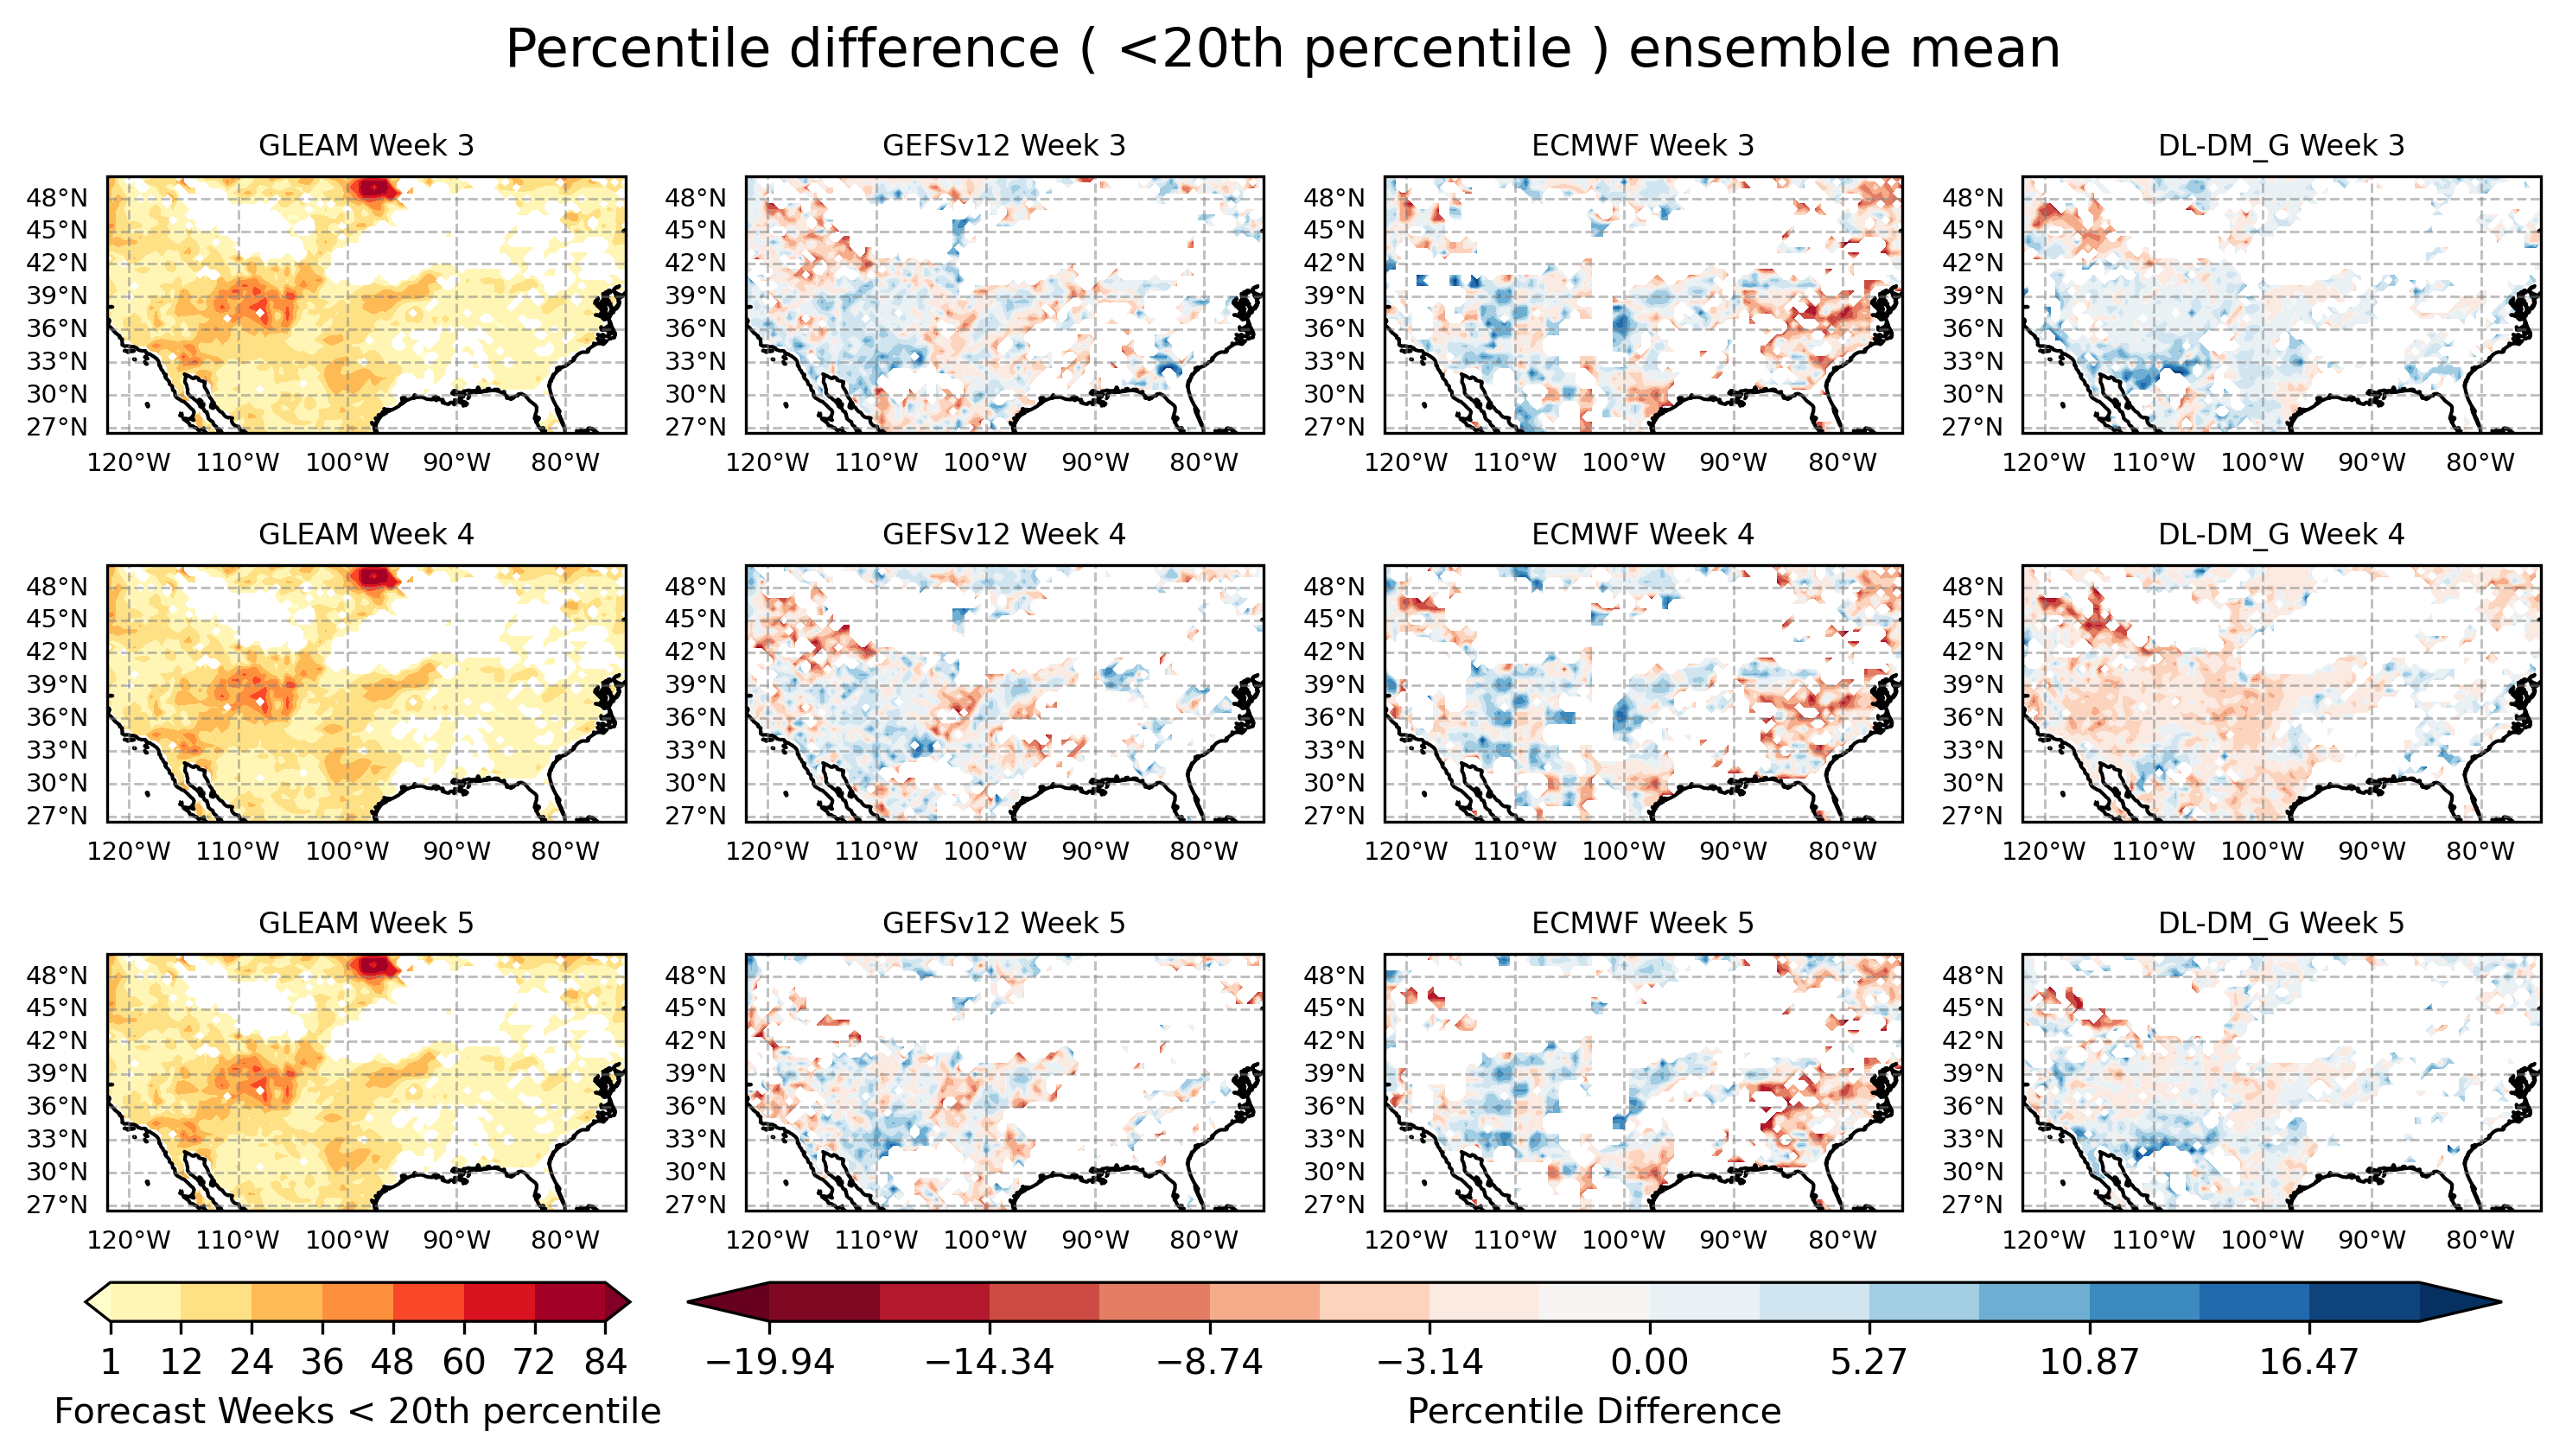

In [54]:
if region_name == 'CONUS':
    unet_experiment='EX29'
    percentile=20
    percentage_dict = setup_percentile_difference_of_TP_with_ensemble_mean_with_own_distribution(region_name, 
                                                                                   test_start, test_end, unet_experiment,percentile)
    plot_by_percentile_difference_for_hitRate_CONUS_with_own_distribution(percentage_dict,percentile,experiment='EX29')


# Plot difference for CONUS

In [12]:
'''Plot hit rate by grid cell'''

'''CREATE a ROC figure for classification below the 20th percentile'''

'''Only for 20th percentile'''
percentile = 20

#First save all data
def return_difference_data_by_percentile(percentile, unet_experiment):

    #where files are saved
    dir_ = f'Outputs/hit_rate_stats/{region_name}'
    
    save_dir = f'Outputs/hit_rate_stats/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values


    if percentile == 20:
        idPercentile = 2
    elif percentile == 10:
        idPercentile = 1
    elif percentile == 5:
        idPercentile = 0
    elif percentile == 33:
        idPercentile = 3

    anomaly_diff = {}

    for week_lead in [3,4,5]:
        all_files = sorted(glob(f'{dir_}/Wk{week_lead}_testing*{unet_experiment}*difference_ensemble_mean*'))
        ecm_file_unet = [i for i in all_files if 'ECMWF' in i][0]
        gef_file_unet = [i for i in all_files if 'ECMWF' not in i][0]
        
        anomaly_diff[f'Week {week_lead}'] = {}
        
        # break
        save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_TP_difference_ensemble_mean.npy'
        save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_TP_difference_ensemble_mean.npy'
        save_unet_gefs = gef_file_unet
        save_unet_ecmwf = ecm_file_unet
        save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_TP_difference_ensemble_mean.npy'
        save_emos = f'{dir_}/Wk{week_lead}_emos_stats_TP_difference_ensemble_mean.npy'
        
    
        for ref_name, ref_file in zip(['GEFSv12', 'ECMWF', 'XGBoost', f'{unet_experiment}_GEFSv12', f'{unet_experiment}_ECMWF','EMOS' ],[save_gefs, save_ecmwf, save_xg, save_unet_gefs, save_unet_ecmwf, save_emos]):
            # break
            
            out_plot = np.zeros(shape=(48,96))
            # ax = axes[ax_start]
            
            # break
            reforecast = np.load(ref_file)
            reforecast.shape
            ref_subset = reforecast[:,:,idPercentile]
            ref_subset.shape
            anomaly_diff[f'Week {week_lead}'][ref_name] = ref_subset
     
    return(anomaly_diff,unet_experiment,percentile)
            




In [15]:
def return_min_Max_all_values(all_values):
    max_ = []
    min_ = []
    for i in range(len(all_values)):
        max_.append(max(all_values[i][0]))
        min_.append(min(all_values[i][0]))
    return(max_,min_)

In [16]:
def reorder_nested_dict(anomaly_diff, desired_order):
    reordered_dict = {}
    for k in anomaly_diff.keys():
        # break
        reordered_dict[k] = {}
        for key in desired_order:
            # break
            if key in anomaly_diff[k]:
                if isinstance(anomaly_diff[k][key], dict):
                    reordered_dict[k][key] = reorder_nested_dict(anomaly_diff[k][key], desired_order)
                else:
                    reordered_dict[k][key] = anomaly_diff[k][key]
    return reordered_dict



In [17]:
def plot_by_percentile_for_difference_CONUS(anomaly_diff,hitRate,experiment,percentile):

    '''The hitRate object must run a few code blocks above. This has the counts for the number of observation forecasts below the 20th percentile during the testing period'''
    save_dir = f'Outputs/hit_rate/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    #Keep only 1 instance of the observation counts below the 20th percentile
    _, _, omax_,omin_ = get_min_max_without_obs(hitRate)
    v_obs = np.linspace(1, omax_, 8, endpoint=True,dtype=int)
    cmap_obs = 'YlOrRd'
    
    all_values = [value for inner_dict in anomaly_diff.values() for value in inner_dict.values()]
    
    max_,min_ = return_min_Max_all_values(all_values)
    global_max, global_min = max(max_), min(min_)
    v = np.linspace(global_min, global_max, 20, endpoint=True)
    
    pos_vals = [i for i in v if i >0]
    neg_vals = [i for i in v if i <0]

    neg_vals.append(0)
    v = neg_vals + pos_vals
    norm = TwoSlopeNorm(0, vmin=v[0], vmax=v[-1])


    anomaly_diff['Week 3']['OBS'] = hitRate['Week 3']
    anomaly_diff['Week 4']['OBS'] = hitRate['Week 4']
    anomaly_diff['Week 5']['OBS'] = hitRate['Week 5']

    desired_order = ['OBS', 'GEFSv12', 'ECMWF', 'EX27_ECMWF', 'EX27_GEFSv12','XGBoost','EMOS']
    anomaly_diff=reorder_nested_dict(anomaly_diff, desired_order)

    cmap = 'bwr'
    
    fig, axs = plt.subplots(
        nrows = 3, ncols= 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5), dpi=300)
    
    axs = axs.flatten()
    grid_label_fontsize = 7
    
    lon = mask.X.values
    lat = mask.Y.values
    
    axs_start = 0
    for lead in anomaly_diff.keys():
        for model in anomaly_diff[lead].keys():
            if ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_GEFSv12' in model):
                pass
            elif 'OBS' in model:
                data = hitRate[lead]['OBS']
                data = np.where(data==0, np.nan, data)
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                          llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                x, y = map(*np.meshgrid(lon, lat))
                obs = axs[axs_start].contourf(x, y, data, levels=v_obs, extend='both',
                                  transform=ccrs.PlateCarree(), cmap=cmap_obs)
            else:
                data = anomaly_diff[lead][model]
                map = Basemap(projection='cyl', llcrnrlat=lat[-1] - 1.5, urcrnrlat=lat[0],
                              llcrnrlon=(lon[0] - 360 - 6), urcrnrlon=(lon[-1] - 360 + 20), resolution='l')
                x, y = map(*np.meshgrid(lon, lat))
                im = axs[axs_start].contourf(x, y, data, levels=v, extend='both',
                                  transform=ccrs.PlateCarree(), cmap=cmap, norm =norm)
                
            if ('EMOS' in model) or ('XGBoost' in model) or (f'{experiment}_GEFSv12' in model):
                pass
            else:
                gl = axs[axs_start].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                           linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                if 'OBS' in model:
                    gl.left_labels = True
                else:
                    gl.left_labels = False
                    
                gl.xlabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the x labels
                gl.ylabel_style = {'fontsize': grid_label_fontsize}  # Set the fontsize for the y labels
                    
                gl.xformatter = LongitudeFormatter()
                gl.yformatter = LatitudeFormatter()
                axs[axs_start].coastlines()
                axs[axs_start].set_aspect('equal')  # this makes the plots better
                if 'OBS' in model:
                    axs[axs_start].set_title(f'GLEAM {lead}',fontsize=8)
                    
                else:
                    axs[axs_start].set_title(f'{model} {lead}',fontsize=8)
                axs_start+=1
    
    # Creating colorbars  [left, bottom, width, height] 
    cbar_ax_obs = fig.add_axes([0.045, -0.03, .21, .03])
    cbar_ax_ref = fig.add_axes([0.31, -0.03, .66, .03])

    cbar_obs = fig.colorbar(obs, cax=cbar_ax_obs, orientation='horizontal')
    cbar_ref = fig.colorbar(im, cax=cbar_ax_ref, orientation='horizontal')

    cbar_obs.set_label('Forecast Weeks < 20th percentile')
    cbar_ref.set_label('Anomaly Difference (m3/m3)')

    plt.suptitle(f'Anomaly Difference ( <{percentile}th percentile ) ensemble mean \n (FCST - OBS anomaly)', fontsize=15)
    plt.tight_layout()
    
    plt.savefig(f'{save_dir}/{experiment}_anom_difference_{percentile}th_percentile.png',bbox_inches='tight')

    return(0)


'''RUN'''
percentile = 20
if region_name == 'CONUS':
    anomaly_diff, experiment,percentile =  return_difference_data_by_percentile(percentile=percentile,unet_experiment='EX27')
    plot_by_percentile_for_difference_CONUS(anomaly_diff,hitRate,experiment,percentile)


NameError: name 'hitRate' is not defined

# Extra code for plotting other things

In [ ]:
def setup_improvement_over_baseline_by_region_image(metric_dict,week_lead, region_name,metric_name,xlim_start,xlim_end):
    #Need to make the data into an array where:
    # ROWS = number of different realizations (so approximatley 15)
    # COLS = values (ACC or CRPS)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')

    # to return a group of the key-value
    # # pairs in the dictionary
    # result = metric_dict.items()
     
    # # Convert object to a list
    # data = list(result)
     
    # # Convert list to an array
    # numpyArray = np.array(data)
     
    # # print the numpy array
    # print(numpyArray)
    #convert to a dataframe
    df = pd.DataFrame(metric_dict).T

    if metric_name == 'CRPS':
        joypy.joyplot(df.T,colormap=cm.autumn_r,
                     title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(0,0.05))
    else:
        joypy.joyplot(df.T,colormap=cm.autumn_r,
             title=f"{metric_name} by Experiment Week {week_lead}",
                     x_range=(xlim_start,xlim_end))
        
    plt.savefig(f'{save_dir}/Wk{week_lead}_{metric_name}.png')

    # colormap=cm.autumn_r
    # list_df = []
    # name_df = list(df.index)
    
    # for i in range(len(df)):
    #     list_df.append(np.array(df.iloc[i,:]))

    # fig = ridgeplot(samples = list_df,
    #                labels=name_df)
    # fig.update_layout(height=500, width=800)
    # fig.show()

    #Need to find the number of columns based on gefs

    return('Completed')


In [ ]:
# def ridgeplot_ACC_MEM(week_lead, region_name, test_start, test_end):

#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format

#     obs = obs.mean(dim='M')
#     gefs = gefs.mean(dim='M')
#     ecmwf = ecmwf.mean(dim='M')

    
#     #First get the ACC values of GEFS and ECMWF relative to observations
#     gefs_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=gefs[putils.xarray_varname(gefs)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
    
#     ecmwf_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                     forecast_converted=ecmwf[putils.xarray_varname(ecmwf)].to_numpy(),
#                                                                                     obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()
#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_acc)

#     gefs_acc = gefs_acc[ec_not_nan]
#     ecmwf_acc = ecmwf_acc[ec_not_nan]
    
#     metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         test_name = i.split('testing_')[-1].split('.npy')[0]
#         test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#         test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#         #Take the mean of models
#         test = np.nanmean(test,axis=1)
#         unet_acc = verifications.anomaly_correlation_coefficient_function_ensemble_mean(var_OUT=np.empty_like(var_OUT), 
#                                                                                 forecast_converted=test,
#                                                                                 obs_converted=obs[putils.xarray_varname(obs)].to_numpy()).flatten()

#         unet_acc = unet_acc[ec_not_nan]
        
#         metric_dict.update({test_name: unet_acc})
    
#     setup_ridgeplot_array(metric_dict,week_lead, region_name,metric_name='ACC')

#     return('Completed')
    

In [ ]:
def ridgeplot_ACC_climpred_only_UNET(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments):

    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    #For a single lead
    obs, gefs, ecmwf, var_OUT_overwrite, template_testing_only_by_lead= select_data_by_lead(obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only, day_num)

    print('Calculating ACC on GEFSv12 and ECMWF')
    gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    gefs_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_gefs_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    ecmwf_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_BC_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(additive_bias_ecmwf_final.sel(L=day_num).expand_dims({'L':1})), verifications.rename_obs_for_climpred(obs_original))

    def flatten_files(file):
        return(file[putils.xarray_varname(file)].values.flatten())

    print('Masking files with np.nan values')
    gefs_acc = flatten_files(gefs_acc)
    gefs_BC_acc = flatten_files(gefs_BC_acc)
    ecmwf_acc = flatten_files(ecmwf_acc)
    ecmwf_BC_acc = flatten_files(ecmwf_BC_acc)
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    gefs_BC_acc = gefs_BC_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    ecmwf_BC_acc = ecmwf_BC_acc[ec_not_nan]

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
        
    df = pd.DataFrame()
    df = add_to_dataframe(df, ecmwf_acc, 'ECMWF')
    df = add_to_dataframe(df, ecmwf_BC_acc, 'ECMWF_BC')
    df = add_to_dataframe(df, gefs_acc, 'GEFSv12')
    df = add_to_dataframe(df, gefs_BC_acc, 'GEFSv12_BC')

    if single_experiment_or_all_experiments == 'all':
        #Now for all predictions from UNET, make the ACC
        #Can add *denseLar* for only the dense ones
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    else:
        unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*{single_experiment_or_all_experiments}*')) #Will all data
    
   
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
        unet_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))
        unet_acc = unet_acc.acc.values.flatten()
        unet_acc = unet_acc[ec_not_nan]
        df = add_to_dataframe(df, unet_acc, test_name)
        

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    if single_experiment_or_all_experiments == 'all':
        joypy.joyplot(df,colormap=cm.autumn_r,
                     title=f"ACC by Experiment Week {week_lead}",
                     fade=True,figsize=(10,30))
    else:
        joypy.joyplot(df,colormap=cm.autumn_r,
             title=f"ACC by Experiment Week {week_lead}",
             fade=True,figsize=(5,10))


    plt.savefig(f'{save_dir}/Wk{week_lead}_ACC_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

In [ ]:

    # ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end, single_experiment_or_all_experiments = 'EX27')

In [ ]:

for week_lead in [3,4,5]:
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*')) #With a specific subset of data
    unet_files = [i for i in unet_files if 'final_mean_ensemble' not in i]
    unet_files = [i for i in unet_files if 'mean' not in i]
    for unet_file in unet_files:
        evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end,unet_file)

In [ ]:
def ridgeplot_CRPS(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #First get the ACC values of GEFS and ECMWF relative to observations
    gefs_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()
    
    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_acc)

    gefs_acc = gefs_acc[ec_not_nan]
    ecmwf_acc = ecmwf_acc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_acc, 'ECMWF': ecmwf_acc})


    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crps.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num,new_source,test_year)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_CRPS(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crps.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPS')

    return('Completed')
    

In [ ]:
def ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    #Find the standard deviation of the ensemble forecast for each day
    gefs_std = gefs.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
    #check the output (looks good)
    # gefs.RZSM[0,:,0,10,10].values
    # np.nanmean(gefs.RZSM[0,:,0,10,10].values)
    # np.nanstd(gefs.RZSM[0,:,0,10,10].values)
    # gefs_std.RZSM[0,0,10,10].values

    ecmwf_std = ecmwf.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_std!=0

    gefs_std = gefs_std[ec_not_nan]
    ecmwf_std = ecmwf_std[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_std, 'ECMWF': ecmwf_std})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = emos_.std(dim='M',skipna=True).mean(dim='S').sel(L=day_num).RZSM.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))


    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                if 'ECMWF' in i:
                    new_source = 'ECMWF'
                else:
                    new_source = 'GEFSv12'
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num,new_source,test_year)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
                unet_std = unet_std[ec_not_nan]
                metric_dict.update({test_name:unet_std})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            if 'ECMWF' in i:
                new_source = 'ECMWF'
            else:
                new_source = 'GEFSv12'
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
            unet_std =  add_to_file.std(dim='M',skipna=True).mean(dim='S').isel(L=0).RZSM.values.flatten()
            unet_std = unet_std[ec_not_nan]
            metric_dict.update({test_name:unet_std})

    xlim_start, xlim_end = 0,0.04
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Standard Deviation',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
def find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end):

    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    obs_value = obs_anomaly_SubX_format.mean(dim='M')

    #Find if forecast ensemble contains the value

    def find_if_forecast_contains_obs(forecast,obs):
        
        max_ = forecast.max(dim='M')
        min_ = forecast.min(dim='M')

        correct = xr.where((obs_value<max_) & (obs_value>min_),1,0)
        percent = (correct.sum(dim='S')/len(correct.S.values)).isel(L=0).RZSM.values.flatten()
        
        return(percent)
    
    
    gefs_perc = find_if_forecast_contains_obs(gefs,obs_value)

    ecmwf_perc = find_if_forecast_contains_obs(ecmwf,obs_value)

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ecmwf_perc!=0

    gefs_perc = gefs_perc[ec_not_nan]
    ecmwf_perc = ecmwf_perc[ec_not_nan]
    
    metric_dict.update({'GEFSv12': gefs_perc, 'ECMWF': ecmwf_perc})
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))

    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        test_name = i.split('testing_')[-1].split('.npy')[0]
        test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
        test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
        test = np.expand_dims(test, -1)
        #Now re-order the dimensions to match SubX
        test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
        
        add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test

        unet_perc = find_if_forecast_contains_obs(add_to_file,obs_value)
        
        unet_perc = unet_perc[ec_not_nan]
        
        metric_dict.update({test_name: unet_perc})
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='Percent of Inits within Ensemble Spread')

    return('Completed')
    

In [ ]:
def ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end):
   
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]


    #Now stack each of the them in a dataframe 

    def add_to_dataframe(df, file, source_or_name):
        a=pd.DataFrame()
        a[source_or_name] =file
        return(pd.concat([df,a],axis=1))
    
    df = pd.DataFrame()

    df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
    df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        if 'denseLargeMean_RZSM' in i:
            pass
        else:
            # break
            add_to_file = gefs.copy(deep = True)
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            test =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))

            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = test
            
            unet_c = verifications.create_climpred_crpss_skill_score(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()
    
            unet_c = unet_c[ec_not_nan]
    
            # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
            df = add_to_dataframe(df, unet_c, test_name)

    save_dir = f'Outputs/joyplots/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    
    #Now plot all on 1 figure (Cant do it with joyplot)
    # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
    # axs = axs.flatten()

    '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
    joypy.joyplot(df,colormap=cm.autumn_r,
                 title=f"CRPSS by Experiment Week {week_lead}",
                 fade=True,
                 x_range=(-5,1.1))
    plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_climpred.png')

    # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
    #     # break
    #     plot_ = out_df[out_df['Reference'] == i]
        
    #     joypy.joyplot(plot_,colormap=cm.autumn_r,
    #                  title=f"{i} by Experiment Week {week_lead}",
    #                  fade=True)
    #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
    # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
    # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
    return('Completed')
    

In [ ]:
def ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end):


    metric_dict = {}
    
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format


    #First get the ACC values of GEFS and ECMWF relative to observations
    # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
    gefs_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get the ACC values of GEFS and ECMWF relative to observations
    ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

    #First get any missing values from ECMWF to properly construct ridgeplot
    ec_not_nan = ~np.isnan(ecmwf_c)

    gefs_c = gefs_c[ec_not_nan]
    ecmwf_c = ecmwf_c[ec_not_nan]

    metric_dict.update({'GEFSv12': gefs_c, 'ECMWF': ecmwf_c})

    #Now add EMOS results
    if region_name == 'CONUS':
       
        #First get the ACC values of GEFS and ECMWF relative to observations
        emos_acc = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').sel(lead=day_num).crpss.values.flatten()

        emos_final = emos_acc[ec_not_nan]
        metric_dict.update({'EMOS':emos_final})
    
    
    #Now for all predictions from UNET, make the ACC
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
    # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
    #Now loop through and open file, convert to anomaly and compute ACC score
    for i in unet_files:
        # break
        add_to_file = gefs.copy(deep = True)
        if 'mean' in i:
            # break
            if 'final_mean_ensemble' in i:
                # break
                #Still working here
                test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
                load_ = np.expand_dims(np.load(i),-1)
                load_.shape
                load_ = np.reshape(load_,(load_.shape[0],load_.shape[-2], load_.shape[-1], load_.shape[1], load_.shape[2]))
                load_.shape
                load_ = np.where(load_ == 0,np.nan,load_)
                load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num,source,test_year)
                add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
                
                unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

                unet_persist = unet_persist[ec_not_nan]
                metric_dict.update({test_name:unet_persist})

        else:
        
            test_name = i.split('testing_')[-1].split('.npy')[0]
            test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
            test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
            test = np.expand_dims(test, -1)
            #Now re-order the dimensions to match SubX
            load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
            unet_persist = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

            unet_persist = unet_persist[ec_not_nan]
            metric_dict.update({test_name:unet_persist})


    xlim_start,xlim_end = -0.75,0.25
    
    setup_ridgeplot_array(metric_dict,week_lead, region_name, metric_name='CRPSS_ensemble_spread_climpred',xlim_start=xlim_start,xlim_end=xlim_end)

    return('Completed')
    

In [ ]:
# def ridgeplot_realiability(week_lead, region_name, test_start, test_end):
   
#     day_num = (week_lead*7) -1
    
#     print('Loading observation and baseline anomaly files')
#     obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                     test_start = test_start, test_end = test_end)
#     metric_dict_acc = {}
#     metric_dict_persist = {}
    
#     #Test 
#     gefs = baseline_anomaly
#     ecmwf = baseline_ecmwf
#     obs = obs_anomaly_SubX_format


#     #First get the ACC values of GEFS and ECMWF relative to observations
#     # gefs_acc = verifications.create_climpred_ACC(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).acc.values.flatten()
#     gefs_c = verifications.create_realiability_forecasts(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get the ACC values of GEFS and ECMWF relative to observations
#     ecmwf_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#     #First get any missing values from ECMWF to properly construct ridgeplot
#     ec_not_nan = ~np.isnan(ecmwf_c)

#     gefs_c = gefs_c[ec_not_nan]
#     ecmwf_c = ecmwf_c[ec_not_nan]


#     #Now stack each of the them in a dataframe 

#     def add_to_dataframe(df, file, source_or_name):
#         a=pd.DataFrame()
#         a[source_or_name] =file
#         return(pd.concat([df,a],axis=1))
    
#     df = pd.DataFrame()

#     df = add_to_dataframe(df, ecmwf_c, 'ECMWF')
#     df = add_to_dataframe(df, gefs_c, 'GEFSv12')
    
#     #Now for all predictions from UNET, make the ACC
#     unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*denseLar*'))
#     # unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*'))
    
#     #Now loop through and open file, convert to anomaly and compute ACC score
#     for i in unet_files:
#         add_to_file = gefs.copy(deep = True)
#         if 'final_mean_ensemble' in i:
#             #Still working here
#             test_name = i.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
#             load_ = np.load(i)
#             load_ = np.reshape(load_,(load_.shape[0],load_.shape[-1], load_.shape[1], load_.shape[2]))
#             load_ = np.where(load_ == 0,np.nan,load_)
#             load_ = verifications.reverse_min_max_scaling(load_, region_name, day_num,source,test_year)
#             break
#         else:
        
#             test_name = i.split('testing_')[-1].split('.npy')[0]
#             test =  verifications.reverse_min_max_scaling(np.load(i), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#             test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#             test = np.expand_dims(test, -1)
#             #Now re-order the dimensions to match SubX
#             load_ =  np.reshape(test,(test.shape[0], test.shape[1], test.shape[-1], test.shape[2], test.shape[3]))
            

#         add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = load_
        
#         unet_c = verifications.create_climpred_crpss_ensemble_spread(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original)).mean(dim='init').crpss.values.flatten()

#         unet_c = unet_c[ec_not_nan]

#         # out_df = pd.concat([out_df.drop('Reference',axis=1),unet_vals],axis=1)
#         df = add_to_dataframe(df, unet_c, test_name)

#     save_dir = f'Outputs/joyplots/{region_name}'
#     os.system(f'mkdir -p {save_dir}')
    
#     #Now plot all on 1 figure (Cant do it with joyplot)
#     # fig,axs = plt.subplots(nrows=1,ncols=3,figsize = (10,6))
#     # axs = axs.flatten()

#     '''I see that the persistence and climatology is the exact same for every dataset, so let's remove those and simply add as another'''
#     joypy.joyplot(df,colormap=cm.autumn_r,
#                  title=f"CRPSS Ensemble Spread by Experiment Week {week_lead}",
#                  fade=True,
#                  x_range=(-1,1))
#     plt.savefig(f'{save_dir}/Wk{week_lead}_CRPSS_ensemble_spread_climpred.png')

#     # for idx,i in enumerate(['Forecast','Climatology','Persistence']):
#     #     # break
#     #     plot_ = out_df[out_df['Reference'] == i]
        
#     #     joypy.joyplot(plot_,colormap=cm.autumn_r,
#     #                  title=f"{i} by Experiment Week {week_lead}",
#     #                  fade=True)
#     #     plt.savefig(f'{save_dir}/Wk{week_lead}_{i}.png')

        
#     # setup_ridgeplot_array(metric_dict_acc,week_lead, region_name, metric_name='ACC_climpred')
#     # setup_ridgeplot_array(metric_dict_persist,week_lead, region_name, metric_name='ACC_persistence')
    
#     return('Completed')
    

In [ ]:
def rank_histogram(week_lead, region_name, test_start, test_end):

    save_dir = f'Outputs/rank_histogram/{region_name}'
    os.system(f'mkdir -p {save_dir}')
    day_num = (week_lead*7) -1
    
    print('Loading observation and baseline anomaly files')
    obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only = open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
                                                                                                    test_start = test_start, test_end = test_end)
    metric_dict_acc = {}
    metric_dict_persist = {}

    #Must apply a mask because some have 0s and others have np.nan
    mask = baseline_ecmwf.copy(deep=True)
    
    #Test 
    gefs = baseline_anomaly
    ecmwf = baseline_ecmwf
    obs = obs_anomaly_SubX_format

    gefs = xr.where(mask == 0,np.nan,gefs)
    obs = xr.where(mask == 0,np.nan,obs)
    ecmwf = xr.where(mask == 0,np.nan,gefs)

    gefs_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(gefs), verifications.rename_obs_for_climpred(obs_original))
    ecmwf_r = verifications.create_rank_histogram(verifications.rename_subx_for_climpred(ecmwf), verifications.rename_obs_for_climpred(obs_original))

    #Now add EMOS results
    if region_name == 'CONUS':
        emos_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(emos_), verifications.rename_obs_for_climpred(obs_original)).sel(lead=day_num)
        
    add_to_file = gefs.copy(deep = True)


    #Only choose a single UNET file
    unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_denseLarge_RZSM*'))[0]
    unet= verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
    
    test_name = unet_files.split('testing_')[-1].split('.npy')[0]

    unet = np.reshape(unet,(unet.shape[0]//11,11,unet.shape[1],unet.shape[2]))
    unet = np.expand_dims(unet, -1)
    #Now re-order the dimensions to match SubX
    unet =  np.reshape(unet,(unet.shape[0], unet.shape[1], unet.shape[-1], unet.shape[2], unet.shape[3]))
    add_to_file[putils.xarray_varname(add_to_file)][:,:,:,:,:] = unet

    add_to_file = xr.where(mask == 0,np.nan,add_to_file)
    
    unet_r= verifications.create_rank_histogram(verifications.rename_subx_for_climpred(add_to_file), verifications.rename_obs_for_climpred(obs_original))

            

    if region_name == 'CONUS':
        num_rows = 4
    else:
        num_rows = 3
        
    fig, axs = plt.subplots(1,num_rows, figsize=(20, 7))
    axs = axs.flatten()

    
    if region_name == 'CONUS':
        for ax,(data,name) in enumerate(zip([gefs_r, ecmwf_r, emos_r, unet_r], ['GEFSv12','ECMWF', 'EMOS','UNET_EX27'])):
            # break
            # ax+=1
                   
            to_df = data.rank_histogram[:].to_dataframe()
            to_df['rank_histogram'] = to_df['rank_histogram'] / \
                to_df['rank_histogram'].sum()
            to_df['rank'] = to_df.index
            to_df['rank'] = to_df['rank'].astype(int)
            to_df.index = to_df['rank']
            del to_df['lead']
            del to_df['skill']
            del to_df['rank']
            
            print(f'Shape of to_df : {to_df.rank().shape[0]}')
            # axs[ax].plot(to_df)
            axs[ax].bar(np.arange(1,to_df.rank().shape[0]+1),to_df.rank_histogram)
            axs[ax].set_xlim(1, 12)
            axs[ax].set_ylim(0,0.7)
    
            # Optionally, adjust tick marks
            axs[ax].set_xticks(np.arange(1, 13))
            axs[ax].set_title(name)
            axs[ax].set_xticklabels(axs[ax].get_xticklabels(), rotation=0)
            axs[ax].set_ylabel('Relative Frequency', rotation=90)
            
    plt.suptitle(f'Week {week_lead} Rank Histogram', fontsize=30)
    plt.tight_layout()
    out_dir_save = f'{save_dir}/Week{week_lead}_rank_histogram.png'
    plt.savefig(out_dir_save, dpi=300)

    return(0)

In [ ]:
for week_lead in [3,4,5]:
    ridgeplot_ACC_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_CRPS(week_lead, region_name, test_start, test_end)
    # ridgeplot_standard_deviation(week_lead, region_name, test_start, test_end)
    # find_percentage_of_forecasts_that_contain_the_observation(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_climpred(week_lead, region_name, test_start, test_end)
    # ridgeplot_crpss_ensemble_spread_climpred(week_lead, region_name, test_start, test_end)
    # rank_histogram(week_lead, region_name, test_start, test_end)
    # evalute_percentiles_ensemble_mean(week_lead, region_name, test_start, test_end)

# ROC analysis

### Reason why the plots don't have a curve:

### Threshold Granularity: If the model outputs have limited granularity (i.e., a small number of unique score values), the ROC curve can appear as a series of straight lines, as each unique value creates a step change in the TPR and FPR.

In [ ]:
# def setup_percentiles_for_ROC_plot(week_lead, region_name, test_start, test_end):

#     #Test 
#     # week_lead=1
#     # percentile_eval = 20

#     #Save dir
#     save_dir = f'Data/correct_anomaly_percentile_statistics/{region_name}'
#     os.system(f'mkdir -p {save_dir}')

#     save_ecmwf = f'{save_dir}/Wk{week_lead}_ecmwf_stats_ROC.npy'
#     save_gefs = f'{save_dir}/Wk{week_lead}_gefs_stats_ROC.npy'
#     save_unet = f'{save_dir}/Wk{week_lead}_unet_stats_ROC.npy'
#     save_xg = f'{save_dir}/Wk{week_lead}_xgboost_stats_ROC.npy'
#     save_obs_binary = f'{save_dir}/Wk{week_lead}_obs_binary_stats_ROC.npy'

#     if (os.path.exists(save_ecmwf) and os.path.exists(save_ecmwf) and os.path.exists(save_ecmwf) and os.path.exists(save_xg) and os.path.exists(save_obs_binary)):
#         pass
#     else:
    
#         day_num = (week_lead*7) -1
        
#         print('Loading observation and baseline anomaly files')
#         obs_anomaly_SubX_format, baseline_anomaly, baseline_ecmwf, var_OUT, template_testing_only= open_obs_and_baseline_files(region_name=region_name, lead=week_lead, day_num=day_num,
#                                                                                                         test_start = test_start, test_end = test_end)
#         #Test 
#         gefs = baseline_anomaly
#         ecmwf = baseline_ecmwf
#         obs = obs_anomaly_SubX_format
    
        
#         obs_percent = obs_anom_percentile.sel(L=day_num).sel(M=0)
#         obs_percent['95th_percentile'].shape #(104, 48, 96)
    
#         #Get UNET prediction (single file)
#         #Now for all predictions from UNET, make the ACC
#         unet_files = sorted(glob(f'predictions/{region_name}/Wk{week_lead}_testing/*EX27_regular_RZSM*'))[0]
        
#         test_name = unet_files.split('testing_')[-1].split('.npy')[0].split('ensemble_')[-1]
#         test =  verifications.reverse_min_max_scaling(np.load(unet_files), region_name, day_num)[2,:,:,:,0] #We only want the last channel
#         test = np.reshape(test,(test.shape[0]//11,11,test.shape[1],test.shape[2]))
#         test.shape
    
#         #Now mask the input
#         test_unet = np.where(mask_anom == 1,test,np.nan)

#         #XGBoost
#         #Load the XGBoost data
#         xgboost_files = sorted(glob(f'predictions_XGBOOST/{region_name}/Wk{week_lead}_testing/*EX28*'))[0]

#         # break
#         #Still working here
#         test_name = xgboost_files.split('testing_')[-1].split('.npy')[0]
#         load_ = np.expand_dims(np.load(xgboost_files),-1)
#         load_.shape
#         load_ = np.where(load_ == 0,np.nan,load_)
#         load_ =  verifications.reverse_min_max_scaling(load_, region_name, day_num,source,test_year)#We only want the last channel
        
#         xg = np.empty(shape=(load_.shape[0],11,load_.shape[1],load_.shape[2],load_.shape[3])) #This will help with climpred functions
#         for j in range(11):
#             xg[:,j,:,:,:] = load_

#         xg = xg.squeeze()
#         xg.shape
        



        
        
#         #Check if the predicted anomaly is below each threshold
    
#         file = baseline_anomaly
#         file.RZSM.shape
#         out_check_gefs_base = np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads
        
#         out_check_gefs_base[:,:,:,:] = np.nan
#         out_check_ecmwf_base = out_check_gefs_base.copy()
#         out_check_unet = out_check_gefs_base.copy()
#         out_check_xg = out_check_gefs_base.copy()
        
#         obs_binary_out =np.zeros(shape=(104,11,48,96,8)) #Adding 8 channels for the different anomaly spreads

#         final_perc_gefs = np.zeros(shape=(104,48,96,8)) #Adding 8 channels for the different anomaly spreads
#         final_perc_gefs[:,:,:] = np.nan
#         final_perc_ecmwf = final_perc_gefs.copy()
#         final_perc_unet = final_perc_gefs.copy()
#         final_perc_xg = final_perc_gefs.copy()
        
#         #Test
#         # idx = 0
#         # mx = 0
#         # ix = 10
#         # iy =10 #NEGATIVE ANOMALY VALUE
#         # iy =5 #POSITIVE ANOMALY VALUE

#         #Use np.where to find the values of the percentile

#         #Take ensemble mean
#         # o_vals = np.nanmean(obs.RZSM[:,:,0,:,:].values,axis=1)
#         # g_vals =  np.nanmean(gefs.RZSM[:,:,0,:,:].values,axis=1)
#         # e_vals =  np.nanmean(ecmwf.RZSM[:,:,0,:,:].values,axis=1)
#         # u_vals = np.nanmean(test_unet,axis=1)
#         # x_vals = np.nanmean(xg,axis=1)

#         #Keep all models the same
#         o_vals = obs.RZSM[:,:,0,:,:].values
#         g_vals =  gefs.RZSM[:,:,0,:,:].values
#         e_vals =  ecmwf.RZSM[:,:,0,:,:].values
#         u_vals = test_unet
#         x_vals = xg

#         u_vals.shape
#         x_vals.shape

#         def check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
#             perc_= obs_percent[f'{percentile_num}th_percentile'].values
#             #Just expand the percentiles to match the data
#             perc_expanded = np.zeros(shape=(104,11,48,96))
#             perc_expanded[:,:,:,:] = np.nan
#             for i in range(11):
#                 perc_expanded[:,i,:,:]  = perc_
            
            
#             def find_percentage(perc_expanded,o_vals,fcst):
#                 correct =  np.where((o_vals<perc_expanded)&(fcst<perc_expanded),1,0)
#                 obs_binary = np.where((o_vals<perc_expanded),1,0)
#                 '''Take the mean to find the probability of correct'''
#                 correct = np.nanmean(correct,axis=1)
#                 correct.shape #(104, 48, 96)
#                 #Now mask the input of CONUS/region
#                 correct = np.where(mask_anom == 1,correct,np.nan)

#                 return(correct,obs_binary)

#             g_perc,obs_binary = find_percentage(perc_expanded,o_vals,g_vals)
#             g_perc.shape
#             e_perc,obs_binary = find_percentage(perc_expanded,o_vals,e_vals)
#             u_perc,obs_binary  = find_percentage(perc_expanded,o_vals,u_vals)
#             x_perc,obs_binary  = find_percentage(perc_expanded,o_vals,x_vals)
#             return(g_perc,e_perc,u_perc,x_perc,obs_binary )

#         for idx,percentile_num in enumerate([5,10,20,33]):
#             final_perc_gefs[:,:,:,idx], final_perc_ecmwf[:,:,:,idx], final_perc_unet[:,:,:,idx],final_perc_xg[:,:,:,idx],obs_binary_out[:,:,:,:,idx] = check_if_below_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)



        
#         def check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals):
#             perc_= obs_percent[f'{percentile_num}th_percentile'].values
#             #Just expand the percentiles to match the data
#             perc_expanded = np.zeros(shape=(104,11,48,96))

            
#             perc_expanded[:,:,:,:] = np.nan
#             for i in range(11):
#                 perc_expanded[:,i,:,:]  = perc_
            
            
#             def find_percentage(perc_expanded,o_vals,fcst):
#                 correct =  np.where((o_vals>perc_expanded)&(fcst>perc_expanded),1,0)
#                 '''Take the mean to find the probability of correct'''
#                 obs_binary = np.where((o_vals>perc_expanded),1,0)
                
#                 correct = np.nanmean(correct,axis=1)
#                 correct.shape #(104, 48, 96)
#                 #Now mask the input of CONUS/region
#                 correct = np.where(mask_anom == 1,correct,np.nan)

#                 return(correct,obs_binary )

#             g_perc,obs_binary  = find_percentage(perc_expanded,o_vals,g_vals)
#             g_perc.shape
#             e_perc,obs_binary  = find_percentage(perc_expanded,o_vals,e_vals)
#             u_perc,obs_binary  = find_percentage(perc_expanded,o_vals,u_vals)
#             x_perc,obs_binary  = find_percentage(perc_expanded,o_vals,x_vals)
            
#             return(g_perc,e_perc,u_perc,x_perc,obs_binary )
        
#         for idx,percentile_num in enumerate([66,80,90,95]):
#             '''We are adding 4 to make sure that we get the indices correct, we already added data from below percentiles'''
#             final_perc_gefs[:,:,:,idx+4], final_perc_ecmwf[:,:,:,idx+4], final_perc_unet[:,:,:,idx+4], final_perc_xg[:,:,:,idx+4],obs_binary_out[:,:,:,:,idx+4] = check_if_above_percentile(obs_percent, percentile_num, o_vals, g_vals, e_vals, u_vals, x_vals)


#         #Just save the obs_binary_out as the (init,lat,lon)
#         obs_binary_out = np.nanmean(obs_binary_out,axis=1)
        
#         #Save files for later use
#         np.save(save_ecmwf,final_perc_ecmwf)
#         np.save(save_gefs, final_perc_gefs)
#         np.save(save_unet, final_perc_unet)
#         np.save(save_xg, final_perc_xg)
#         np.save(save_obs_binary, obs_binary_out)


In [ ]:
# for week_lead in [1,2,3,4,5]:
#     setup_percentiles_for_ROC_plot(week_lead, region_name, test_start, test_end)

In [ ]:

# '''CREATE a ROC figure for classification below the 20th percentile'''

# '''Only for 20th percentile'''
# percentile = 5

# if percentile == 20:
#     idx = 2
# elif percentile == 10:
#     idx = 1
# elif percentile == 5:
#     idx = 0
# elif percentile == 33:
#     idx = 3


# #where files are saved
# dir_ = f'Data/correct_anomaly_percentile_statistics/{region_name}'

# save_dir = f'Outputs/ROC/{region_name}'
# os.system(f'mkdir -p {save_dir}')

# percentile_list = [5,10,20,33,66,80,90,95] #These are also the indices of the percentile values

# for week_lead in [3,4,5]:
#     # break
#     save_ecmwf = f'{dir_}/Wk{week_lead}_ecmwf_stats_ROC.npy'
#     save_gefs = f'{dir_}/Wk{week_lead}_gefs_stats_ROC.npy'
#     save_unet = f'{dir_}/Wk{week_lead}_unet_stats_ROC.npy'
#     save_xg = f'{dir_}/Wk{week_lead}_xgboost_stats_ROC.npy'
#     obs_binary = np.load(f'{dir_}/Wk{week_lead}_obs_binary_stats_ROC.npy')
    

#     num_regions = 6
#     num_models = 4
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Different colors for each region
    
#     fig, axes = plt.subplots(1, num_models, figsize=(15, 5), dpi=300) 
#     # axs = axes.flatten()
    
#     ax_start = 0
#     for ref_name, ref_file in zip(['GEFSv12', 'ECMWF','UNET', 'XGBoost'],[save_gefs,save_ecmwf, save_unet, save_xg]):
#         ax = axes[ax_start]
        
#         # Placeholder for ROC curve data
#         fpr = {}
#         tpr = {}
#         roc_auc = {}
        
#         # break
#         reforecast = np.load(ref_file)
#         reforecast.shape
#         ref_subset = reforecast[:,:,:,idx]
#         ref_subset.shape

#         obs_subset_binary = obs_binary[:,:,:,idx]
        
#         for region_num,name in CONUS_region_names.items():
#             # break
#             region_subset = np.where(region_mask==region_num,ref_subset,np.nan)
#             obs_region_subset = np.where(region_mask==region_num,obs_subset_binary,np.nan)
            
#             predicted_probs_flat = region_subset.flatten()
#             observed_events_flat = obs_region_subset.flatten()

#             #Remove nans
#             mask_nan =~np.isnan(observed_events_flat)
#             observed_events_flat = observed_events_flat[mask_nan]
#             predicted_probs_flat = predicted_probs_flat[mask_nan]
#             #Set a threshold where at least 50 percent of the models must agree
#             predicted_probs_flat = [0 if i <0.5 else i for i in predicted_probs_flat]
            
#             #Make a random probability sample
#             # predicted_probs_flat = np.random.uniform(size=len(observed_events_flat))

#             fpr[name], tpr[name], _ = roc_curve(observed_events_flat, predicted_probs_flat,pos_label=1)
#             roc_auc[name] = auc(fpr[name], tpr[name])

#         colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(CONUS_region_names.values()))))
#         for k,name in CONUS_region_names.items():
#             # break
#             ax.plot(fpr[name], tpr[name], color=next(colors), lw=2, label=f'{name} (area = {roc_auc[name]:.2f})')
#             # plt.show()
#         ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#         # ax.xlim([0.0, 1.0])
#         # ax.ylim([0.0, 1.05])
#         ax.set_xlabel('False Positive Rate')
#         ax.set_ylabel('True Positive Rate')
#         ax.set_title(f'{ref_name}')
#         ax.legend(loc="lower right")
#         ax_start+=1
        

#     plt.tight_layout()
#     plt.suptitle(f'Week {week_lead}')
#     plt.savefig(f'{save_dir}/Wk{week_lead}_ROC_{percentile}th_percentile.png')
                        




In [ ]:
# #Plot a single grid cell ROC

# lat,lon = 10,10

# reforecast = np.load(save_unet)
# reforecast.shape


# fig, axs = plt.subplots(10,5,figsize=(10,20))
# axs = axs.flatten()

# count=0
# for lon in np.arange(20,25):
#     for lat in np.arange(10,20):
        
#         ref_subset = reforecast[:,lat,lon,idx]
#         ref_subset.shape

#         if np.count_nonzero(np.isnan(ref_subset)) == 104:
#             pass
#         else:
        
#             obs_subset_binary = obs_binary[:,lat,lon,idx]
            
#             ref_subset.shape
            
#             predicted_probs_flat = ref_subset.flatten()
#             observed_events_flat = obs_subset_binary.flatten()
            
#             # Calculate ROC curve
#             fpr, tpr, thresholds = roc_curve(observed_events_flat, predicted_probs_flat)
            
#             # Calculate AUC
#             roc_auc = auc(fpr, tpr)


#             axs[count].plot(fpr, tpr)
#             axs[count].plot([0, 1], [0, 1], 'k--')
#             axs[count].set_title(f'Lat: {lat} Lon: {lon}')
#             axs[count].set_xlabel('False Positive Rate')
#             axs[count].set_ylabel('True Positive Rate')
#             axs[count].legend(loc="lower right")
#             count +=1

# plt.tight_layout()


# End of ROC analysis